## FPL Environment

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pulp
import pandas as pd
import seaborn as sns

class FPLSimpleEnv:
    def __init__(self, starting_budget=10, n_rounds=20, n_players=10, n_features=3):
        self.NOISE_SCALAR = 1.5
        self.MIN_VALUE_SCALAR = 1.1
        self.n_features = 3
        self.starting_budget = starting_budget
        self.n_rounds = n_rounds
        self.n_players = n_players
        self.player_config = {}
        self.reset()

    def reset(self) -> np.array:
        self.current_round = 0
        self.terminal = False
        self._generate_data()

        return self.data[:, -1, self.current_round]

    def step(self, actions: list) -> tuple:
        if len(actions) != self.n_players:
            raise ValueError("Length of actions vector must match number of players")
        while not self.terminal:
            y = self.data[:, -1, self.current_round]
            actions = np.array(actions, dtype=np.int8)
            rewards = np.dot(actions, y)

            # Increment round
            self.current_round += 1
            s = self.data[:, :-1, self.current_round]
            if self.current_round >= self.n_rounds:
                self.terminal = True

        return rewards, s, self.terminal
    

    def _generate_data(self):
        data = np.zeros((self.n_players, self.n_features + 1, self.n_rounds))
        x = np.random.randn(self.n_players, self.n_features, self.n_rounds)
        w = np.random.randn(1, self.n_features)
        e_y = np.random.randn(self.n_players, self.n_rounds) / self.NOISE_SCALAR
        e_cost = np.random.randn(self.n_players, self.n_rounds)
        y = np.sum(x * w[:, :, np.newaxis], axis=1) + e_y

        # 'Cost' should be positively correlated with y
        cost = y + e_cost

        # Set cost as the last feature
        x[:, -1] = cost
        data[:, :-1, :] = x
        data[:, -1, :] = y

        min_values = np.min(data, axis=1)

        data -=  min_values[:, np.newaxis] * self.MIN_VALUE_SCALAR

        self.data = data

    def _fit_regression_model(self, round):

        x_round = self.data[:, :-1, round]

        x = self.data[:, :-1, :round]
        y = self.data[:, -1, :round]

        x_ = x.transpose(0, 2, 1).reshape(-1, x.shape[1])
        y_ = y.reshape(-1, 1)

        # Add a bias term (column of ones) to the features matrix
        x_b_round = np.c_[np.ones((x.shape[0], 1)), x_round] 
        x_b = np.c_[np.ones((x_.shape[0], 1)), x_]

        # Compute the parameters using the normal equation
        theta = np.linalg.inv(x_b.T.dot(x_b)).dot(x_b.T).dot(y_)

        print(f'theta shape: {theta}')

        # Apply learned weights to the latest round
        preds = np.dot(x_b_round, theta)

        return preds
    
    def _get_y_and_preds(self, round):
        y = self.data[:, -1, round]
        preds = self._fit_regression_model(round)
        return y, preds

    def plot_preds(self, round):
        y, preds = self._get_y_and_preds(round)

        plt.figure()
        plt.title('Actual vs Predicted')
        plt.scatter(y, preds)
        plt.xlabel('Actuals')
        plt.ylabel('Predictions')
        plt.show()

    def plot_feature_vs_target(self, feature_index, round):
        x = self.data[:, feature_index, 0]
        y = self.data[:, -1, 0]

        plt.figure()
        plt.title(f'Feature {feature_index} vs Target')
        plt.scatter(x, y)
        plt.xlabel(f'Feature {feature_index}')
        plt.ylabel('Target feature')
        plt.show()



theta shape: [[-0.16233186]
 [-0.01490455]
 [ 0.49989757]
 [ 0.72800618]]
theta shape: [[-0.07013803]
 [ 0.05368171]
 [ 0.45723456]
 [ 0.69054552]]


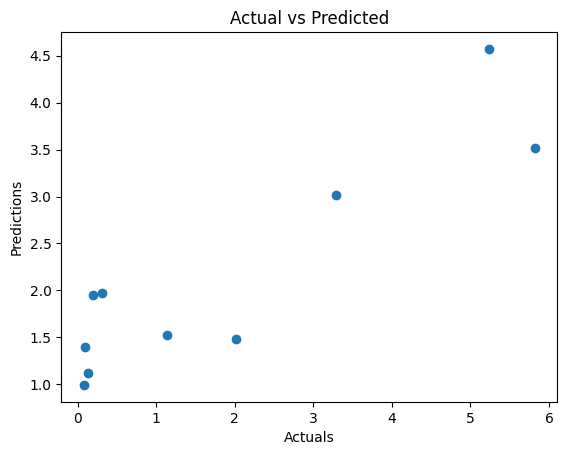

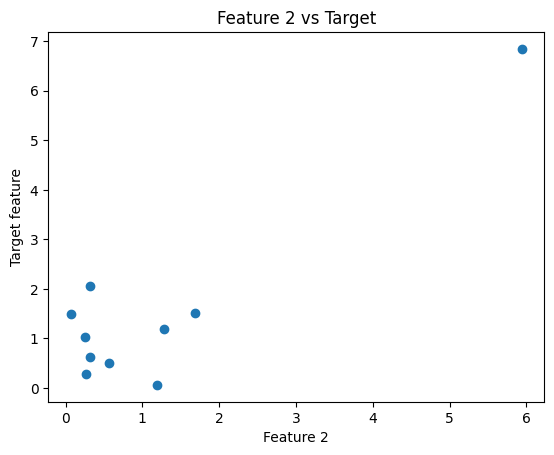

In [2]:
fpl = FPLSimpleEnv(n_players=10)

y, preds = fpl._get_y_and_preds(5)

fpl.plot_preds(4)
fpl.plot_feature_vs_target(2, 0)

In [3]:
def get_optimal_team(env, round, n_selected_players, max_cost, verbose=False, logging=False):

    points = env.data[:, -1, round] # Replace with expected points
    costs = env.data[:, -2, round]

    # Create a linear programming problem
    problem = pulp.LpProblem("Maximize_x_with_y_constraint", pulp.LpMaximize)

    # Create binary decision variables
    selection_vars = pulp.LpVariable.dicts("select", range(len(points)), cat=pulp.LpBinary)

    # Objective function: maximize the sum of selected elements in x
    problem += pulp.lpSum([points[i] * selection_vars[i] for i in range(len(points))]), "Objective"

    # Constraint 1: Sum of selected elements in y should be less than 5
    problem += pulp.lpSum([costs[i] * selection_vars[i] for i in range(len(costs))]) <= max_cost, "Sum_y_constraint"

    # Constraint 2: Select exactly n_select elements
    problem += pulp.lpSum([selection_vars[i] for i in range(len(points))]) == n_selected_players, "Number_of_selections"

    # Solve the problem
    problem.solve(pulp.PULP_CBC_CMD(gapRel=0, mip=True, msg=logging))

    status = pulp.LpStatus[problem.status]
    print("Solver status:", status)
    
    # Extract the selected elements
    selected_indices = [i for i in range(len(points)) if pulp.value(selection_vars[i]) == 1.0]
    selected_x = costs[selected_indices]
    selected_y = points[selected_indices]

    if verbose:
        print([pulp.value(selection_vars[i]) for i in range(len(points))])
        print(f'Points length {len(points)}')
        print("Selected indices:", selected_indices)
        print("Selected cost elements:", selected_x)
        print("Selected points elements:", selected_y)
        print("Sum of selected cost elements:", selected_x.sum())
        print("Sum of selected points elements:", selected_y.sum())

    if len(selected_indices) != n_selected_players:
        raise ValueError("Invalid number of players selected")

    return selected_indices, selected_y.sum(), selected_x.sum()

In [4]:
def get_current_team_points(env, team, round):
    return np.dot(np.array(team), env.data[:, -1, round])

def get_binary_array(n, idicies):
    arr = [0] * n
    for i in idicies:
        arr[i] = 1

    return arr

def get_greedy_team(env, round, current_team, max_cost, n_players):

    points = env.data[:, -1, round] # Replace with expected points
    costs = env.data[:, -2, round]
    sorted_indices = np.argsort(points)[::-1]
    sorted_points = [points[i] for i in sorted_indices]
    sorted_costs = [costs[i] for i in sorted_indices]

    optimising = True
    start_idx = 0
    while optimising:
    
        total_cost = 0
        total_points = 0
        greedy_optimal_team = []

        for i in range(start_idx, len(y)):
            if len(greedy_optimal_team) >= n_players:
                break
            if total_cost + sorted_costs[i] < max_cost:
                total_cost += sorted_costs[i]
                total_points += sorted_points[i]
                greedy_optimal_team.append(sorted_indices[i])

        if start_idx >= n_players:
            return current_team, 0, 0
        elif len(greedy_optimal_team) < n_players:
            start_idx += 1
        else:
            optimising = False

    return greedy_optimal_team, total_points, total_cost


# Greedy boi
COST_PER_CHANGE = 0.5
N_PLAYERS = 30
N_SELECTED_PLAYERS = 5
N_ROUNDS = 40
MAX_COST = 4

env = FPLSimpleEnv(n_players=N_PLAYERS, n_rounds=N_ROUNDS)
cumulative_points_list = []
prev_points = 0
cumulative_points_list_og = []
prev_points_og = 0


for round in range(env.n_rounds):

    if round == 0:
        current_team_indicies, _, _ = get_greedy_team(env, round, MAX_COST, N_SELECTED_PLAYERS)
        current_team = get_binary_array(N_PLAYERS, current_team_indicies)
        original_team = current_team.copy()
        print(current_team)

    # current_team_indicies = [z[0] for z in enumerate(current_team) if z[1] > 0]

    current_team_points = get_current_team_points(env, current_team, round)
    original_team_points = get_current_team_points(env, original_team, round)
    greedy_optimal_team, total_points, total_cost = get_greedy_team(env, round, MAX_COST, N_SELECTED_PLAYERS)
    
    print(f'Total points current team: {current_team_points}')
    print(f'Total points greedy team: {total_points}')

    n_player_changes = np.intersect1d(current_team_indicies, greedy_optimal_team)
    change_penalty = len(n_player_changes) * COST_PER_CHANGE
    change_benefit = total_points - current_team_points - change_penalty

    if change_benefit > 0:
        print(f'\tChanging team, change benefit = {change_benefit}')
        print(f'\tCurrent team: {current_team_indicies}')
        print(f'\tOptimal team: {greedy_optimal_team}')
        current_team = get_binary_array(N_PLAYERS, greedy_optimal_team)
        current_team_indicies = greedy_optimal_team
        cumulative_points_list.append(prev_points + total_points - change_penalty)
    else:
        cumulative_points_list.append(prev_points + current_team_points)

    prev_points = cumulative_points_list[-1]

    cumulative_points_list_og.append(prev_points_og + original_team_points)
    prev_points_og = cumulative_points_list_og[-1]

plt.figure()
plt.plot(cumulative_points_list, label='greedy team')
plt.plot(cumulative_points_list_og, label='original team')
plt.legend()
plt.show()

TypeError: get_greedy_team() missing 1 required positional argument: 'n_players'

round: 0
Solver status: Optimal
[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]

Generating optimal team
Solver status: Optimal
Current team: [5, 11, 13, 16, 27], 
Optimal team: [5, 11, 13, 16, 27]
Optimal team cost: 4.962812453510344

Generating greedy team
[16, 11, 17, 13, 26]
Current team: [16, 11, 17, 13, 26], 
Greedy team: [16, 11, 17, 13, 26]
Greedy team cost: 3.1471065906203854
round: 1

Generating optimal team
Solver status: Optimal
Current team: [5, 11, 13, 16, 27], 
Optimal team: [7, 17, 19, 25, 28]
Optimal team cost: 4.777767856328563
	Changing team, change benefit = 8.644499462969048

Generating greedy team
[16, 11, 17, 13, 26]
Current team: [16, 11, 17, 13, 26], 
Greedy team: [16, 11, 17, 13, 26]
Greedy team cost: 0
round: 2

Generating optimal team
Solver status: Optimal
Current team: [7, 17, 19, 25, 28], 
Optimal team: [0, 1, 15, 18, 28]
Optimal team cost: 4.29983237939752
	Changing team, change benefit = 5.819367995914733

Gene

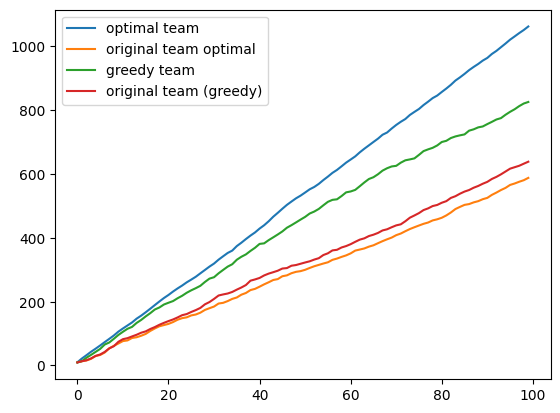

In [ ]:
def get_current_team_points(env, team, round):
    return np.dot(np.array(team), env.data[:, -1, round])

def get_binary_array(n, idicies):
    arr = [0] * n
    for i in idicies:
        arr[i] = 1

    return arr

# Greedy boi
COST_PER_CHANGE = 0.5
MAX_COST = 5
N_PLAYERS = 30
N_SELECTED_PLAYERS = 5.0
N_ROUNDS = 100
env = FPLSimpleEnv(n_players=N_PLAYERS, n_rounds=N_ROUNDS)

cumulative_points_list_opt = []
prev_points_opt = 0
cumulative_points_list_og = []
prev_points_og = 0
cumulative_points_list_greedy = []
prev_points_greedy = 0
cumulative_points_list_og_greedy = []
prev_points_og_greedy = 0

for round in range(env.n_rounds):
    print(f'round: {round}')
    if round == 0:
        current_team_indicies, _, _ = get_optimal_team(env, round, N_SELECTED_PLAYERS, MAX_COST)
        current_team = get_binary_array(N_PLAYERS, current_team_indicies)
        original_team = current_team.copy()

        current_team_indicies_greedy, _, _ = get_greedy_team(env, round, None, MAX_COST, N_SELECTED_PLAYERS)
        current_team_greedy = get_binary_array(N_PLAYERS, current_team_indicies_greedy)
        original_team_greedy = current_team_greedy.copy()
        print(current_team)

    #===================== Optimal team
    print(f'\nGenerating optimal team')
    optimal_team_indicies, total_points, total_cost = get_optimal_team(env,round, N_SELECTED_PLAYERS, MAX_COST)
    optimal_team = get_binary_array(N_PLAYERS, optimal_team_indicies)

    current_team_points = get_current_team_points(env, current_team, round)
    original_team_points = get_current_team_points(env, original_team, round)

    print(f'Current team: {current_team_indicies}, ')
    print(f'Optimal team: {optimal_team_indicies}')
    print(f'Optimal team cost: {total_cost}')

    n_player_changes = np.intersect1d(current_team_indicies, optimal_team_indicies)
    change_penalty = len(n_player_changes) * COST_PER_CHANGE
    change_benefit = total_points - current_team_points - change_penalty

    if change_benefit > 0:
        print(f'\tChanging team, change benefit = {change_benefit}')
        current_team = get_binary_array(N_PLAYERS, optimal_team_indicies)
        current_team_indicies = optimal_team_indicies
        cumulative_points_list_opt.append(prev_points_opt + total_points - change_penalty)
    else:
        cumulative_points_list_opt.append(prev_points_opt + current_team_points)

    prev_points_opt = cumulative_points_list_opt[-1]

    cumulative_points_list_og.append(prev_points_og + original_team_points)
    prev_points_og = cumulative_points_list_og[-1]

    #======================= Greedy team
    print(f'\nGenerating greedy team')
    optimal_team_indicies_greedy, total_points_greedy, total_cost_greedy = get_greedy_team(env, round, current_team_indicies_greedy, MAX_COST, N_SELECTED_PLAYERS)
    optimal_team_greedy = get_binary_array(N_PLAYERS, optimal_team_indicies_greedy)

    print(optimal_team_indicies_greedy)

    current_team_points_greedy = get_current_team_points(env, current_team_greedy, round)
    original_team_points_greedy = get_current_team_points(env, original_team_greedy, round)
    
    print(f'Current team: {current_team_indicies_greedy}, ')
    print(f'Greedy team: {optimal_team_indicies_greedy}')
    print(f'Greedy team cost: {total_cost_greedy}')

    n_player_changes = np.intersect1d(current_team_indicies_greedy, optimal_team_indicies_greedy)
    change_penalty = len(n_player_changes) * COST_PER_CHANGE
    change_benefit = total_points_greedy - current_team_points_greedy - change_penalty

    if change_benefit > 0:
        print(f'\tChanging team, change benefit = {change_benefit}')
        current_team_greedy = get_binary_array(N_PLAYERS, optimal_team_indicies_greedy)
        current_team_indicies_greedy = optimal_team_indicies_greedy
        cumulative_points_list_greedy.append(prev_points_greedy + total_points_greedy - change_penalty)
    else:
        cumulative_points_list_greedy.append(prev_points_greedy + current_team_points_greedy)

    prev_points_greedy = cumulative_points_list_greedy[-1]

    cumulative_points_list_og_greedy.append(prev_points_og_greedy + original_team_points_greedy)
    prev_points_og_greedy = cumulative_points_list_og_greedy[-1]


plt.figure()
plt.plot(cumulative_points_list_opt, label='optimal team')
plt.plot(cumulative_points_list_og, label='original team optimal')
plt.plot(cumulative_points_list_greedy, label='greedy team')
plt.plot(cumulative_points_list_og_greedy, label='original team (greedy)')
plt.legend()
plt.show()
    

## Data Analysis

In [260]:
MIN_CORR_THRESHOLD = 0.3
target_in = 'total_points_sum_n3r'
target = 'total_points_sum_n3r_bin'
# target = 'minutes_nr'

df = pd.read_csv('modelling_data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31689 entries, 0 to 31688
Columns: 790 entries, Unnamed: 0 to minutes_nr
dtypes: float64(737), int64(50), object(3)
memory usage: 191.0+ MB


[]

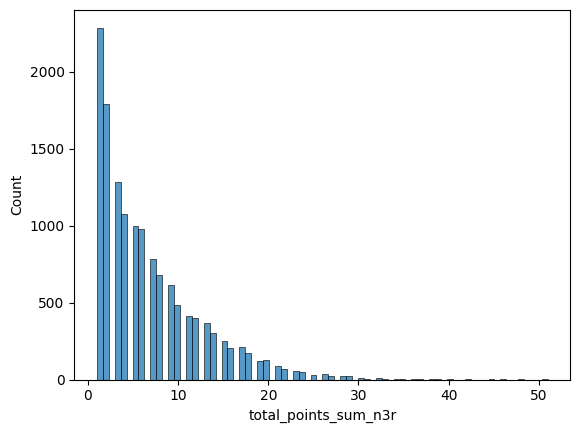

In [251]:
sns.histplot(df[df['total_points_sum_n3r']>0.0]['total_points_sum_n3r'])
plt.plot()

In [60]:
print(df.columns.to_list())
print(len(df.columns.to_list()))

['Unnamed: 0', 'element', 'round', 'fixture', 'team_name', 'player_name', 'position', 'position_code', 'team_code', 'opp_round_1', 'opp_round_2', 'opp_round_3', 'opp_round_4', 'opp_round_5', 'opp_round_6', 'total_points', 'value', 'transfers_balance', 'selected', 'transfers_in', 'transfers_out', 'ict_index', 'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded', 'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards', 'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity', 'threat', 'was_home', 'starts', 'expected_goals', 'expected_assists', 'expected_goal_involvements', 'expected_goals_conceded', 'total_points_sum_l3r', 'value_sum_l3r', 'transfers_balance_sum_l3r', 'selected_sum_l3r', 'transfers_in_sum_l3r', 'transfers_out_sum_l3r', 'ict_index_sum_l3r', 'minutes_sum_l3r', 'goals_scored_sum_l3r', 'assists_sum_l3r', 'clean_sheets_sum_l3r', 'goals_conceded_sum_l3r', 'own_goals_sum_l3r', 'penalties_saved_sum_l3r', 'penalties_missed_sum_l3r', 'yellow_ca

In [261]:
# def create_bins(group, target_in, target_out, n_bins=10):
#     group[target_out] = pd.qcut(group[target_in], n_bins,  duplicates='drop')
#     return group

# df = df.groupby(['round'], group_keys=False).apply(create_bins, target_in=target_in, target_out=target, n_bins=10)


df[target], edges = pd.qcut(df[target_in], 10, labels=False, retbins=True, duplicates='drop')
df

Unnamed: 0  element  round  fixture  team_name      player_name  \
0               0        1      1        2    Arsenal  Folarin Balogun   
1               1        1      2       12    Arsenal  Folarin Balogun   
2               2        1      3       21    Arsenal  Folarin Balogun   
3               3        1      4       31    Arsenal  Folarin Balogun   
4               4        1      5       43    Arsenal  Folarin Balogun   
...           ...      ...    ...      ...        ...              ...   
31684       31684      862     37      339      Spurs      Tyrese Hall   
31685       31685      862     37      339      Spurs      Tyrese Hall   
31686       31686      862     38      380      Spurs      Tyrese Hall   
31687       31687      863     38      371    Everton    Billy Crellin   
31688       31688      864     38      372  Brentford      Yunus Konak   

      position  position_code  team_code  opp_round_1  opp_round_2  \
0          FWD              4          3          8.0         10.0   
1          FWD              4          3         10.0         14.0   
2          FWD              4          3         14.0          9.0   
3          FWD              4          3          9.0         18.0   
4          FWD              4          3         18.0          3.0   
...        ...            ...        ...          ...          ...   
31684      MID              3          6         17.0          0.0   
31685      MID              3          6         17.0          0.0   
31686      MID              3          6          0.0          0.0   
31687      GKP              1         11          0.0          0.0   
31688      MID              3         94          0.0          0.0   

       opp_round_3  opp_round_4  opp_round_5  opp_round_6  total_points  \
0             14.0          9.0         18.0          3.0             0   
1              9.0         18.0          3.0         13.0             0   
2             18.0          3.0         13.0          7.0             0   
3              3.0         13.0          7.0         17.0             0   
4             13.0          7.0         17.0         15.0             0   
...            ...          ...          ...          ...           ...   
31684          0.0          0.0          0.0          0.0             0   
31685          0.0          0.0          0.0          0.0             0   
31686          0.0          0.0          0.0          0.0             0   
31687          0.0          0.0          0.0          0.0             0   
31688          0.0          0.0          0.0          0.0             0   

       value  transfers_balance  selected  transfers_in  transfers_out  \
0         45                  0     59090             0              0   
1         45              -4744     63768          4959           9703   
2         45              -7682     58109          2507          10189   
3         44              -9696     49814          2558          12254   
4         44             -12786     37048             0          12786   
...      ...                ...       ...           ...            ...   
31684     45                  0         0             0              0   
31685     45                  0         0             0              0   
31686     45                 28        34            35              7   
31687     40                  0         0             0              0   
31688     45                  0         0             0              0   

       ict_index  minutes  goals_scored  assists  clean_sheets  \
0            0.0        0             0        0             0   
1            0.0        0             0        0             0   
2            0.0        0             0        0             0   
3            0.0        0             0        0             0   
4            0.0        0             0        0             0   
...          ...      ...           ...      ...           ...   
31684        0.0        0

In [262]:

df[target].value_counts()

0    17688
2     3076
3     3047
5     3033
4     2557
1     2288
Name: total_points_sum_n3r_bin, dtype: int64

In [263]:
edges

array([-4.,  0.,  1.,  3.,  6., 10., 51.])

In [74]:
corr = df.corr()[target].sort_values(ascending=False)
top_corr = corr[abs(corr)>=MIN_CORR_THRESHOLD]
print(top_corr)
print(top_corr.shape)

/var/folders/ym/d61c4fn95wnc49fhqpl3s4480000gn/T/ipykernel_4934/3358566167.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()[target].sort_values(ascending=False)


total_points_sum_n3r_bin                        1.000000
total_points_sum_n3r                            0.895408
total_points_sum_n6r                            0.847070
minutes_nr                                      0.786310
total_points_sum_all                            0.751760
                                                  ...   
clean_sheets_stdsclr                            0.307184
transfers_out_sum_l6r_cum_pct_of_max            0.304184
transfers_out_sum_l6r_cum_pct_of_max_stdsclr    0.304184
selected_sum_l6r_cum_pct_of_max_stdsclr         0.303622
selected_sum_l6r_cum_pct_of_max                 0.303622
Name: total_points_sum_n3r_bin, Length: 375, dtype: float64
(375,)


In [75]:
normalised_features = [feature for feature in top_corr.index if 'pct_of_max' in feature or '_stdsclr' in feature]
normalised_features[:10]

['minutes_sum_l3r_pct_of_max',
 'minutes_sum_l3r_pct_of_max_stdsclr',
 'minutes_sum_l6r_pct_of_max',
 'minutes_sum_l6r_pct_of_max_stdsclr',
 'minutes_stdsclr',
 'minutes_pct_of_max_stdsclr',
 'minutes_pct_of_max',
 'minutes_sum_l3r_stdsclr',
 'starts_sum_l6r_pct_of_max_stdsclr',
 'starts_sum_l6r_pct_of_max']

In [76]:
def plot_multi_hist2d(df, target, features, n_bins=50, figsize=(12, 3)) -> None:
    for i, feature in enumerate(features):
        i_adj = i % 4
        if i_adj == 0:
            fig, axs = plt.subplots(1, 4, tight_layout=True, figsize=figsize)

        axs[i_adj].hist2d(df[feature], df[target], bins=(n_bins, n_bins), cmap='Blues')
        # cb = plt.colorbar(label='count in bin')
        axs[i_adj].set_ylabel(target)
        axs[i_adj].set_xlabel(feature)

        if i_adj == 3:
            plt.show()



/var/folders/ym/d61c4fn95wnc49fhqpl3s4480000gn/T/ipykernel_4934/2899475878.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nonzero_minutes.fillna(0.0, inplace=True)


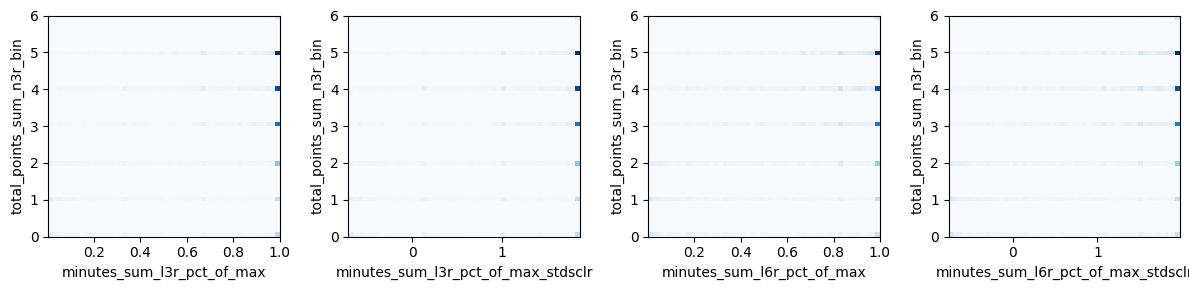

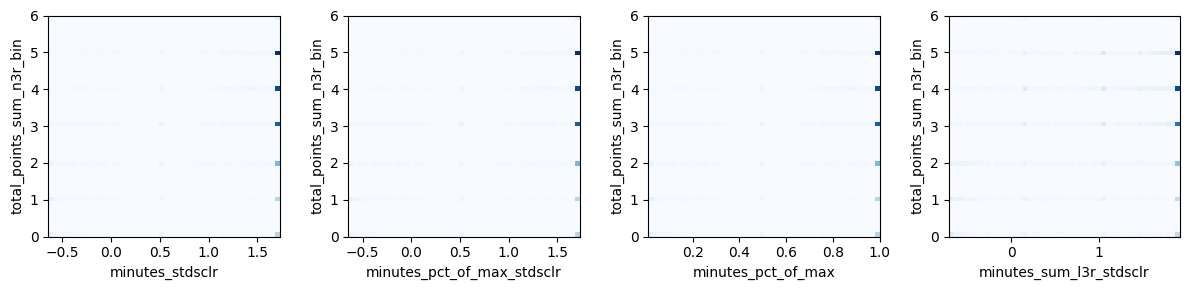

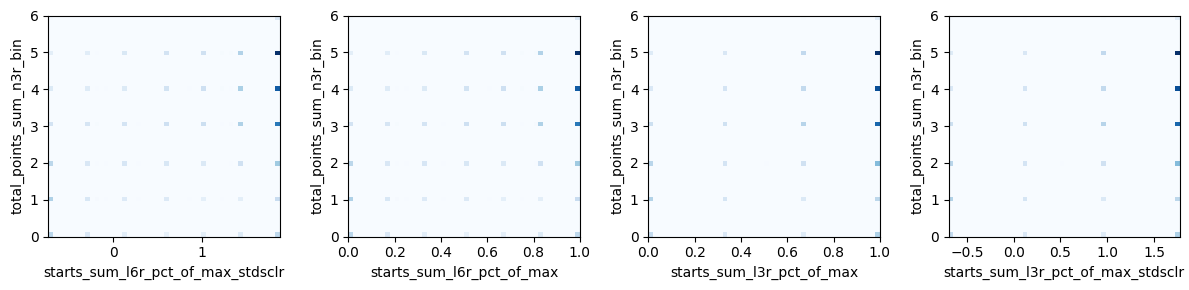

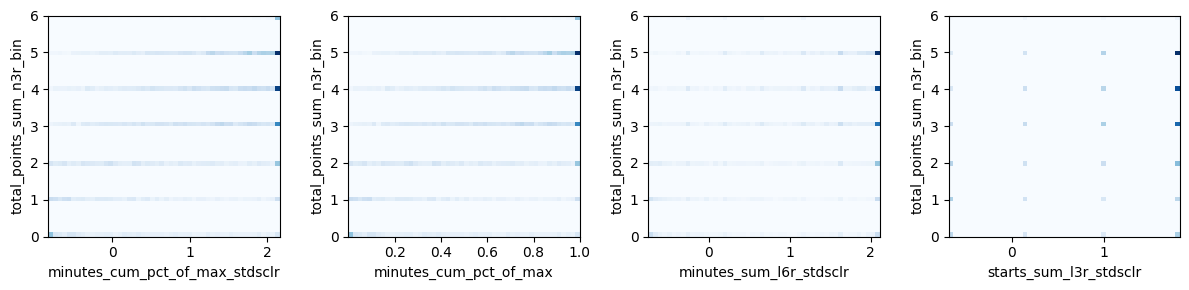

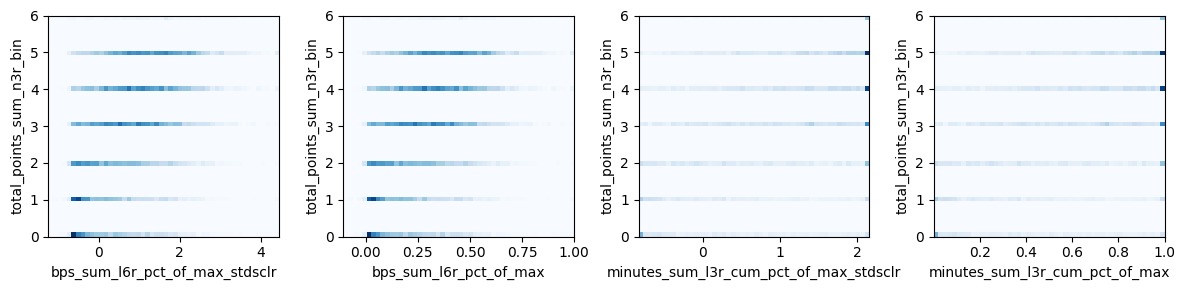

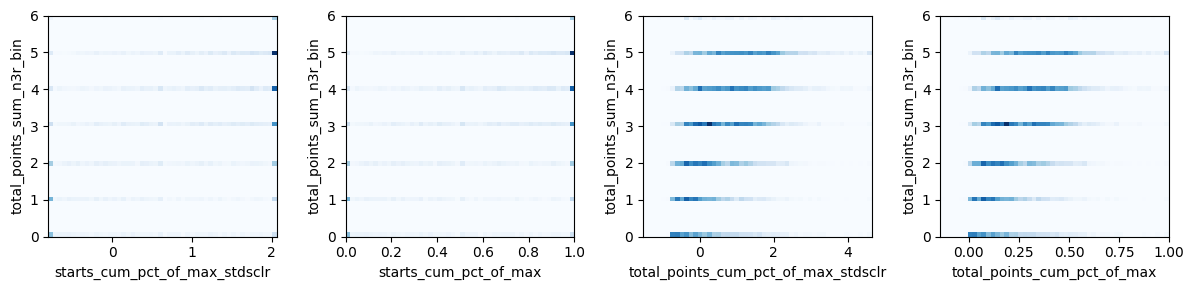

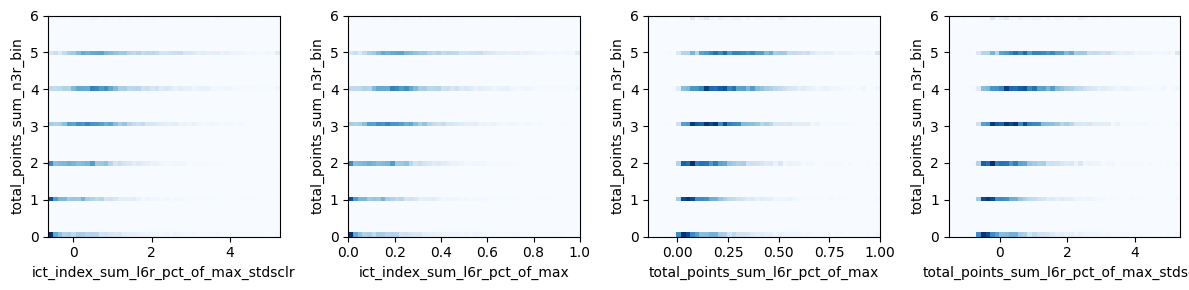

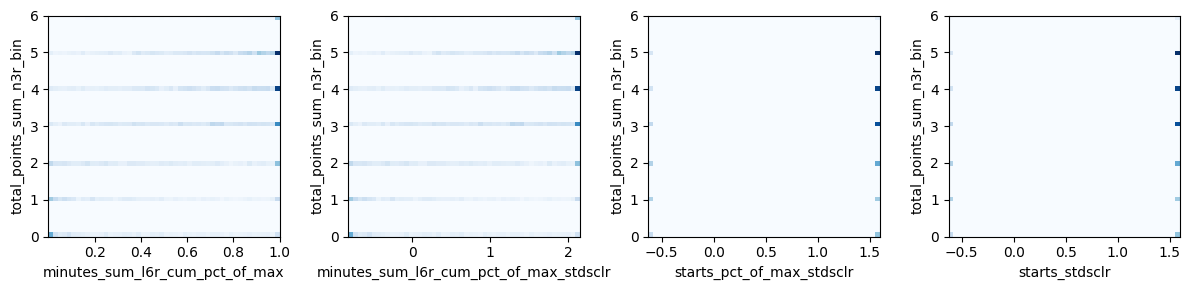

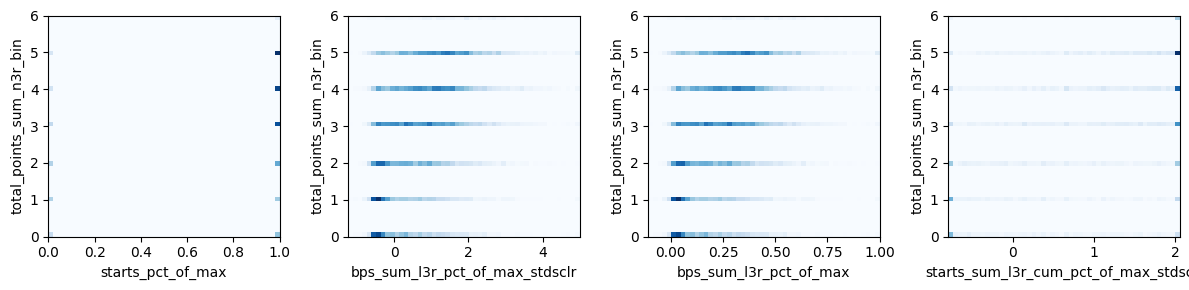

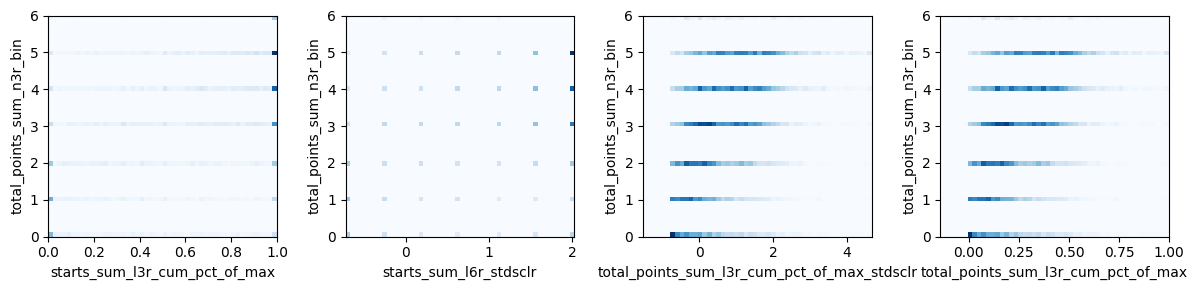

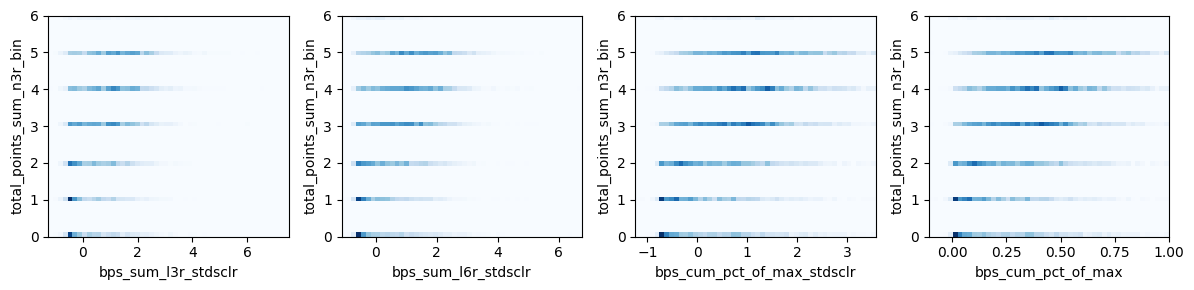

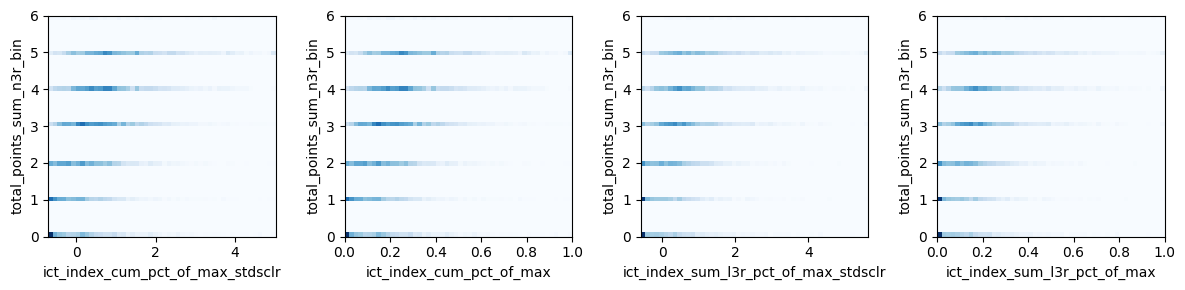

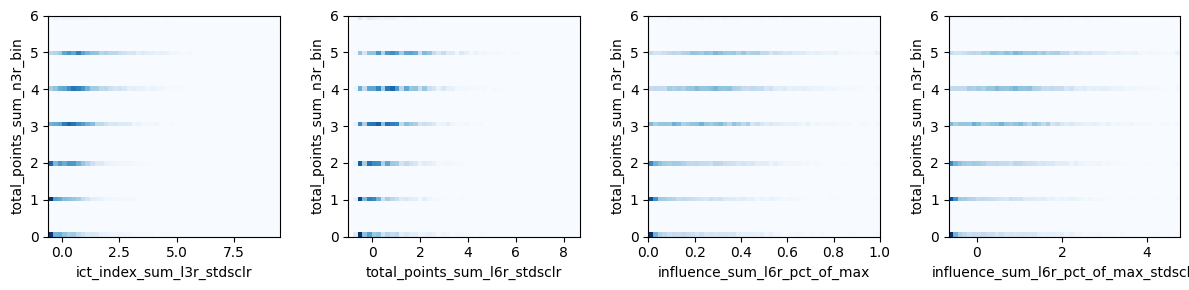

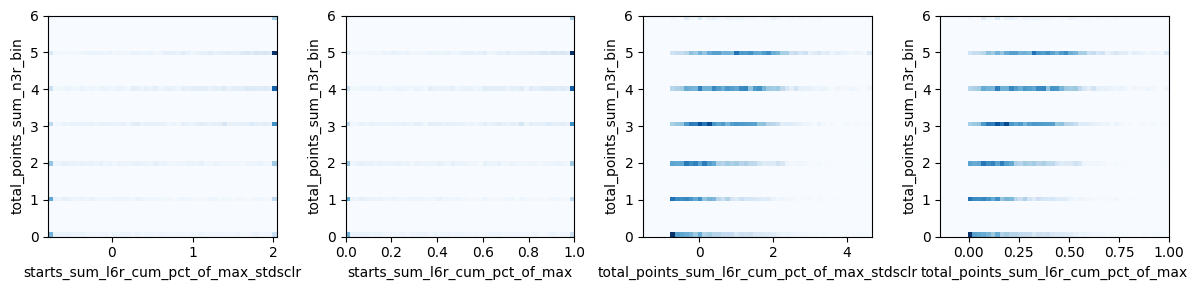

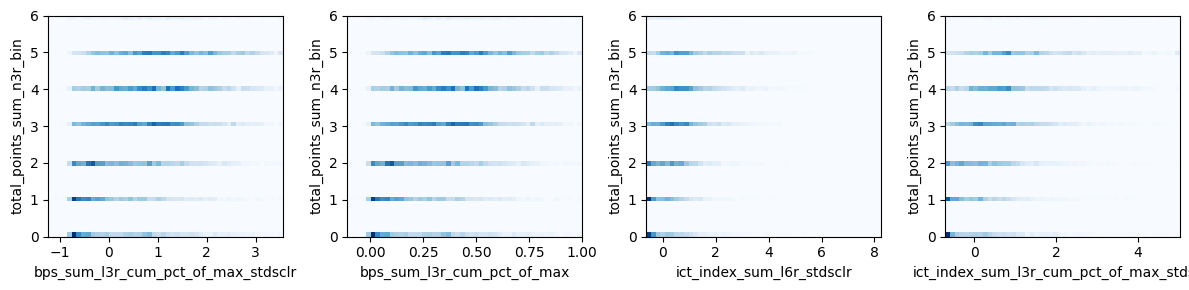

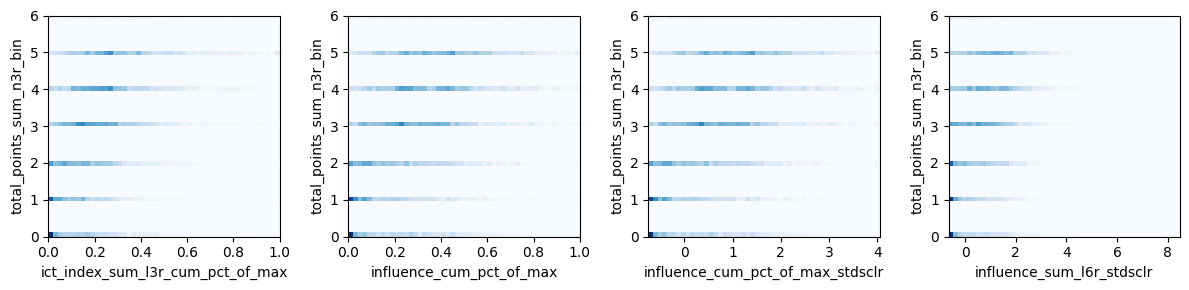

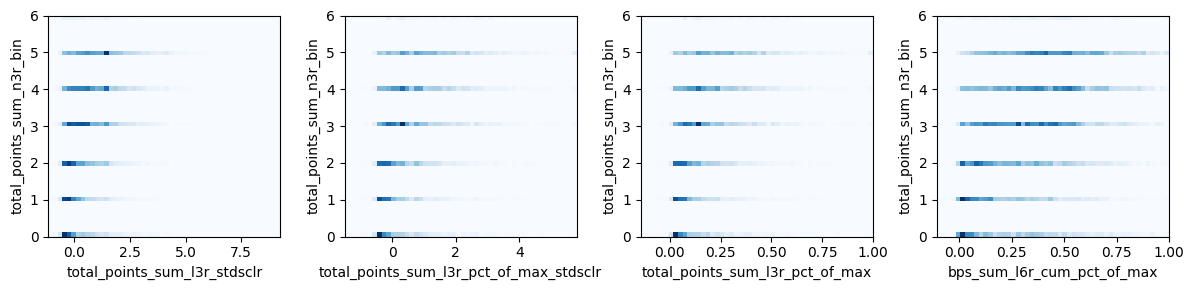

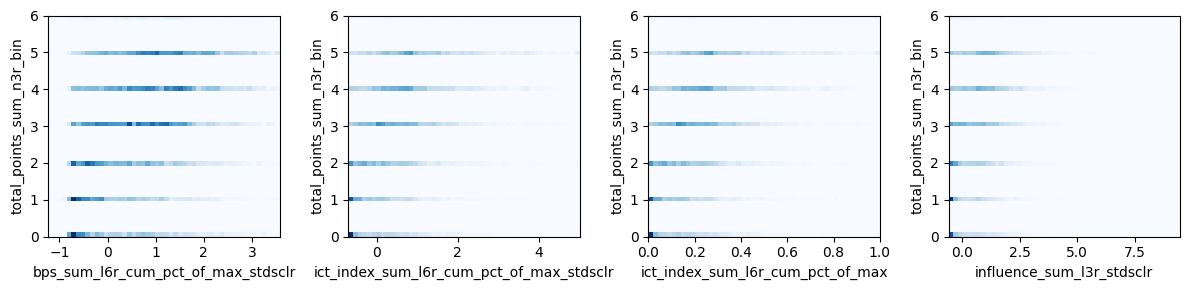

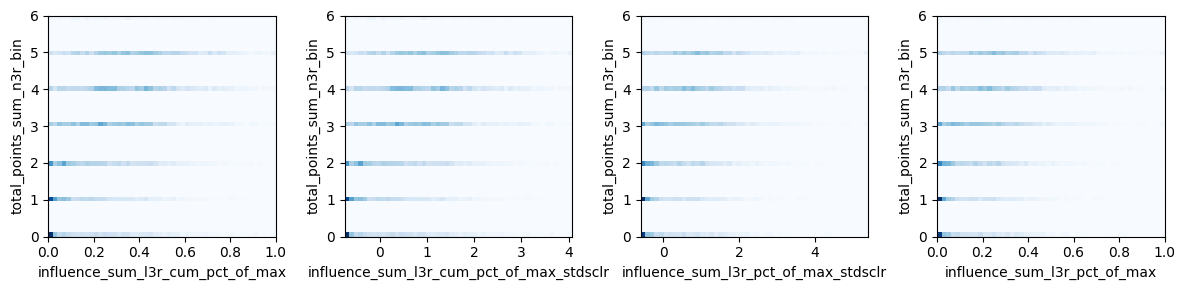

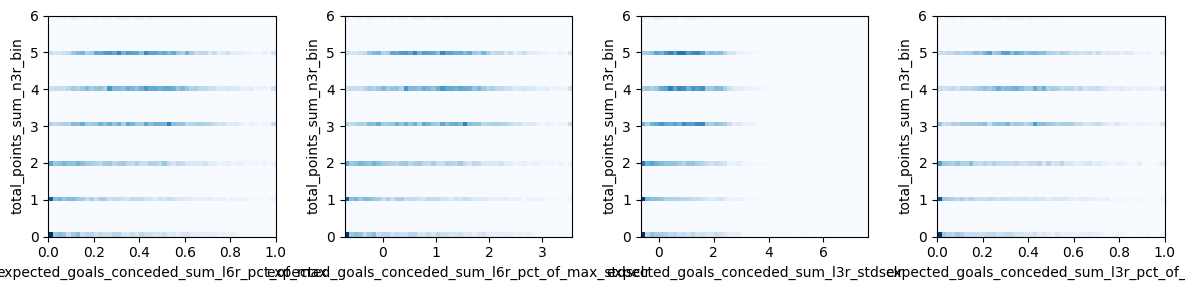

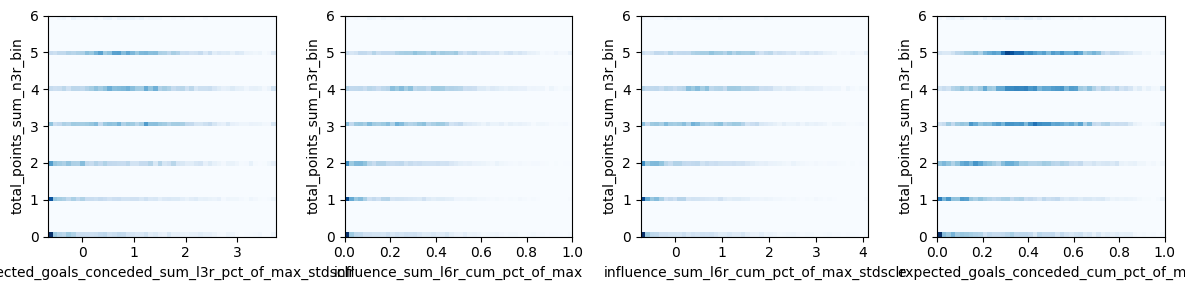

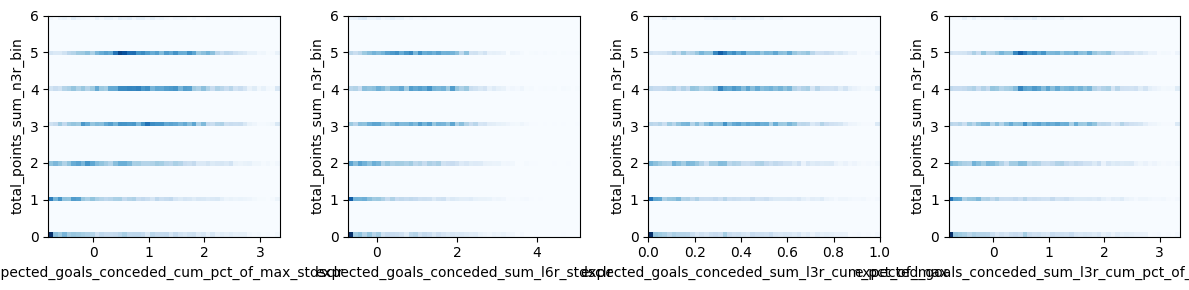

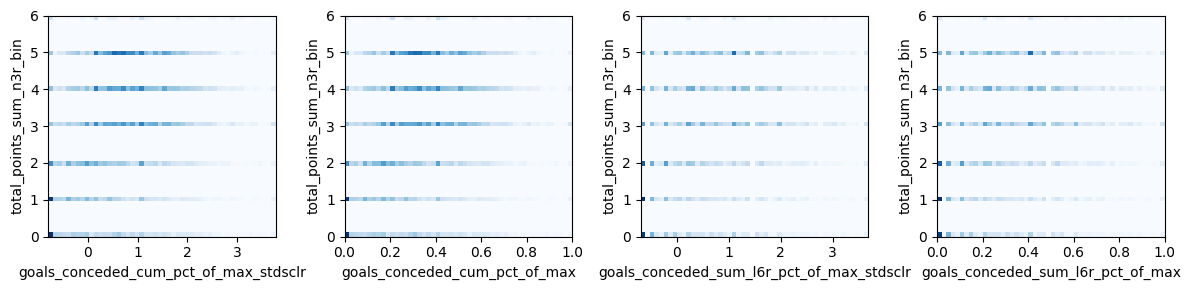

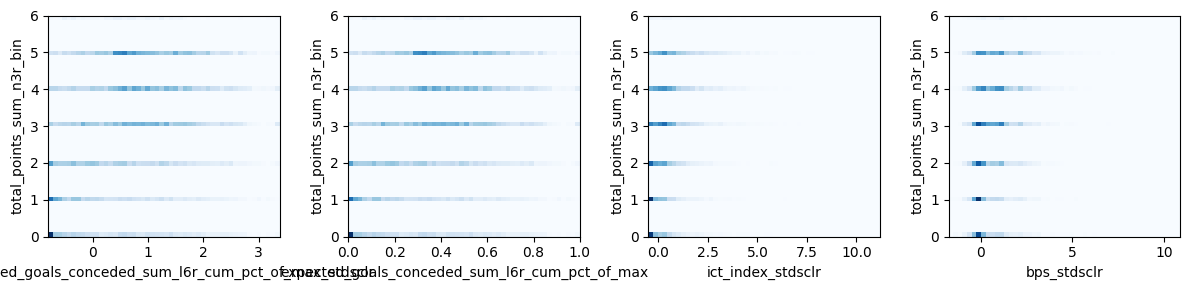

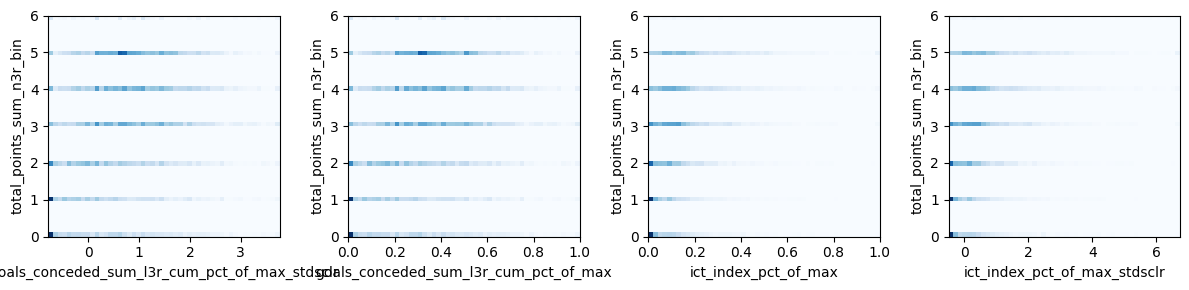

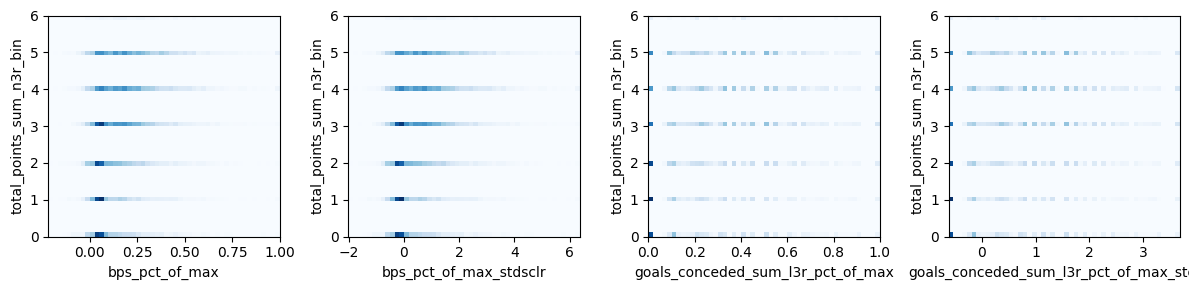

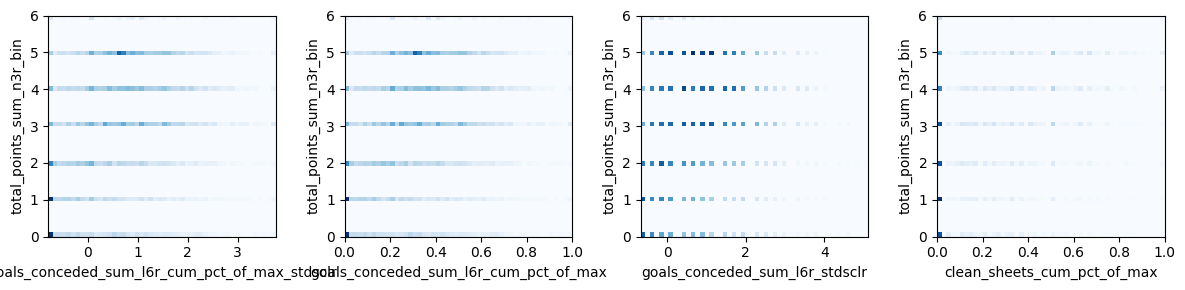

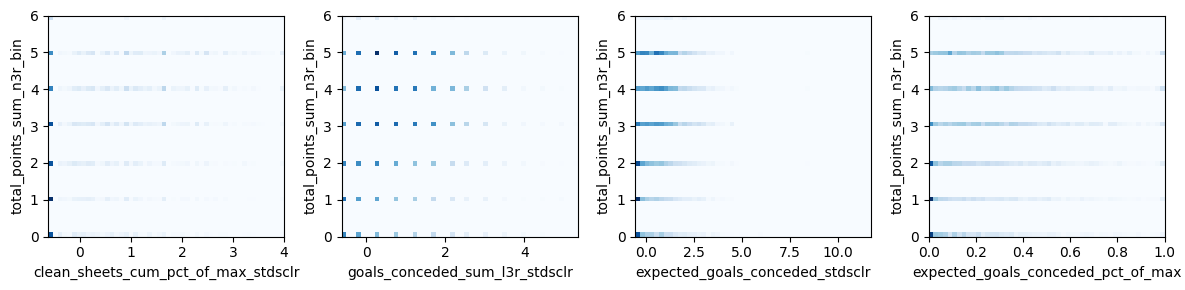

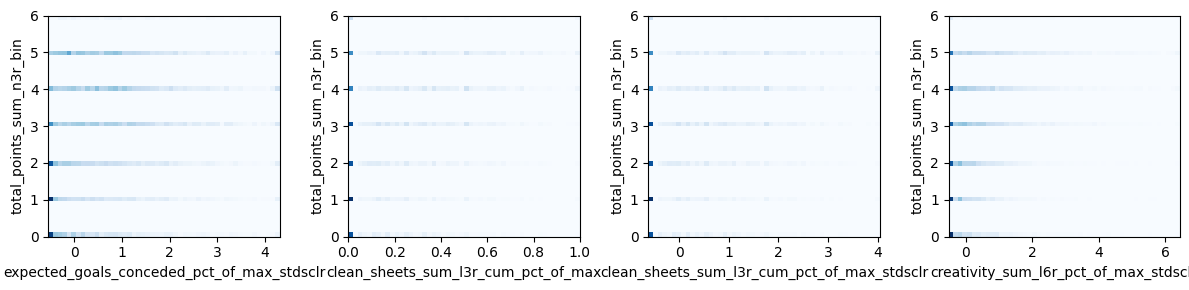

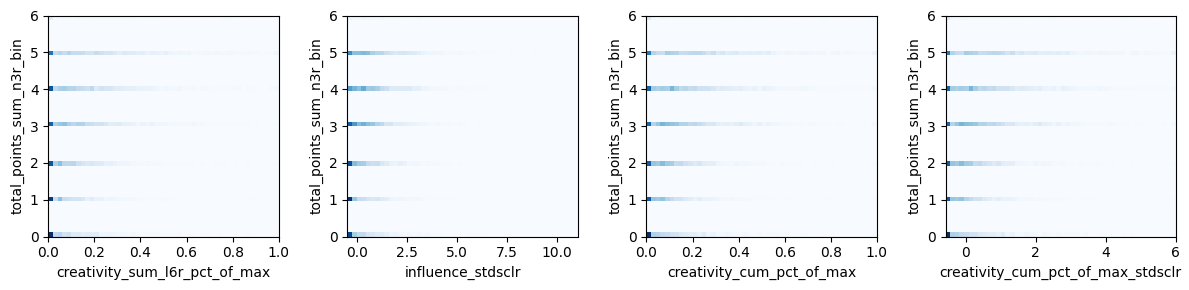

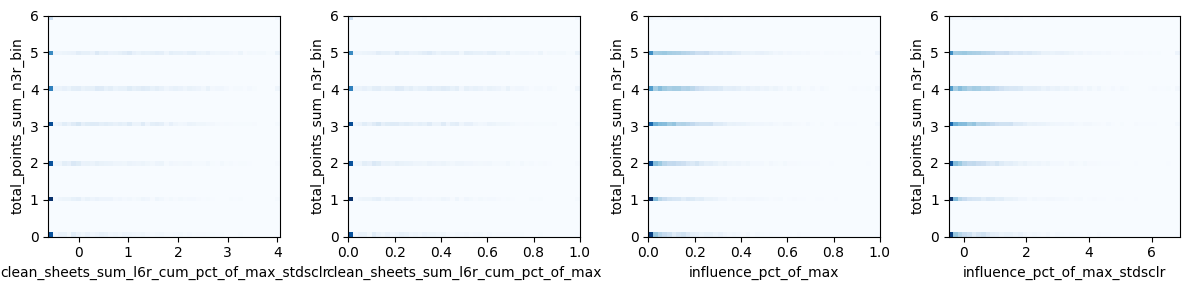

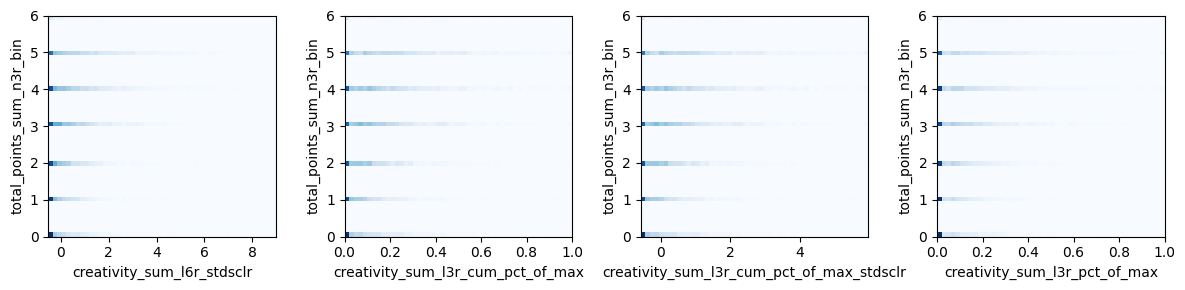

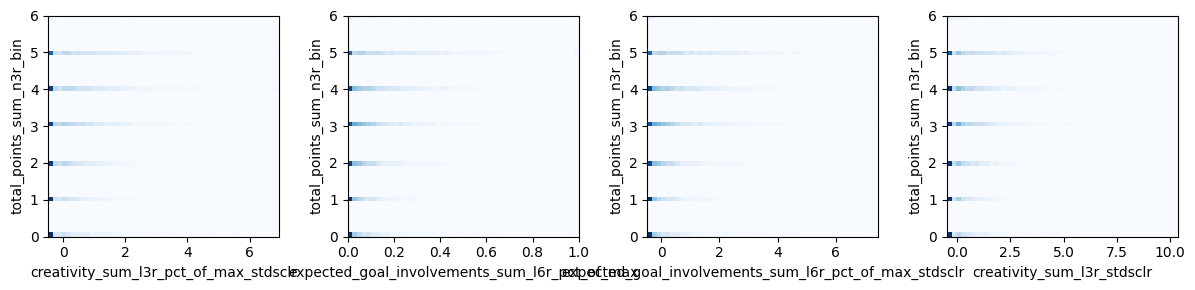

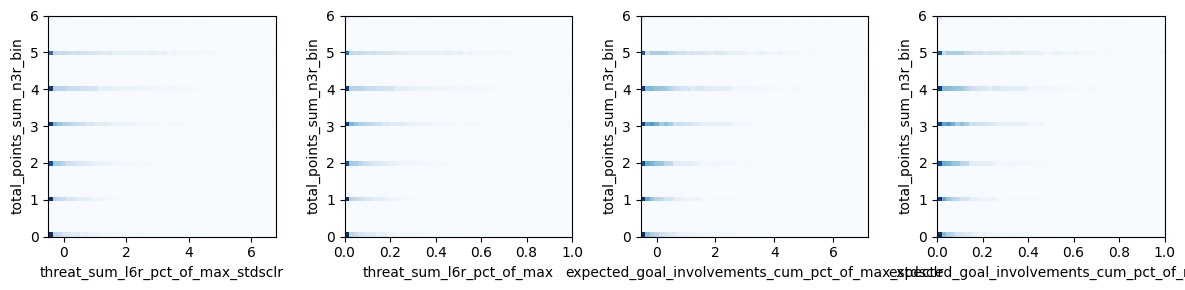

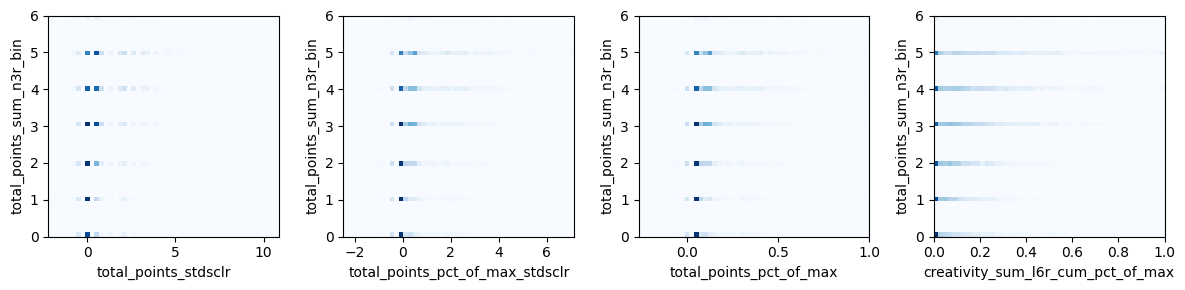

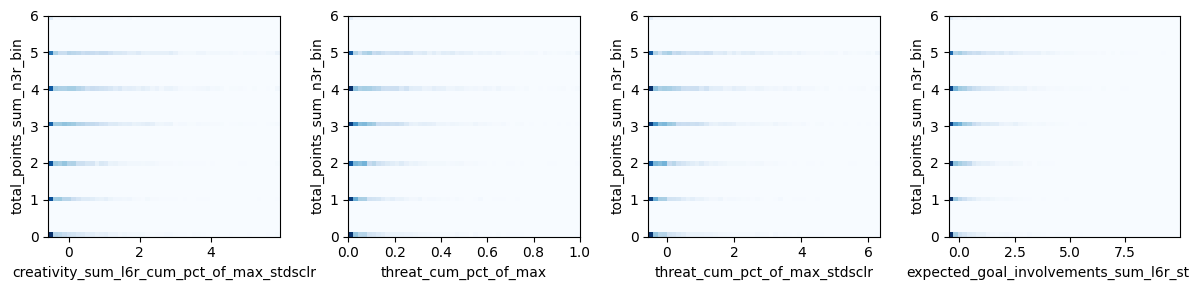

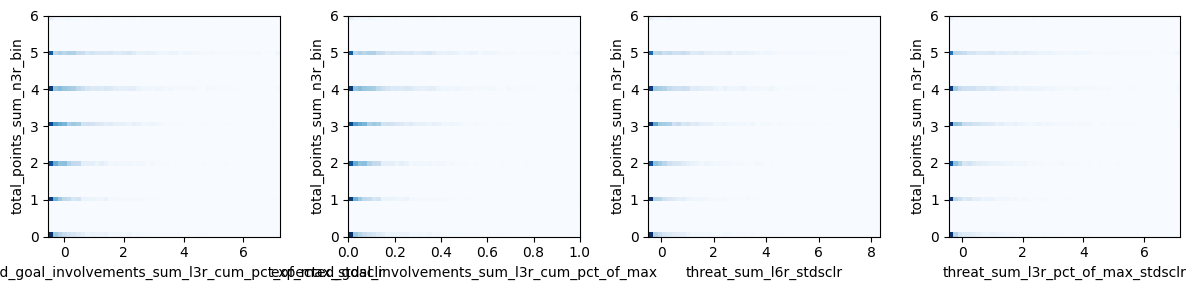

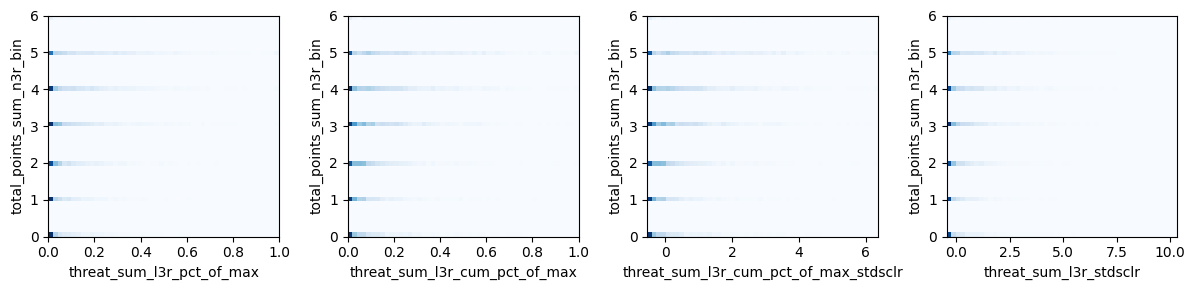

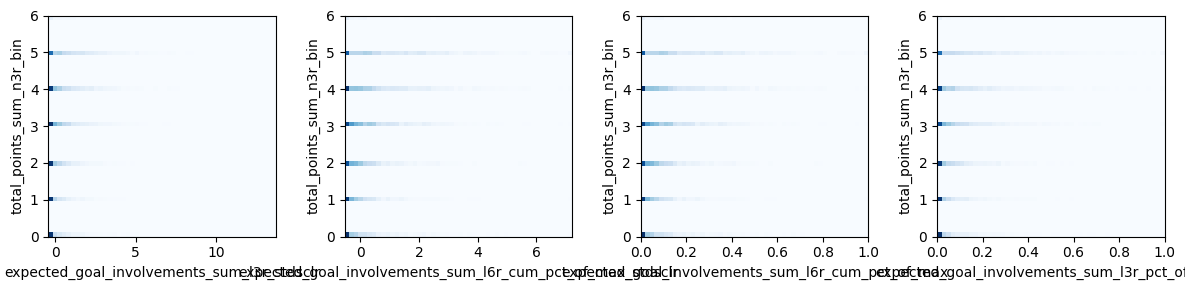

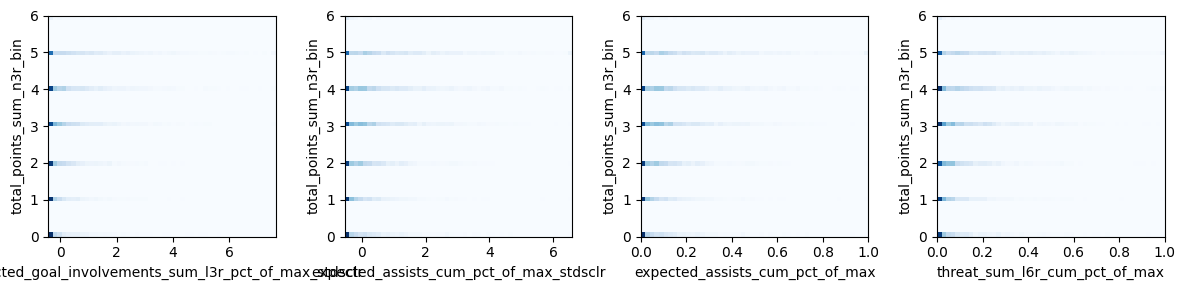

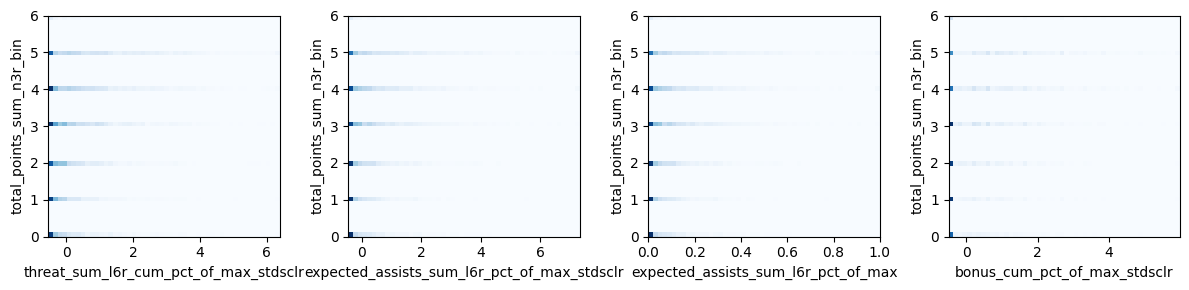

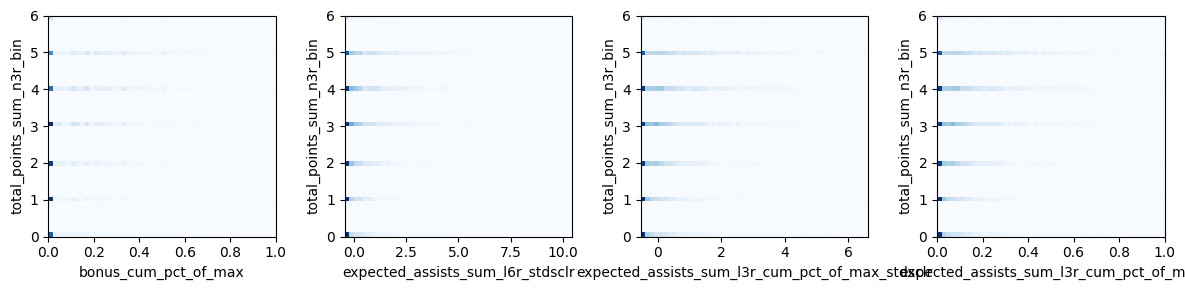

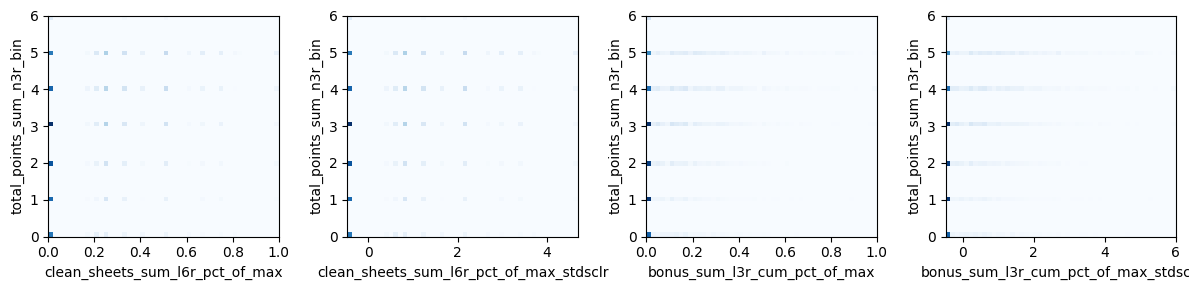

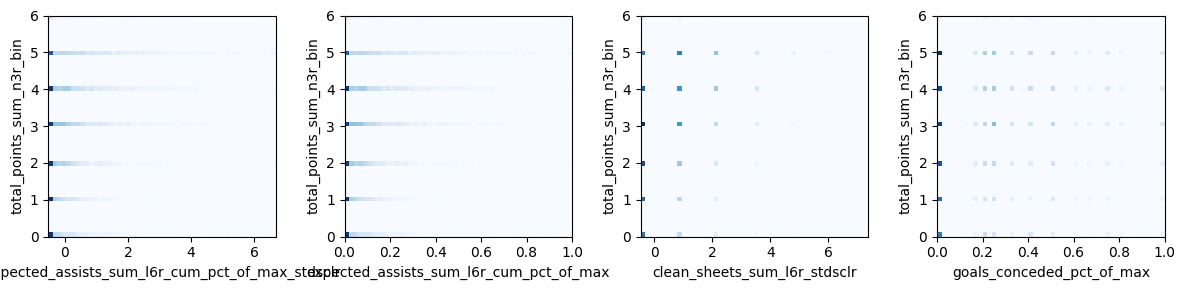

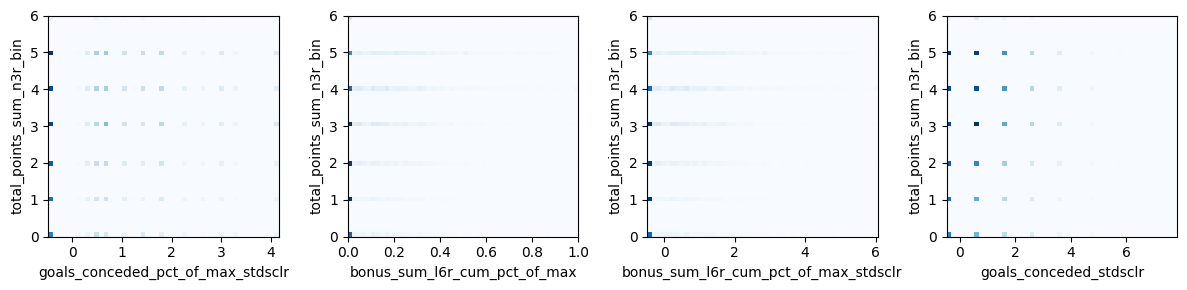

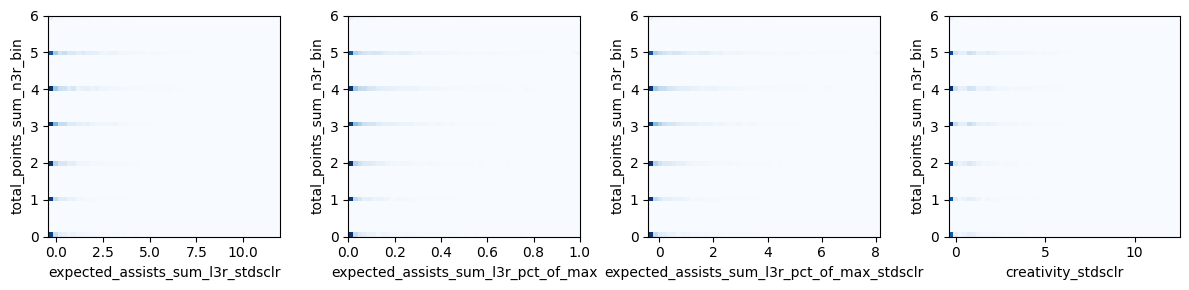

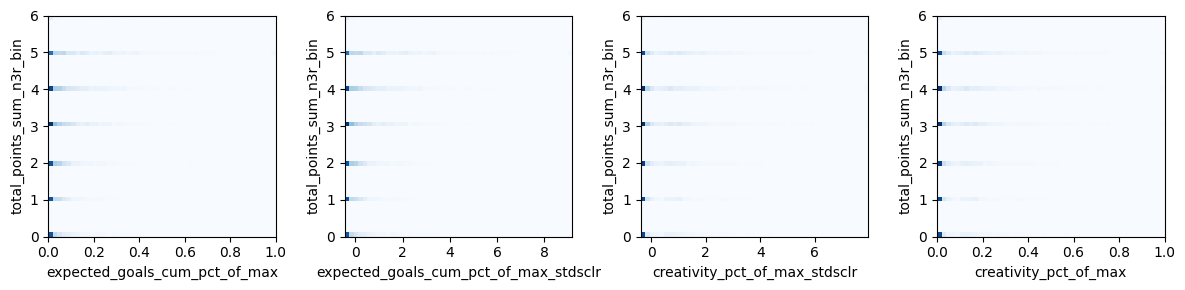

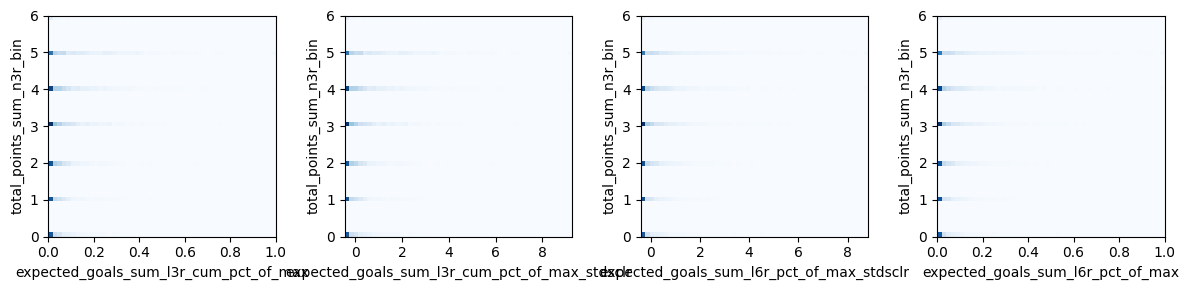

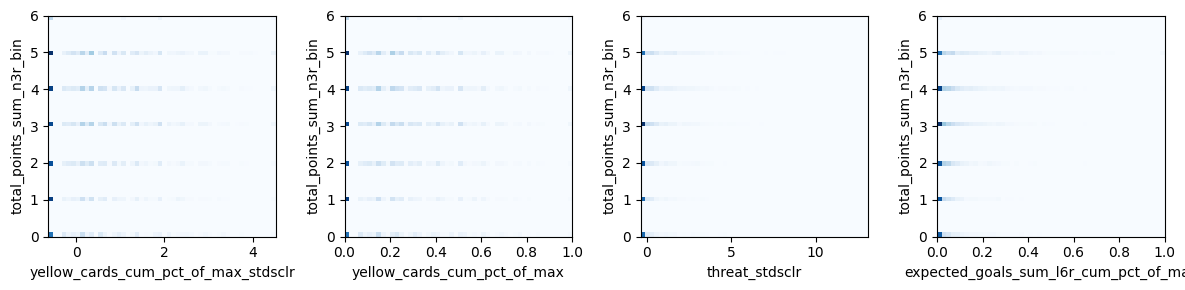

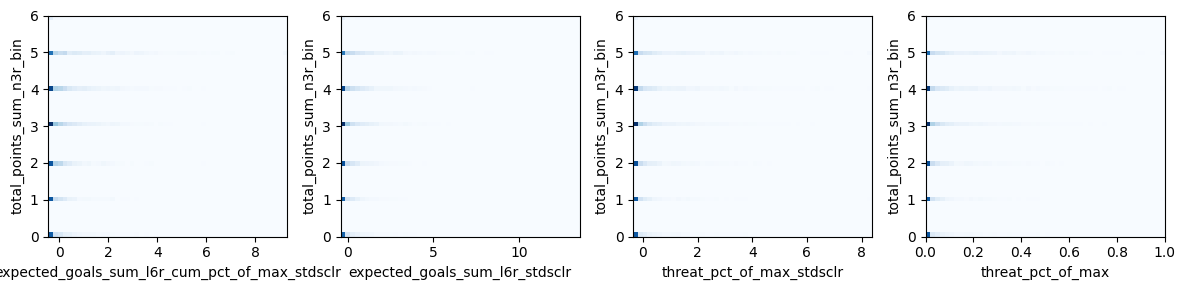

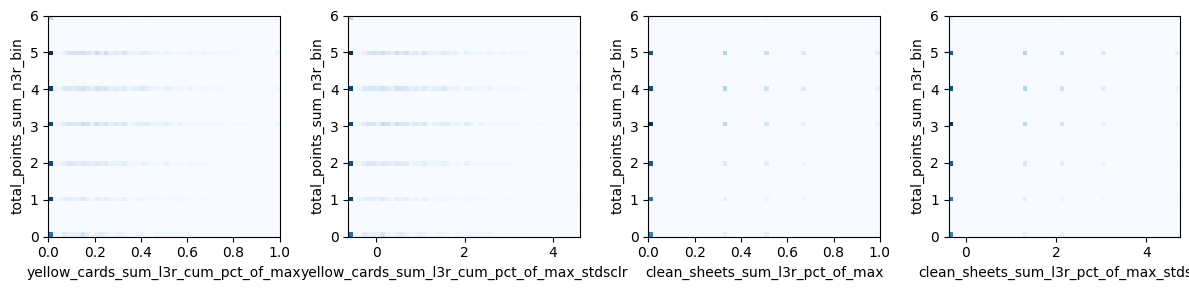

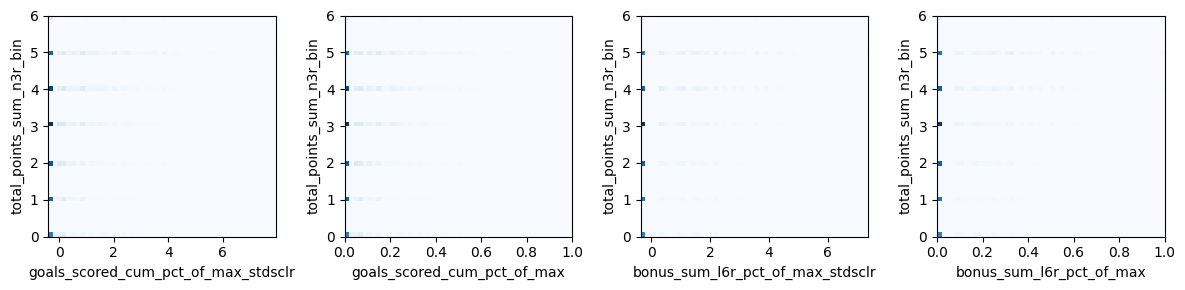

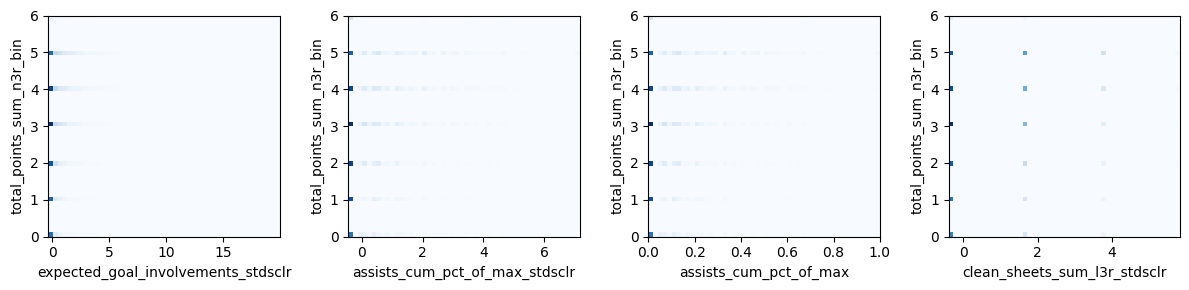

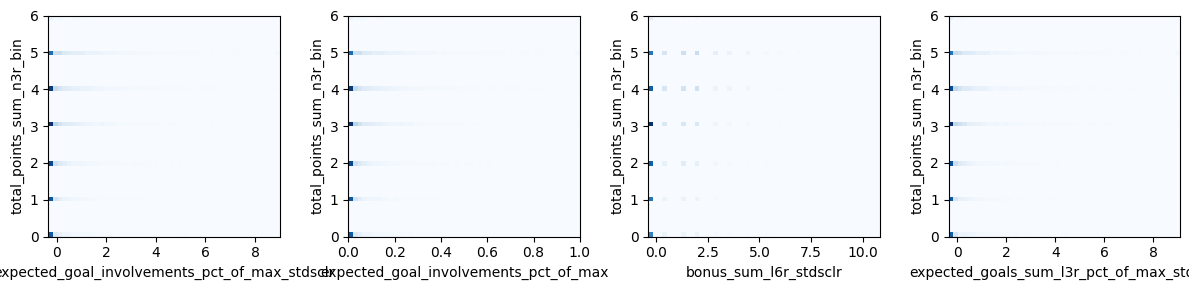

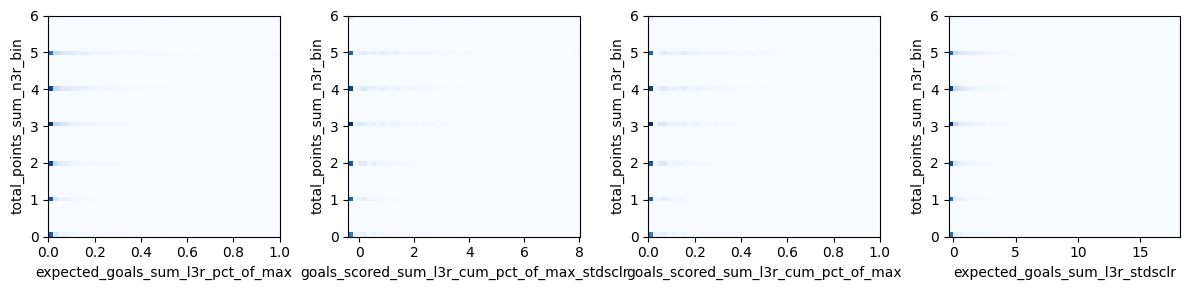

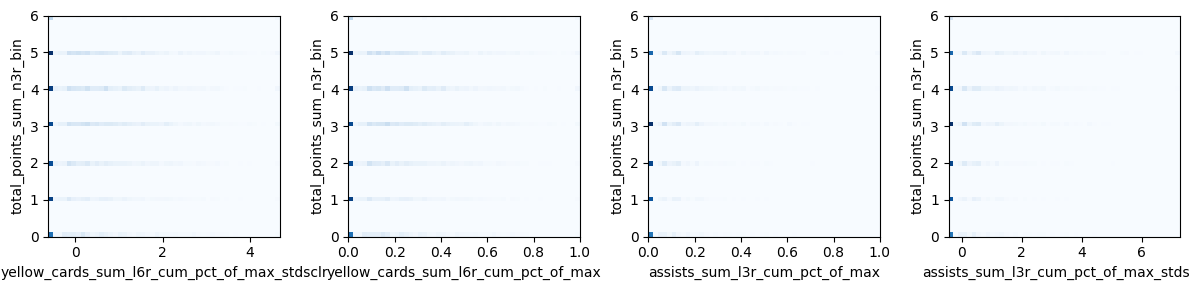

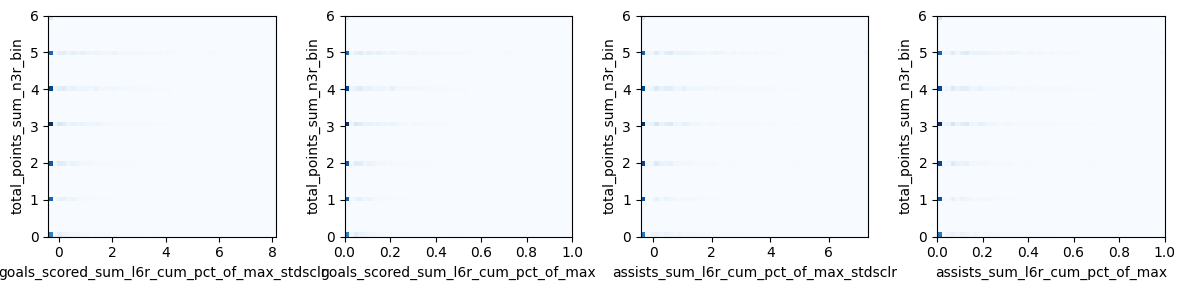

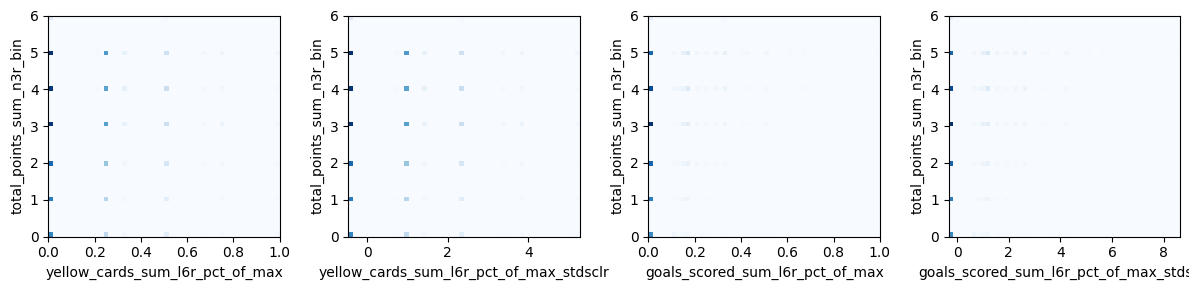

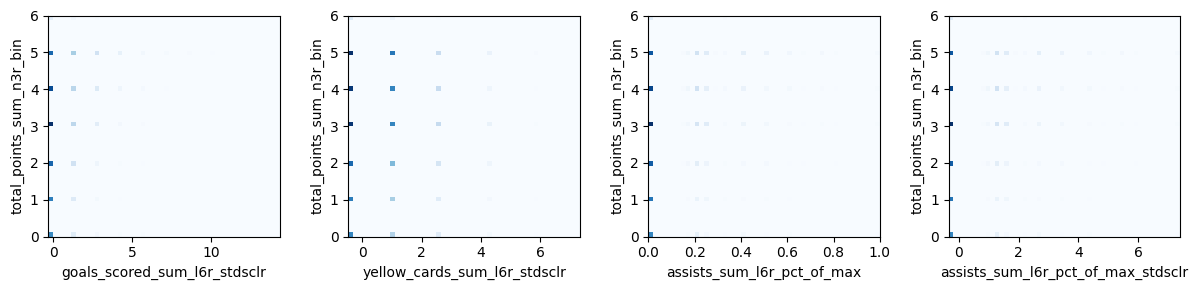

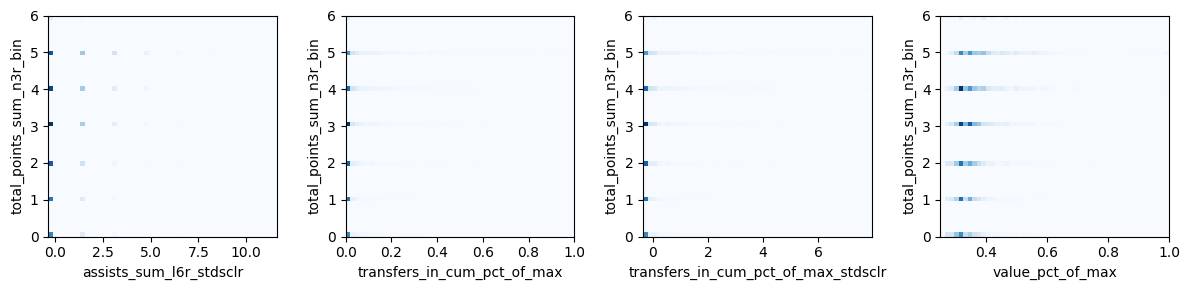

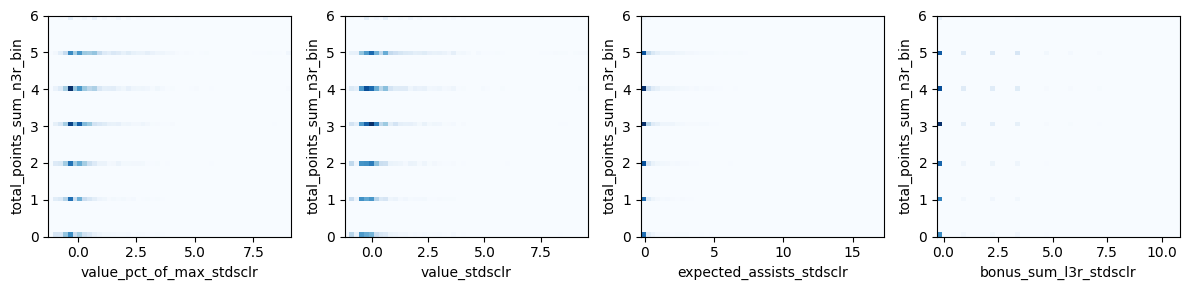

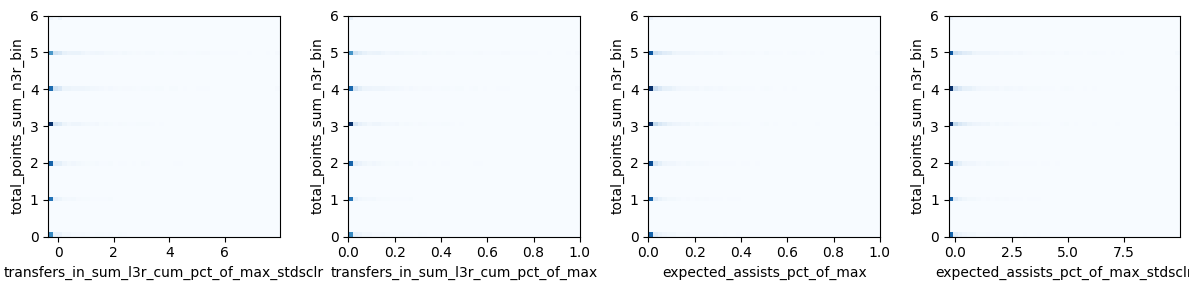

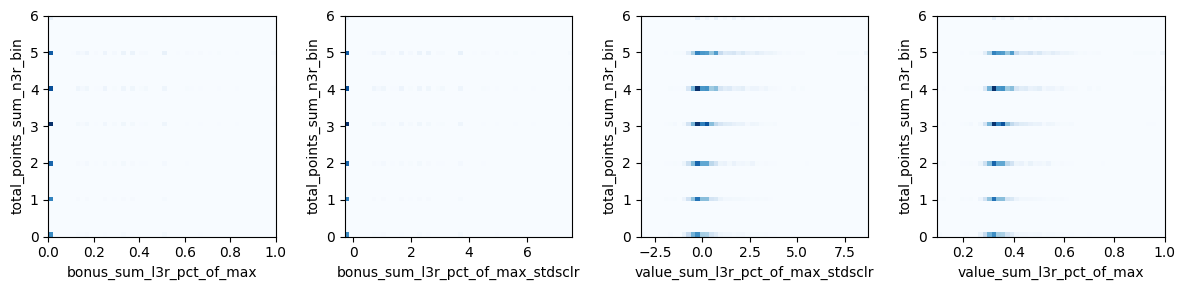

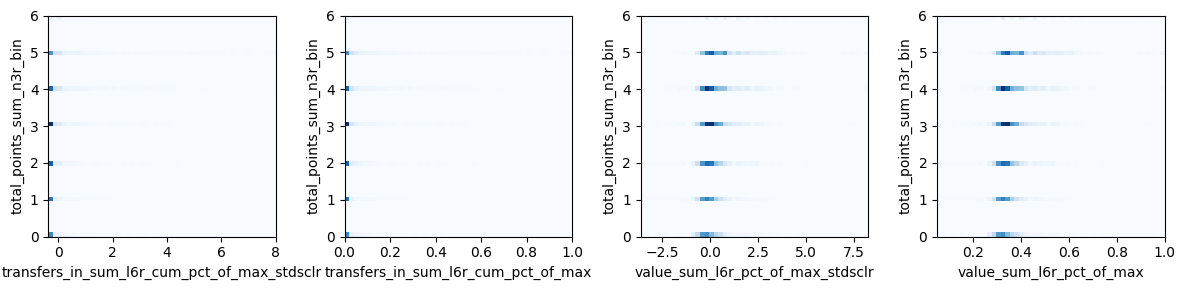

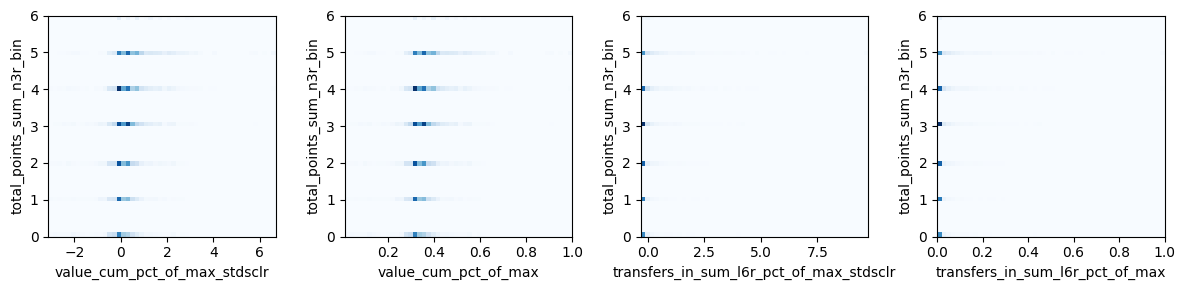

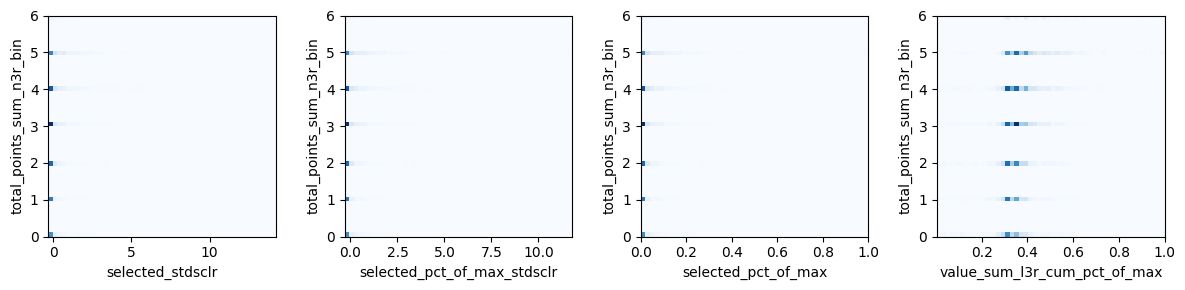

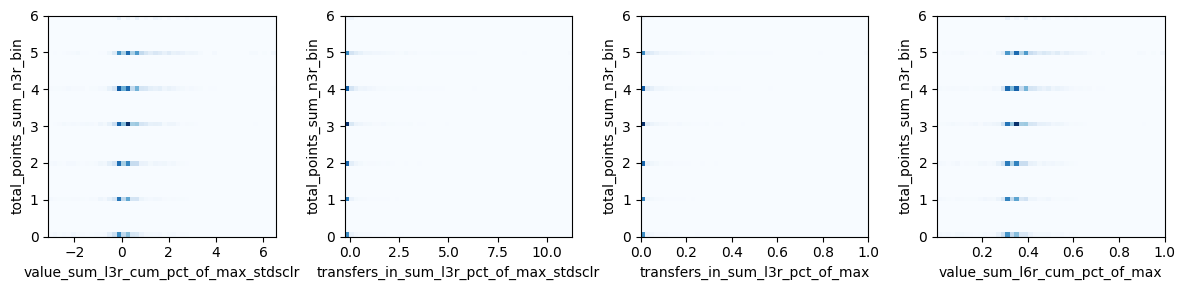

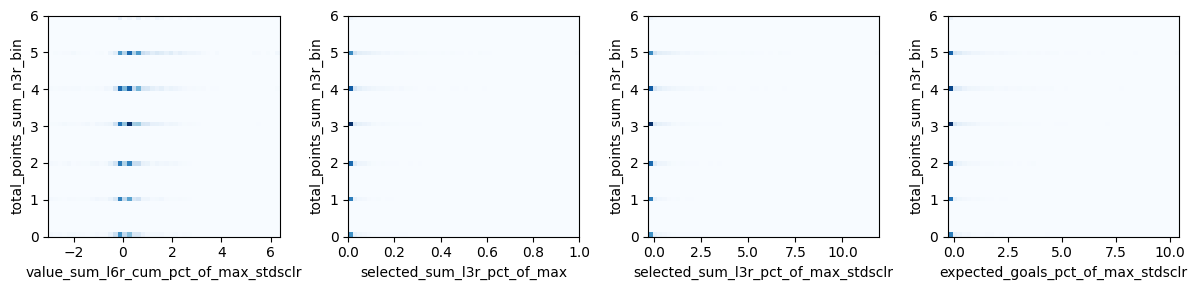

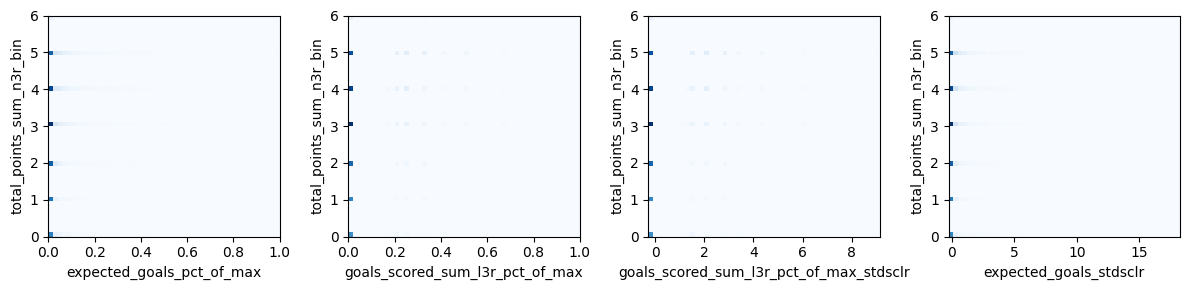

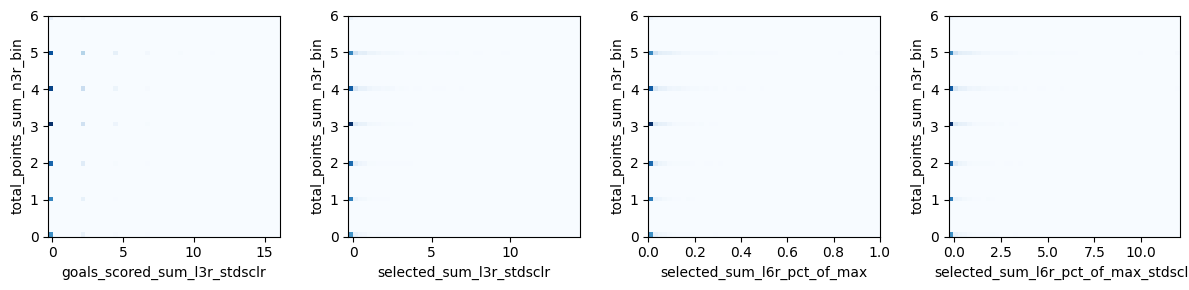

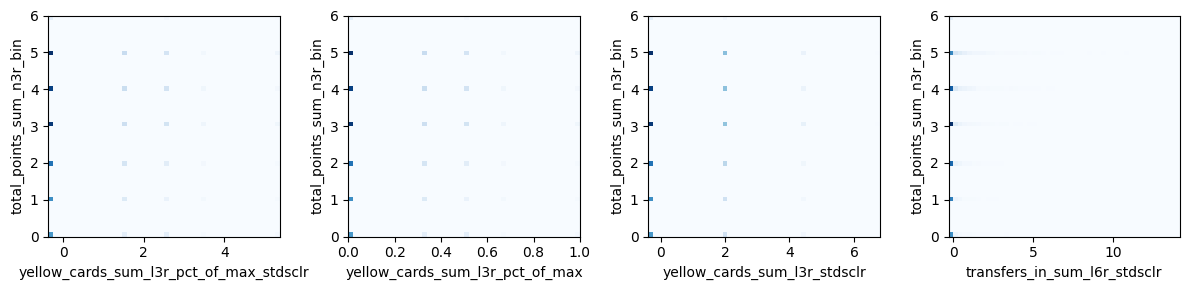

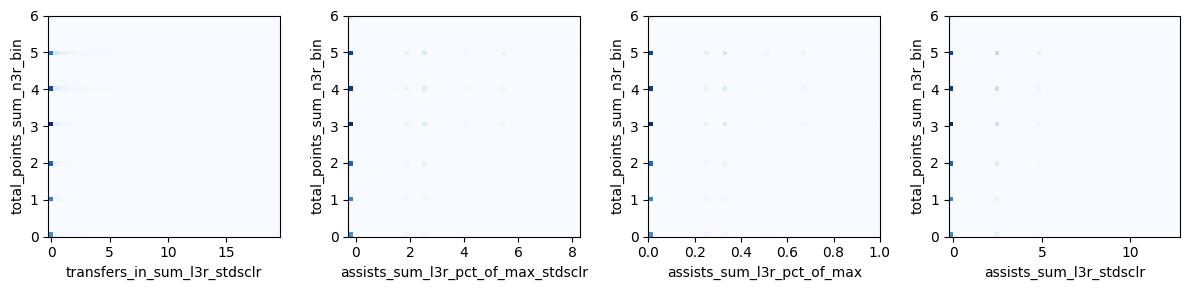

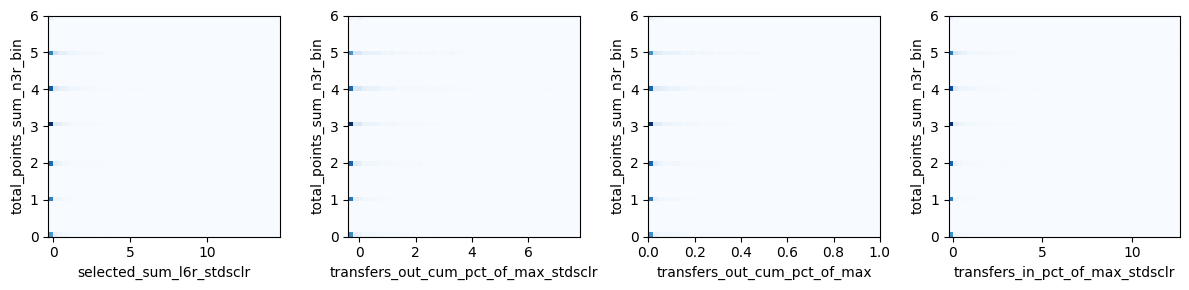

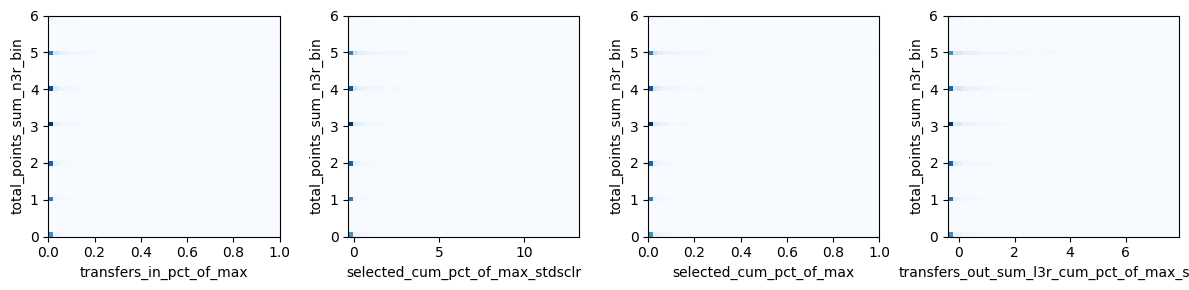

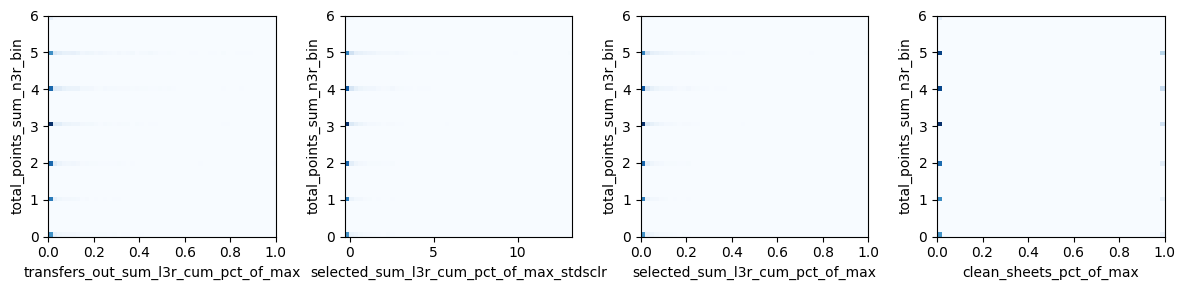

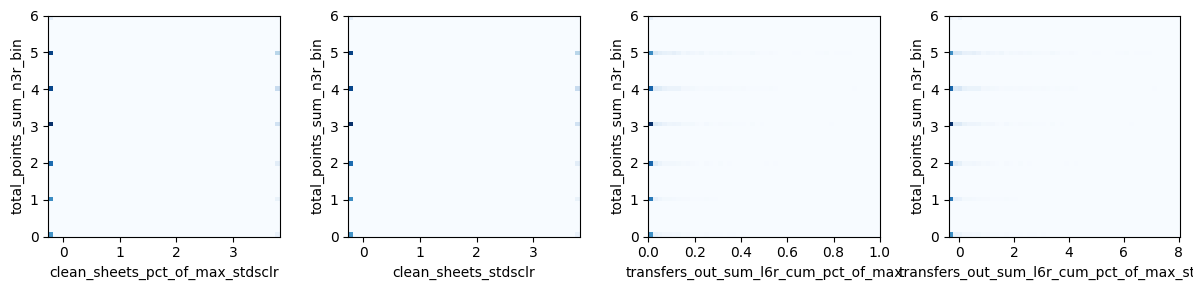

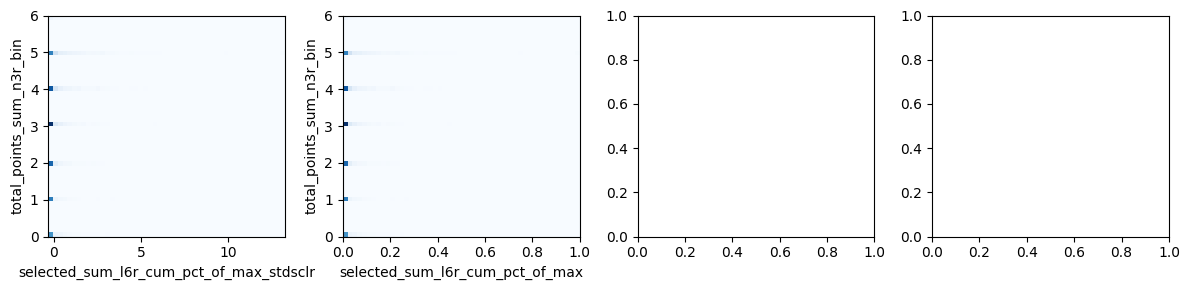

In [77]:
df_nonzero_minutes = df[df['minutes'] > 0.0]
# df_nonzero_minutes = df.copy()
df_nonzero_minutes.fillna(0.0, inplace=True)

plot_multi_hist2d(df_nonzero_minutes, target, normalised_features)

## Modelling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, accuracy_score, precision_score, recall_score
from lightgbm import LGBMRegressor, LGBMClassifier
from sklearn.preprocessing import StandardScaler

pd.options.display.max_columns = None

In [2]:
def train_lr_model(x_train, y_train, x_test, y_test, n_features_to_select=100, alpha=1.0, regression=False):

    # Initialize the linear regression model
    if regression:
        lr = Ridge(alpha=alpha)
    else:
        lr = LogisticRegression()

    lgb = LGBMClassifier(min_samples_leaf=50, 
                    verbose=-1)
    lgb.fit(x_train, y_train)

    # Get feature importances
    feature_names = x_train.columns.to_list()
    importance = lgb.feature_importances_
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importance})

    # Sort features by importance
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)
    print(feature_importances[:10])

    # Select top N important features
    selected_features = list(feature_importances.head(n_features_to_select)['feature'].values)

    print("Selected features:", selected_features)

    # Fit the linear regression model with selected features
    lr.fit(x_train[selected_features], y_train)

    # Evaluate the model
    train_preds = lr.predict(x_train[selected_features])
    test_preds = lr.predict(x_test[selected_features])

    if regression:
        r2_train = r2_score(y_train.values, train_preds)
        r2_test = r2_score(y_test.values, test_preds)

        print(f"Linear regression train r2: {r2_train:.2f}")
        print(f"Linear regression test r2: {r2_test:.2f}")
    else:
        acc_train = accuracy_score(y_train.values, train_preds)
        acc_test = accuracy_score(y_test.values, test_preds)

        print(f"Logistic regression train acccuracy: {acc_train:.2f}")
        print(f"Logistic regression test accuracy: {acc_test:.2f}")
    print('\n')

    return lr, selected_features


def train_lgbm_model(x_train, 
                     y_train, 
                     x_test, 
                     y_test,
                     min_samples_leaf=30,
                     learning_rate=0.05,
                     n_estimators=100,
                     num_iterations=1000,
                     n_top_features=100):
    
    lgb = LGBMRegressor(min_samples_leaf=min_samples_leaf, 
                        learning_rate=learning_rate, 
                        n_estimators=n_estimators, 
                        num_iterations=num_iterations, 
                        verbose=-1)
    lgb.fit(x_train, y_train)

    # Get feature importances
    feature_names = x_train.columns.to_list()
    importance = lgb.feature_importances_
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': importance})

    # Sort features by importance
    feature_importances = feature_importances.sort_values(by='importance', ascending=False)
    print(feature_importances[:10])

    # Select top N important features
    top_features = feature_importances.head(n_top_features)['feature'].values

    # Retrain model using only the top feature
    lgb.fit(x_train[top_features], y_train)

    train_preds = lgb.predict(x_train[top_features])
    test_preds = lgb.predict(x_test[top_features])

    # acc_train = accuracy_score(y_train.values, train_preds)
    # acc_test = accuracy_score(y_test.values, test_preds)

    r2_train = r2_score(y_train.values, train_preds)
    r2_test = r2_score(y_test.values, test_preds)

    print(f"Light GBM train r2: {r2_train:.2f}")
    print(f"Light GBM test r2: {r2_test:.2f}")

    # print(f"Light GBM train acccuracy: {acc_train:.2f}")
    # print(f"Light GBM test accuracy: {acc_test:.2f}")

    return lgb, top_features

def get_top_correlated_features(corr: pd.DataFrame, target: str, min_corr_threshold: float, max_corr_threshold: float) -> list:
    corr_target = corr[target].sort_values(ascending=False)
    top_corr = corr_target[abs(corr_target)>=min_corr_threshold]

    shortlisted_features = [feature for feature in top_corr.index if 'pct_of_max' in feature or '_stdsclr' in feature]
    # shortlisted_features = [feature for feature in top_corr.index if '_nr' not in feature and '_n3r' not in feature
                            # and '_n6r' not in feature and '_gw_forward' not in feature and 'total_points_sum_all' not in feature]

    feature_count = 0
    included_features = []

    for feature in shortlisted_features:
        if feature_count == 0:
            included_features.append(feature)
        else:
            feature_corr = corr[feature]
            max_corr = np.round(feature_corr[included_features].max(), 3)
            max_corr_idx = feature_corr[included_features].argmax()
            if abs(max_corr) > max_corr_threshold:
                print(f'WARNING! {feature} highly correlated with {included_features[max_corr_idx]} r = {max_corr}')
            else:
                included_features.append(feature)

        feature_count += 1

    print(f'N selected features: {len(included_features)}\'nTop 10 features: {included_features[:10]}')
    return included_features

def create_bins(group, target_in, target_out, n_bins=10):
    group[target_out] = pd.qcut(group[target_in], n_bins, labels=False, duplicates='drop')
    return group

In [3]:
# Config
MIN_CORR_THRESHOLD = 0.3
MAX_CORR_THRESHOLD = 0.8
N_FEATURES_TO_SELECT = 100
TEST_SIZE2 = 0.2
TEST_SIZE = 1 / (2 - TEST_SIZE2)
RANDOM_STATE = 42
RANDOM_STATE_MINUTES_MODEL = 21
RANDOM_STATE_POINTS_MODEL = 84
OTHER_FEATURES = ['position_code', 'def_flag', 'fwd_flag', 'gkp_flag', 'mid_flag']
DATASET_FNAME = 'modelling_data.csv'
DROP_FEATURES = ['Unnamed: 0']
HOLDOUT_ROUND = 24
HOLDOUT_RAND_CUTOFF = 0.3
N_BINS = 15
ALPHA=2.0

target_minutes_model = 'minutes_sum_n3r'
target_goals_model = 'goals_scored_sum_n3r'
target_assists_model = 'assists_sum_n3r'
target_clean_sheets_model = 'clean_sheets_sum_n3r'
target_goals_conceded_model = 'goals_conceded_sum_n3r'
target_saves_model = 'saves_sum_n3r'
target_points_model_in = 'total_points_sum_n3r'
target_points_model = 'total_points_sum_n3r'

In [4]:
# Load datasets
df = pd.read_csv(DATASET_FNAME)
df.drop(DROP_FEATURES, axis=1, inplace=True)
df.fillna(0.0, inplace=True)
df = df[df['round']<38]

# Create position flags
df['def_flag'] = np.where(df['position']=='DEF', 1, 0)
df['fwd_flag'] = np.where(df['position']=='FWD', 1, 0)
df['gkp_flag'] = np.where(df['position']=='GKP', 1, 0)
df['mid_flag'] = np.where(df['position']=='MID', 1, 0)

# df[target_points_model], edges = pd.qcut(df[target_points_model_in], N_BINS, labels=False, retbins=True, duplicates='drop')

df.head()

element  round  fixture team_name      player_name position  position_code  \
0        1      1        2   Arsenal  Folarin Balogun      FWD              4   
1        1      2       12   Arsenal  Folarin Balogun      FWD              4   
2        1      3       21   Arsenal  Folarin Balogun      FWD              4   
3        1      4       31   Arsenal  Folarin Balogun      FWD              4   
4        1      5       43   Arsenal  Folarin Balogun      FWD              4   

   team_code  avg_opp_difficulty_n3r_x  avg_difficulty_difference_n3r_x  \
0          3                  2.333333                         2.666667   
1          3                  2.333333                         2.666667   
2          3                  2.666667                         2.333333   
3          3                  2.333333                         2.666667   
4          3                  3.333333                         1.666667   

   opp_round_1  opp_round_2  opp_round_3  opp_round_4  opp_round_5  \
0          8.0         10.0         14.0          9.0         18.0   
1         10.0         14.0          9.0         18.0          3.0   
2         14.0          9.0         18.0          3.0         13.0   
3          9.0         18.0          3.0         13.0          7.0   
4         18.0          3.0         13.0          7.0         17.0   

   opp_round_6  total_points  value  transfers_balance  selected  \
0          3.0             0     45                  0     59090   
1         13.0             0     45              -4744     63768   
2          7.0             0     45              -7682     58109   
3         17.0             0     44              -9696     49814   
4         15.0             0     44             -12786     37048   

   transfers_in  transfers_out  ict_index  minutes  goals_scored  assists  \
0             0              0        0.0        0             0        0   
1          4959           9703        0.0        0             0        0   
2          2507          10189        0.0        0             0        0   
3          2558          12254        0.0        0             0        0   
4             0          12786        0.0        0             0        0   

   clean_sheets  goals_conceded  own_goals  penalties_saved  penalties_missed  \
0             0               0          0                0                 0   
1             0               0          0                0                 0   
2             0               0          0                0                 0   
3             0               0          0                0                 0   
4             0               0          0                0                 0   

   yellow_cards  red_cards  saves  bonus  bps  influence  creativity  threat  \
0             0          0      0      0    0        0.0         0.0     0.0   
1             0          0      0      0    0        0.0         0.0     0.0   
2             0          0      0      0    0        0.0         0.0     0.0   
3             0          0      0      0    0        0.0         0.0     0.0   
4             0          0      0      0    0        0.0         0.0     0.0   

   was_home  starts  expected_goals  expected_assists  \
0         1       0             0.0               0.0   
1         0       0             0.0               0.0   
2         1       0             0.0               0.0   
3         1       0             0.0               0.0   
4         0       0             0.0               0.0   

   expected_goal_involvements  expected_goals_conceded  total_points_sum_l3r  \
0                         0.0                      0.0                   0.0   
1                         0.0                      0.0                   1.0   
2                         0.0                      0.0                   1.0   
3                         0.0                      0.0                   0.0   
4                         0.0                      0.0       

In [5]:
df[target_points_model_in].describe(percentiles=[0.01, 0.05, 0.95, 0.99])

count    30826.000000
mean         3.068287
std          5.238132
min         -4.000000
1%           0.000000
5%           0.000000
50%          0.000000
95%         15.000000
99%         22.000000
max         51.000000
Name: total_points_sum_n3r, dtype: float64

In [94]:
bin_edges = [-np.inf, 0, 5, 10, 15, 20, 25, 30, np.inf]

# Bin the data using pd.cut
df[target_points_model] = pd.cut(df[target_points_model_in], bins=bin_edges, labels=False)

bin_volumes = df[target_points_model].value_counts().sort_index()

print(bin_volumes)

print(df[df[target_points_model_in]>0.0][[target_points_model_in, target_points_model]])

0    16825
1     7434
2     3534
3     1735
4      833
5      296
6      116
7       53
Name: total_points_sum_n3r_bin, dtype: int64


In [6]:
# Create the correlation matrix
numeric_df = df.select_dtypes(include=[int, float])
corr = numeric_df.corr()

In [7]:
# Get the top correlated features and create shoertlists
shortlisted_features_mins = get_top_correlated_features(corr, target_minutes_model, MIN_CORR_THRESHOLD, MAX_CORR_THRESHOLD)
shortlisted_features_goals = get_top_correlated_features(corr, target_goals_model, MIN_CORR_THRESHOLD, MAX_CORR_THRESHOLD)
shortlisted_features_assists = get_top_correlated_features(corr, target_assists_model, MIN_CORR_THRESHOLD, MAX_CORR_THRESHOLD)
shortlisted_features_clean_sheets = get_top_correlated_features(corr, target_clean_sheets_model, MIN_CORR_THRESHOLD, MAX_CORR_THRESHOLD)
shortlisted_features_goals_conceded = get_top_correlated_features(corr, target_goals_conceded_model, MIN_CORR_THRESHOLD, MAX_CORR_THRESHOLD)
shortlisted_features_saves = get_top_correlated_features(corr, target_saves_model, MIN_CORR_THRESHOLD, MAX_CORR_THRESHOLD)
shortlisted_features_points = get_top_correlated_features(corr, target_points_model, MIN_CORR_THRESHOLD, MAX_CORR_THRESHOLD)

WARNING! minutes_stdsclr highly correlated with minutes_pct_of_max_stdsclr r = 1.0
WARNING! minutes_pct_of_max highly correlated with minutes_pct_of_max_stdsclr r = 1.0
WARNING! starts_pct_of_max highly correlated with minutes_pct_of_max_stdsclr r = 0.965
WARNING! starts_pct_of_max_stdsclr highly correlated with minutes_pct_of_max_stdsclr r = 0.965
WARNING! starts_stdsclr highly correlated with minutes_pct_of_max_stdsclr r = 0.965
WARNING! minutes_cum_pct_of_max_stdsclr highly correlated with minutes_cum_pct_of_max r = 1.0
WARNING! influence_cum_pct_of_max highly correlated with minutes_cum_pct_of_max r = 0.931
WARNING! influence_cum_pct_of_max_stdsclr highly correlated with minutes_cum_pct_of_max r = 0.931
WARNING! bps_cum_pct_of_max highly correlated with minutes_cum_pct_of_max r = 0.953
WARNING! bps_cum_pct_of_max_stdsclr highly correlated with minutes_cum_pct_of_max r = 0.953
WARNING! starts_cum_pct_of_max highly correlated with minutes_cum_pct_of_max r = 0.994
WARNING! starts_cum_

#### Dataset design


In [8]:
targets = [target_minutes_model, 
           target_goals_model, 
           target_assists_model, 
           target_clean_sheets_model, 
           target_goals_conceded_model,
           target_saves_model,
           target_points_model]

combined_feature_list = list(set(shortlisted_features_mins + shortlisted_features_goals + shortlisted_features_assists + shortlisted_features_clean_sheets \
                                 + shortlisted_features_goals_conceded + shortlisted_features_saves + shortlisted_features_points + OTHER_FEATURES))
print(f'number of combined features: {len(combined_feature_list)}')

# Generate player level random numbers
player_ids = df['element'].unique()
player_random_numbers = {player_id: np.random.rand() for player_id in player_ids}
player_random_numbers_df = pd.DataFrame(list(player_random_numbers.items()), columns=['element', 'rand'])

# Merge the original DataFrame with the random number DataFrame
df = pd.merge(df, player_random_numbers_df, on='element', how='left')

# Create the datasets
df['train_holdout'] = np.where(df['rand'] > HOLDOUT_RAND_CUTOFF, 'train', 'holdout')
df_train = df[df['train_holdout'] == 'train']
df_holdout = df[df['train_holdout'] == 'holdout']

x = df_train[combined_feature_list]
y = df_train[targets]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=TEST_SIZE, random_state=RANDOM_STATE)

x_train_comp, x_test_comp, y_train_comp, y_test_comp = train_test_split(x_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_STATE_MINUTES_MODEL)
x_train_points, x_test_points, y_train_points, y_test_points = train_test_split(x_test_comp, y_test_comp, test_size=TEST_SIZE2, random_state=RANDOM_STATE_POINTS_MODEL)

# Create holdout sets
x_holdout = df_holdout[combined_feature_list]
y_holdout = df_holdout[targets]

print(f'x_train shape: {x_train.shape}, y_train shape: {y_train.shape}')
print(f'x_test shape: {x_test.shape}, y_test shape: {y_test.shape}')
print(f'x_train_comp shape: {x_train_comp.shape}, y_train_comp shape: {y_train_comp.shape}')
print(f'x_test_comp shape: {x_test_comp.shape}, y_test_comp shape: {y_test_comp.shape}')
print(f'x_train_points shape: {x_train_points.shape}, y_train_points shape: {y_train_points.shape}')
print(f'x_test_points shape: {x_test_points.shape}, y_test_points shape: {y_test_points.shape}')
print(f'x_holdout_points shape: {x_holdout.shape}, y_holdout_points shape: {y_holdout.shape}')

number of combined features: 41
x_train shape: (9232, 41), y_train shape: (9232, 7)
x_test shape: (11542, 41), y_test shape: (11542, 7)
x_train_comp shape: (4103, 41), y_train_comp shape: (4103, 7)
x_test_comp shape: (5129, 41), y_test_comp shape: (5129, 7)
x_train_points shape: (4103, 41), y_train_points shape: (4103, 7)
x_test_points shape: (1026, 41), y_test_points shape: (1026, 7)
x_holdout_points shape: (10052, 41), y_holdout_points shape: (10052, 7)


In [9]:
y_train['total_points_sum_n3r'].describe(percentiles=[0.01, 0.05, 0.95, 0.99])

count    9232.000000
mean        3.127275
std         5.364692
min        -4.000000
1%          0.000000
5%          0.000000
50%         0.000000
95%        15.000000
99%        23.000000
max        48.000000
Name: total_points_sum_n3r, dtype: float64

### Composite Models

In [10]:
print('Training Minutes Model')
y_train_mins = y_train_comp[target_minutes_model]
y_test_mins = y_test_comp[target_minutes_model]
lr_mins, lr_mins_features = train_lr_model(x_train_comp, y_train_mins, x_test_comp, y_test_mins, n_features_to_select=N_FEATURES_TO_SELECT, alpha=ALPHA,
                                           regression=True)

# Add minutes preditions to other models
x_train_comp['minutes_pred'] = lr_mins.predict(x_train_comp[lr_mins_features])
x_test_comp['minutes_pred'] = lr_mins.predict(x_test_comp[lr_mins_features])

print('Training Goals Model')
y_train_goals = y_train_comp[target_goals_model]
y_test_goals = y_test_comp[target_goals_model]
lr_goals, lr_goals_features = train_lr_model(x_train_comp, y_train_goals, x_test_comp, y_test_goals, n_features_to_select=N_FEATURES_TO_SELECT, alpha=ALPHA,
                                           regression=True)

print('Training Assists Model')
y_train_assists = y_train_comp[target_assists_model]
y_test_assists = y_test_comp[target_assists_model]
lr_assists, lr_assists_features = train_lr_model(x_train_comp, y_train_assists, x_test_comp, y_test_assists, n_features_to_select=N_FEATURES_TO_SELECT, alpha=ALPHA,
                                           regression=True)

print('Training Clean Sheets Model')
y_train_clean_sheets = y_train_comp[target_clean_sheets_model]
y_test_clean_sheets = y_test_comp[target_clean_sheets_model]
lr_clean_sheets, lr_clean_sheets_features = train_lr_model(x_train_comp, y_train_clean_sheets, x_test_comp, y_test_clean_sheets, n_features_to_select=N_FEATURES_TO_SELECT, alpha=ALPHA,
                                           regression=True)

print('Training Goals Conceded Model')
y_train_goals_conceded = y_train_comp[target_goals_conceded_model]
y_test_goals_conceded = y_test_comp[target_goals_conceded_model]
lr_goals_conceded, lr_goals_conceded_features = train_lr_model(x_train_comp, y_train_goals_conceded, x_test_comp, y_test_goals_conceded, n_features_to_select=N_FEATURES_TO_SELECT, alpha=ALPHA,
                                           regression=True)
print('Training Saves Model')
y_train_saves = y_train_comp[target_saves_model]
y_test_saves = y_test_comp[target_saves_model]
lr_saves, lr_saves_features = train_lr_model(x_train_comp, y_train_saves, x_test_comp, y_test_saves, n_features_to_select=N_FEATURES_TO_SELECT, alpha=ALPHA,
                                           regression=True)

Training Minutes Model
                                              feature  importance
9                     transfers_in_pct_of_max_stdsclr       44099
13                                selected_pct_of_max       23264
12             expected_goals_conceded_cum_pct_of_max       22616
39                                      value_stdsclr       22226
6                         transfers_in_cum_pct_of_max       21164
33                             minutes_cum_pct_of_max       20762
26                                   selected_stdsclr       20535
10                      threat_cum_pct_of_max_stdsclr       19180
31                        yellow_cards_cum_pct_of_max       18268
21  expected_goal_involvements_cum_pct_of_max_stdsclr       17641
Selected features: ['transfers_in_pct_of_max_stdsclr', 'selected_pct_of_max', 'expected_goals_conceded_cum_pct_of_max', 'value_stdsclr', 'transfers_in_cum_pct_of_max', 'minutes_cum_pct_of_max', 'selected_stdsclr', 'threat_cum_pct_of_max_stdsclr', 'yel

#### Check minutes model

/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


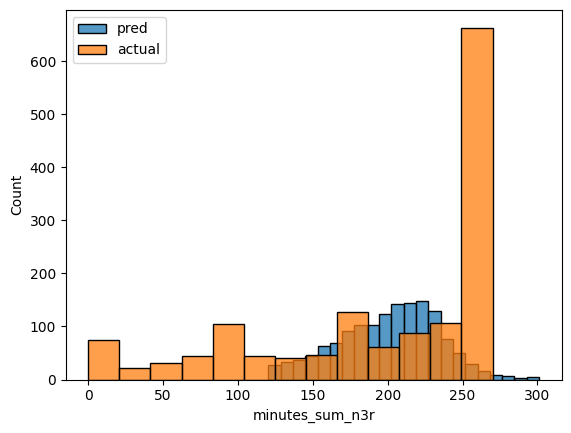

In [11]:
mins_preds= lr_mins.predict(x_test_comp[lr_mins_features])
mins_preds

# sns.histplot(y_test_mins[mins_preds < 1.0])
sns.histplot(mins_preds[mins_preds >= 120.0], label='pred')
sns.histplot(y_test_mins[mins_preds >= 120.0], label='actual')
plt.legend()
plt.show()

### Points Model

In [12]:
y_train_points = y_train_points[target_points_model]
y_test_points = y_test_points[target_points_model]

lr_points, lr_points_features = train_lr_model(x_train_points, y_train_points, x_test_points, y_test_points, n_features_to_select=N_FEATURES_TO_SELECT, alpha=ALPHA,
                                               regression=True)
lgb_points, lgb_points_features = train_lgbm_model(x_train_points, y_train_points, x_test_points, y_test_points, min_samples_leaf=50, learning_rate=0.05, 
                        n_estimators=100, num_iterations=100, n_top_features=N_FEATURES_TO_SELECT)

                                   feature  importance
9          transfers_in_pct_of_max_stdsclr        8481
39                           value_stdsclr        4319
33                  minutes_cum_pct_of_max        4199
13                     selected_pct_of_max        4041
12  expected_goals_conceded_cum_pct_of_max        4007
26                        selected_stdsclr        3889
29             total_points_cum_pct_of_max        3585
24         expected_goals_conceded_stdsclr        3558
20               creativity_cum_pct_of_max        3476
14                       ict_index_stdsclr        3462
Selected features: ['transfers_in_pct_of_max_stdsclr', 'value_stdsclr', 'minutes_cum_pct_of_max', 'selected_pct_of_max', 'expected_goals_conceded_cum_pct_of_max', 'selected_stdsclr', 'total_points_cum_pct_of_max', 'expected_goals_conceded_stdsclr', 'creativity_cum_pct_of_max', 'ict_index_stdsclr', 'transfers_in_cum_pct_of_max', 'yellow_cards_cum_pct_of_max', 'expected_goals_conceded_pct_of_ma

/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


                                              feature  importance
9                     transfers_in_pct_of_max_stdsclr         270
39                                      value_stdsclr         155
20                          creativity_cum_pct_of_max         147
29                        total_points_cum_pct_of_max         139
26                                   selected_stdsclr         129
7                                  creativity_stdsclr         122
32         expected_goals_conceded_pct_of_max_stdsclr         120
21  expected_goal_involvements_cum_pct_of_max_stdsclr         119
6                         transfers_in_cum_pct_of_max         119
10                      threat_cum_pct_of_max_stdsclr         119


/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Light GBM train r2: 0.72
Light GBM test r2: 0.51


#### Train model with composite model predictions

In [13]:
# Add minutes predictions to data frames - use LR as it's just as good, and probably simpler
x_train_points['minutes_pred'] = lr_mins.predict(x_train_points[lr_mins_features])
x_test_points['minutes_pred'] = lr_mins.predict(x_test_points[lr_mins_features])
x_test['minutes_pred'] = lr_mins.predict(x_test[lr_mins_features])

x_train_points['goals_pred'] = lr_goals.predict(x_train_points[lr_goals_features])
x_test_points['goals_pred'] = lr_goals.predict(x_test_points[lr_goals_features])
x_test['goals_pred'] = lr_goals.predict(x_test[lr_goals_features])

x_train_points['assists_pred'] = lr_assists.predict(x_train_points[lr_assists_features])
x_test_points['assists_pred'] = lr_assists.predict(x_test_points[lr_assists_features])
x_test['assists_pred'] = lr_assists.predict(x_test[lr_assists_features])

x_train_points['clean_sheets_pred'] = lr_clean_sheets.predict(x_train_points[lr_clean_sheets_features])
x_test_points['clean_sheets_pred'] = lr_clean_sheets.predict(x_test_points[lr_clean_sheets_features])
x_test['clean_sheets_pred'] = lr_clean_sheets.predict(x_test[lr_clean_sheets_features])

x_train_points['goals_conceded_pred'] = lr_goals_conceded.predict(x_train_points[lr_goals_conceded_features])
x_test_points['goals_conceded_pred'] = lr_goals_conceded.predict(x_test_points[lr_goals_conceded_features])
x_test['goals_conceded_pred'] = lr_goals_conceded.predict(x_test[lr_goals_conceded_features])

x_train_points['saves_pred'] = lr_saves.predict(x_train_points[lr_saves_features])
x_test_points['saves_pred'] = lr_saves.predict(x_test_points[lr_saves_features])
x_test['saves_pred'] = lr_saves.predict(x_test[lr_saves_features])

x_test_points.head()

goals_conceded_pct_of_max  saves_stdsclr  total_points_stdsclr  \
474                          0.0      -0.135427              1.721416   
12456                        0.0      -0.135427             -0.458740   
872                          0.0      -0.135427             -0.458740   
25302                        0.0      -0.135427             -0.458740   
30563                        0.0      -0.135427             -0.458740   

       expected_assists_stdsclr  \
474                    0.652895   
12456                 -0.302101   
872                   -0.302101   
25302                 -0.302101   
30563                 -0.302101   

       expected_goal_involvements_pct_of_max_stdsclr  assists_cum_pct_of_max  \
474                                         0.662402                0.333333   
12456                                      -0.342117                0.125000   
872                                        -0.342117                0.000000   
25302                                      -0.342117                0.000000   
30563                                      -0.342117                0.000000   

       transfers_in_cum_pct_of_max  creativity_stdsclr  \
474                       0.193167           -0.084258   
12456                     0.006738           -0.390411   
872                       0.004961           -0.390411   
25302                     0.000988           -0.390411   
30563                     0.000050           -0.390411   

       bonus_cum_pct_of_max_stdsclr  transfers_in_pct_of_max_stdsclr  \
474                        0.644651                         0.507531   
12456                     -0.488759                        -0.238517   
872                       -0.488759                        -0.238712   
25302                     -0.488759                        -0.238238   
30563                     -0.488759                        -0.238853   

       threat_cum_pct_of_max_stdsclr  minutes_pct_of_max_stdsclr  \
474                         2.039002                    1.142304   
12456                       0.096512                   -0.672016   
872                        -0.501892                   -0.672016   
25302                      -0.400098                   -0.672016   
30563                      -0.527324                   -0.672016   

       expected_goals_conceded_cum_pct_of_max  selected_pct_of_max  \
474                                  0.146369             0.060818   
12456                                0.446901             0.001967   
872                                  0.060892             0.003315   
25302                                0.021558             0.000525   
30563                                0.000000             0.000071   

       ict_index_stdsclr  mid_flag  threat_stdsclr  \
474             0.254727         0        1.046961   
12456          -0.497942         0       -0.357478   
872            -0.497942         0       -0.357478   
25302          -0.497942         0       -0.357478   
30563          -0.497942         0       -0.357478   

       assists_cum_pct_of_max_stdsclr  gkp_flag  clean_sheets_stdsclr  \
474                          2.181085         0              3.823483   
12456                        0.541944         0             -0.261542   
872                         -0.441541         0             -0.261542   
25302                       -0.441541         0             -0.261542   
30563                       -0.441541         0             -0.261542   

       creativity_cum_pct_of_max  \
474                     0.212847   
12456                   0.149544   
872                     0.015107   
25302                   0.004672   
30563                   0.000000   

       expected_goal_involvements_cum_pct_of_max_stdsclr  fwd_flag  \
474                                             1.533835         1   
12456                                          -0.135544         0   
872                                            -0.502216         0   
253

In [14]:
x_train_points_mins_gt = x_train_points[x_train_points['minutes_pred'] > 120.0]
x_test_points_mins_gt = x_test_points[x_test_points['minutes_pred'] > 120.0]

y_train_points_mins_gt = y_train_points[x_train_points_mins_gt.index]
y_test_points_mins_gt = y_test_points[x_test_points_mins_gt.index]


print(f'x_train minimum minutes shape: {x_train_points_mins_gt.shape}')
print(f'y_train minimum minutes shape: {y_train_points_mins_gt.shape}')
print(f'x_test minimum minutes shape: {x_test_points_mins_gt.shape}')
print(f'y_test minimum minutes shape: {y_test_points_mins_gt.shape}')


x_train minimum minutes shape: (1169, 47)
y_train minimum minutes shape: (1169,)
x_test minimum minutes shape: (285, 47)
y_test minimum minutes shape: (285,)


In [15]:
lr_points, lr_points_features = train_lr_model(x_train_points, y_train_points, 
                                               x_test_points, y_test_points, 
                                               n_features_to_select=N_FEATURES_TO_SELECT, alpha=ALPHA, regression=True)
lgb_points, lgb_points_features = train_lgbm_model(x_train_points, y_train_points, 
                                                x_test_points, y_test_points, min_samples_leaf=50, learning_rate=0.05, 
                                                n_estimators=100, num_iterations=100, n_top_features=N_FEATURES_TO_SELECT)

                            feature  importance
9   transfers_in_pct_of_max_stdsclr        6599
44                clean_sheets_pred        4750
46                       saves_pred        4478
43                     assists_pred        4352
41                     minutes_pred        4173
42                       goals_pred        4135
45              goals_conceded_pred        3334
13              selected_pct_of_max        3148
26                 selected_stdsclr        3092
33           minutes_cum_pct_of_max        2954
Selected features: ['transfers_in_pct_of_max_stdsclr', 'clean_sheets_pred', 'saves_pred', 'assists_pred', 'minutes_pred', 'goals_pred', 'goals_conceded_pred', 'selected_pct_of_max', 'selected_stdsclr', 'minutes_cum_pct_of_max', 'expected_goals_conceded_pct_of_max_stdsclr', 'ict_index_stdsclr', 'expected_goals_conceded_stdsclr', 'transfers_in_cum_pct_of_max', 'value_stdsclr', 'total_points_cum_pct_of_max', 'expected_goal_involvements_pct_of_max_stdsclr', 'threat_cum_pc

/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


                            feature  importance
9   transfers_in_pct_of_max_stdsclr         216
44                clean_sheets_pred         196
43                     assists_pred         149
42                       goals_pred         134
46                       saves_pred         133
41                     minutes_pred         131
20        creativity_cum_pct_of_max         112
29      total_points_cum_pct_of_max         107
26                 selected_stdsclr         101
7                creativity_stdsclr          97


/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/lightgbm/engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Light GBM train r2: 0.73
Light GBM test r2: 0.51


/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


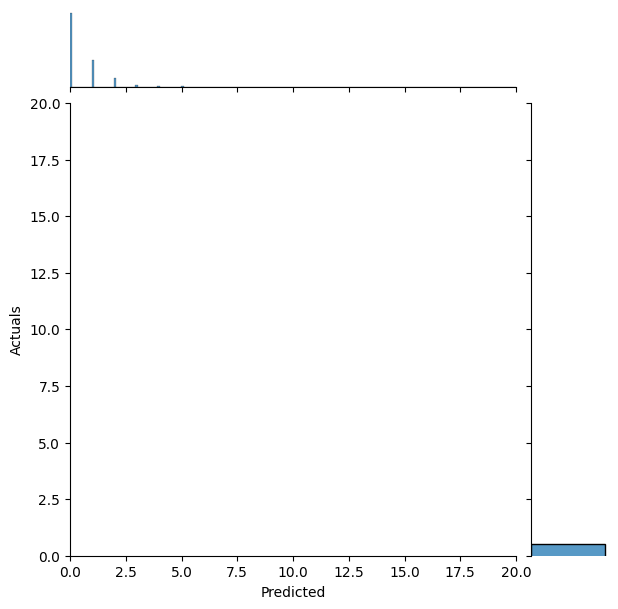

/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


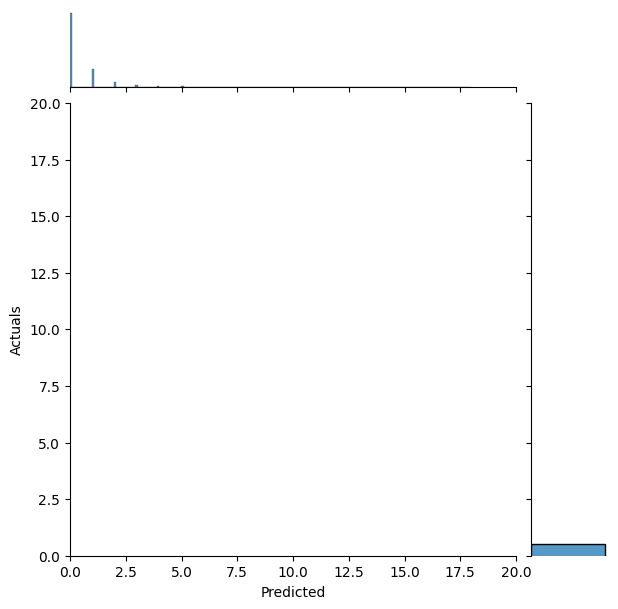

/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


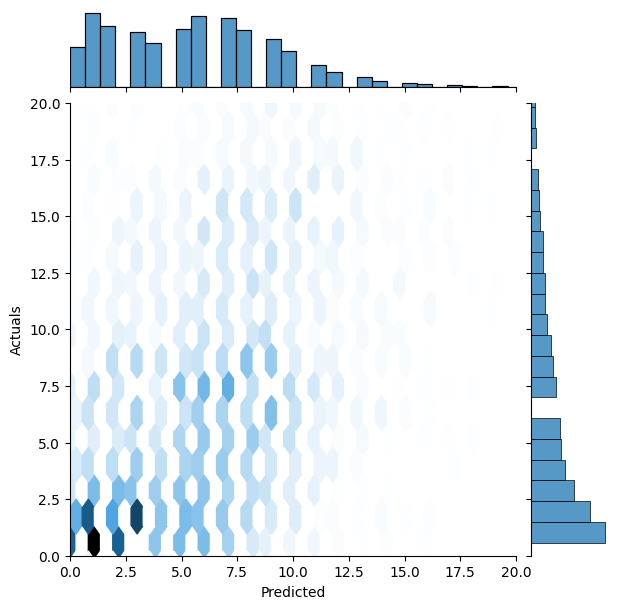

/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


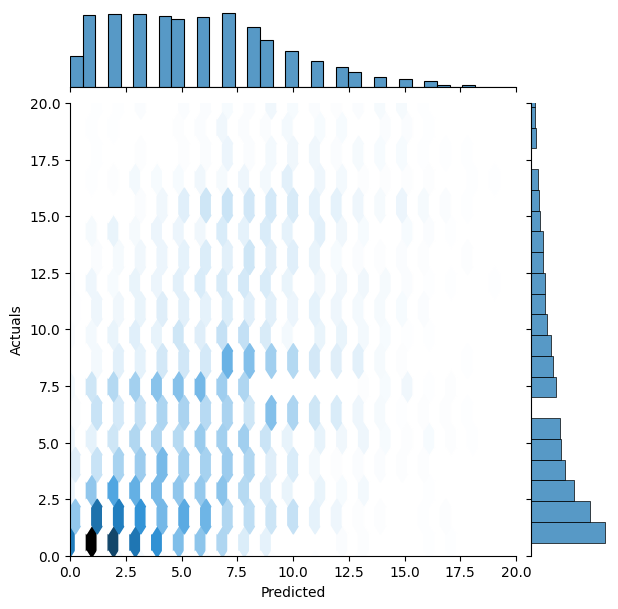

In [16]:
# Plot predictions vs actuals
test_preds_lr = np.round(lr_points.predict(x_test[lr_points_features]), 0)
test_preds_lgb = np.round(lgb_points.predict(x_test[lgb_points_features]), 0)

zero_indices = np.where(y_test[target_points_model]==0.0)[0]
nonzero_indices = np.where(y_test[target_points_model]!=0.0)[0]
test_preds_lgb[zero_indices]

sns.jointplot(x=test_preds_lr[zero_indices], y=y_test[target_points_model].values[zero_indices], kind="hex")
# cb = plt.colorbar(label='count in bin')
plt.xlabel('Predicted')
plt.ylabel('Actuals')
plt.xlim([0.0, 20.0])
plt.ylim([0.0, 20.0])
plt.show()

sns.jointplot(x=test_preds_lgb[zero_indices], y=y_test[target_points_model].values[zero_indices], kind="hex")
# plt.scatter(test_preds_lgb, y_test)
plt.xlabel('Predicted')
plt.ylabel('Actuals')
plt.xlim([0.0, 20.0])
plt.ylim([0.0, 20.0])
plt.show()

sns.jointplot(x=test_preds_lr[nonzero_indices], y=y_test[target_points_model].values[nonzero_indices], kind="hex")
# cb = plt.colorbar(label='count in bin')
plt.xlabel('Predicted')
plt.ylabel('Actuals')
plt.xlim([0.0, 20.0])
plt.ylim([0.0, 20.0])
plt.show()

sns.jointplot(x=test_preds_lgb[nonzero_indices], y=y_test[target_points_model].values[nonzero_indices], kind="hex")
# plt.scatter(test_preds_lgb, y_test)
plt.xlabel('Predicted')
plt.ylabel('Actuals')
plt.xlim([0.0, 20.0])
plt.ylim([0.0, 20.0])
plt.show()

### Efficient Frontier

In [17]:
df_preds = df.copy()
df_preds = df_preds[df_preds['round']==6]
df_preds['minutes_pred'] = lr_mins.predict(df_preds[lr_mins_features])
df_preds['goals_pred'] = lr_goals.predict(df_preds[lr_goals_features])
df_preds['assists_pred'] = lr_assists.predict(df_preds[lr_assists_features])
df_preds['clean_sheets_pred'] = lr_clean_sheets.predict(df_preds[lr_clean_sheets_features])
df_preds['goals_conceded_pred'] = lr_goals_conceded.predict(df_preds[lr_goals_conceded_features])
df_preds['saves_pred'] = lr_saves.predict(df_preds[lr_saves_features])
df_preds['points_pred'] = lgb_points.predict(df_preds[lgb_points_features])

df_preds.sort_values('value', inplace=True)


    value  points_pred  cumulative_max
0      39     2.794399        2.794399
1      40     2.033366        2.794399
2      41     6.834115        6.834115
3      42     2.205011        6.834115
4      43     4.923916        6.834115
5      44     3.998565        6.834115
6      45     7.760093        7.760093
7      46    11.207967       11.207967
8      47     9.796857       11.207967
9      48     6.696032       11.207967
10     49     7.109421       11.207967
11     50     7.506015       11.207967
12     51     9.981209       11.207967
13     52     9.818355       11.207967
14     53     5.829030       11.207967
15     54     7.903093       11.207967
16     55    11.167211       11.207967
17     56    11.678846       11.678846
18     57     5.967122       11.678846
19     58     6.208602       11.678846
20     59     9.912311       11.678846
21     60     9.747938       11.678846
22     61    11.656063       11.678846
23     62     8.174041       11.678846
24     63    12.053617   

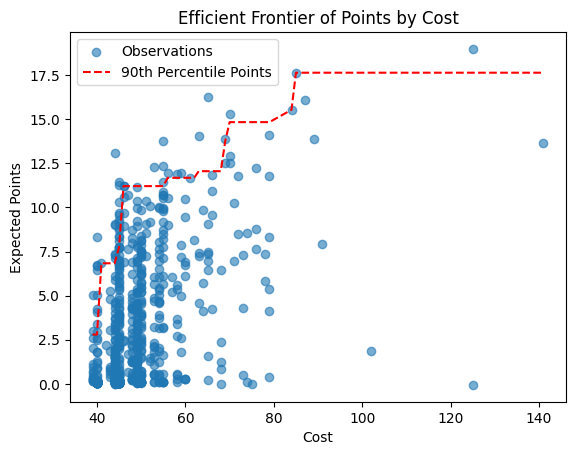

In [18]:
# Create a DataFrame
# data = pd.DataFrame({'value': cost, 'points': points})

# Compute the 95th percentile of points for each unique cost
percentile_90 = df_preds.groupby('value')['points_pred'].quantile(0.90).reset_index()

# Sort by cost to ensure proper cumulative maximum calculation
percentile_90 = percentile_90.sort_values(by='value')

# Compute the cumulative maximum of the 95th percentile points
percentile_90['cumulative_max'] = percentile_90['points_pred'].cummax()

# Print the results
print(percentile_90)

# Plot the data points
plt.scatter(df_preds['value'], df_preds['points_pred'], label="Observations", alpha=0.6)

# Plot the 95th percentile points
plt.plot(percentile_90['value'], percentile_90['cumulative_max'], color='red', marker=None, linestyle='--', label="90th Percentile Points")

plt.xlabel('Cost')
plt.ylabel('Expected Points')
plt.title('Efficient Frontier of Points by Cost')
plt.legend()
plt.show()

In [19]:
# Compute the 95th percentile of points for each unique cost
QUANTILE = 0.95
percentiles_90 = df_preds.groupby(['position', 'value'])['points_pred'].quantile(QUANTILE).reset_index()
percentiles_90.columns = ['position', 'value', '90th_percentile']

# Merge the percentiles back with the original data
data_with_percentiles = pd.merge(df_preds, percentiles_90, on=['position', 'value'])

# Filter the DataFrame to keep only rows where points are above the 95th percentile
filtered_data = data_with_percentiles[data_with_percentiles['points_pred'] > data_with_percentiles['90th_percentile']]

# Drop the auxiliary percentile column (optional)
filtered_data = filtered_data.drop(columns=['90th_percentile'])
filtered_data['position'].value_counts()

position
MID    29
DEF    20
FWD    15
GKP    10
Name: count, dtype: int64

In [20]:
filtered_data[filtered_data['position']=='MID'][['player_name', 'position', 'value', 'points_pred']]

player_name position  value  points_pred
165                     Elliot Anderson      MID     44     9.068214
182                        James McAtee      MID     44     6.126955
189                     Hannibal Mejbri      MID     44     5.902756
247                         Luke Harris      MID     45     2.130434
257                   Jesurun Rak-Sakyi      MID     45     1.969045
282                       Carlos Baleba      MID     45     2.652537
409                  Keane Lewis-Potter      MID     48     6.222867
420                     Scott McTominay      MID     48     6.898817
431                         Cole Palmer      MID     49     9.976115
463                       Billy Gilmour      MID     49     7.746724
470                        James Garner      MID     49     7.878901
514                       Simon Adingra      MID     50     8.109303
543                       Gustavo Hamer      MID     50     7.511218
560                        Julio Enciso      MID     52     1.436603
565             Willian Borges da Silva      MID     53     6.066989
594        Douglas Luiz Soares de Paulo      MID     54    10.019227
621                      Anthony Gordon      MID     55    13.764224
638     Bruno Guimarães Rodriguez Moura      MID     58    11.872554
645                  Morgan Gibbs-White      MID     59    11.931013
651      Lucas Tolentino Coelho de Lima      MID     60     9.442151
662                        Eberechi Eze      MID     63    14.044443
665  Bernardo Veiga de Carvalho e Silva      MID     64     5.733283
668                        Kaoru Mitoma      MID     65     9.037997
674                        Moussa Diaby      MID     66    10.920992
678              Richarlison de Andrade      MID     68     6.454155
687                    Dejan Kulusevski      MID     70    15.313345
691                     Raheem Sterling      MID     72    11.802676
698                           Luis Díaz      MID     76    12.216909
705                      James Maddison      MID     79    14.097853

#### Check player - season predictions

In [21]:
holdout_players = player_random_numbers_df[player_random_numbers_df['rand'] >= HOLDOUT_RAND_CUTOFF]['element'].to_list()

No player name


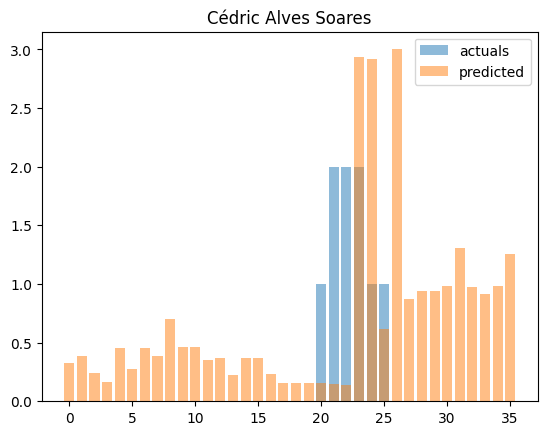

No player name


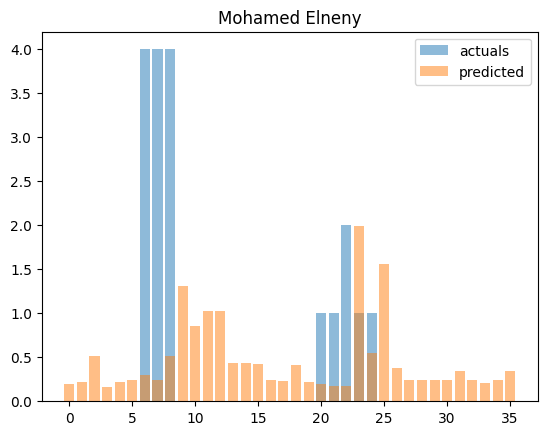

No player name


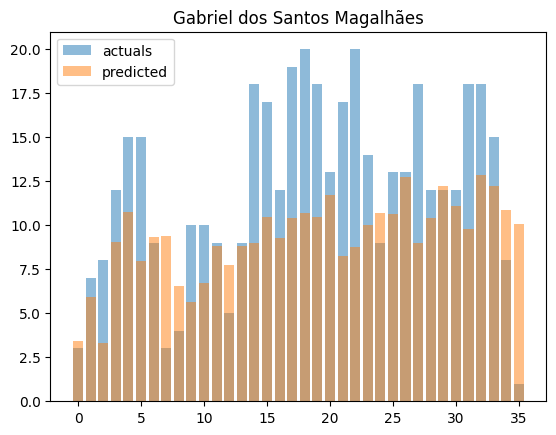

No player name


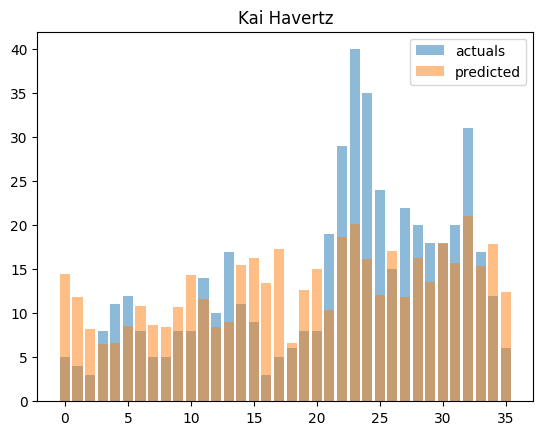

No player name


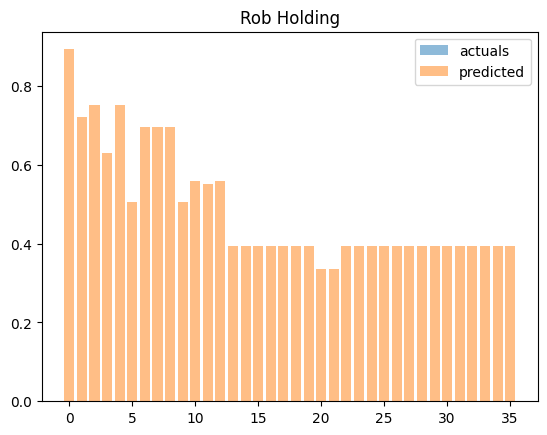

No player name


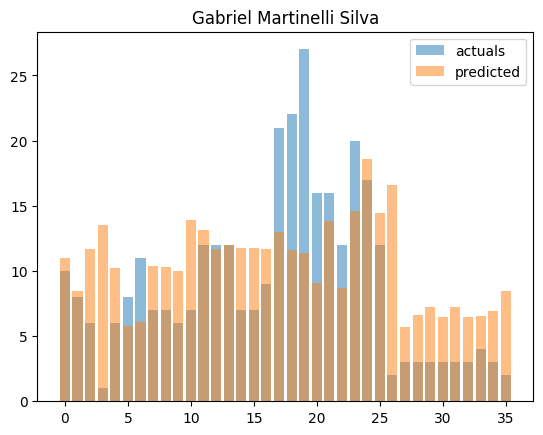

No player name


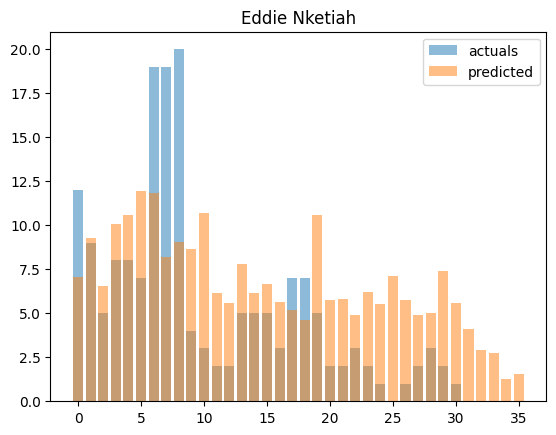

No player name


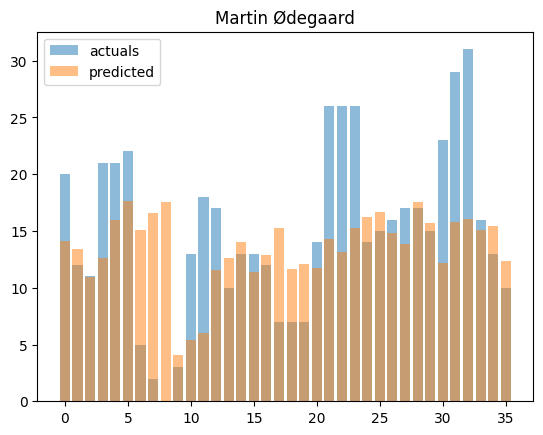

No player name


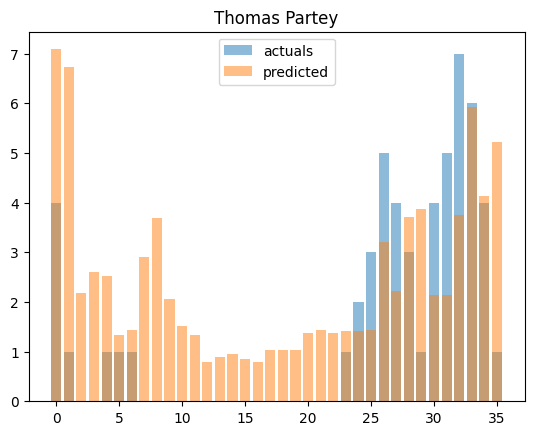

No player name


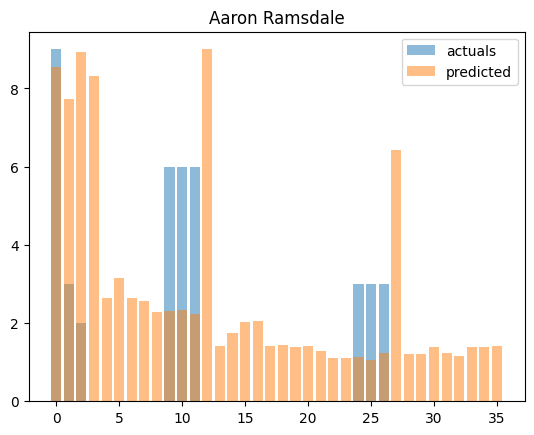

In [22]:
optimisation_cols = ['element', 'round', 'team_name', 'player_name', 'position', 'position_code', 'team_code', 'value', 'points_pred', 'total_points_sum_nr', 
                     'total_points_sum_n3r']

for element in holdout_players[:10]:
    actuals = []
    predicted = []
    for round in df['round'].unique():
        
        round_data = df[df['round']==round].copy()

        round_data['minutes_pred'] = lr_mins.predict(round_data[lr_mins_features])
        round_data['goals_pred'] = lr_goals.predict(round_data[lr_goals_features])
        round_data['assists_pred'] = lr_assists.predict(round_data[lr_assists_features])
        round_data['clean_sheets_pred'] = lr_clean_sheets.predict(round_data[lr_clean_sheets_features])
        round_data['goals_conceded_pred'] = lr_goals_conceded.predict(round_data[lr_goals_conceded_features])
        round_data['saves_pred'] = lr_saves.predict(round_data[lr_saves_features])

        round_data['points_pred'] = lgb_points.predict(round_data[lgb_points_features])

        # round_data['minutes_pred'] = lr_mins.predict(round_data[lr_mins_features])
        # round_data['points_pred'] = np.round(lr_points.predict(round_data[lr_points_features]), 0)
        team_optimisation_data = round_data[optimisation_cols]

        # player_data = team_optimisation_data[team_optimisation_data['player_name']==player_name]
        player_data = team_optimisation_data[team_optimisation_data['element']==element]
        
        if player_data.shape[0] > 0:
            try:
                player_name = player_data['player_name'].item()
            except:
                print('No player name')

            actuals.append(player_data[target_points_model].values[0])
            predicted.append(player_data['points_pred'].values[0])
    
   
    plt.figure()
    plt.title(player_name)
    plt.bar(np.arange(len(actuals)), actuals, label='actuals', alpha=0.5)
    plt.bar(np.arange(len(predicted)), predicted, label='predicted', alpha=0.5)
    plt.legend()
    plt.show()

#### Check an individual player predictions

In [23]:
guess = 'erling'
[player_name for player_name in df['player_name'].unique() if guess.upper() in player_name.upper()]

['Raheem Sterling', 'Erling Haaland']

No player name
No player name


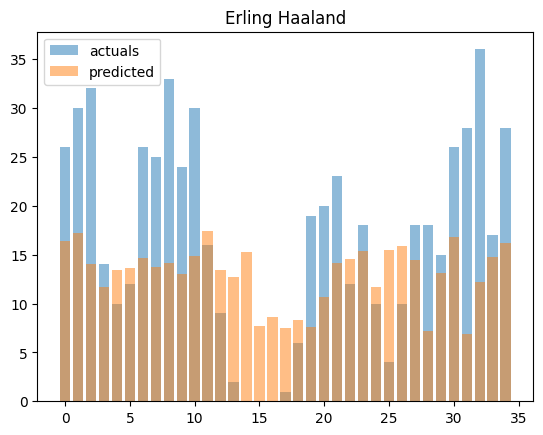

In [25]:
player_name = 'Erling Haaland'
optimisation_cols = ['element', 'round', 'team_name', 'player_name', 'position', 'position_code', 'team_code', 'value', 'points_pred', 'total_points_sum_nr', 
                     'total_points_sum_n3r']

actuals = []
predicted = []
for round in df['round'].unique():
    round_data = df[df['round']==round].copy()
    
    round_data['minutes_pred'] = lr_mins.predict(round_data[lr_mins_features])
    round_data['goals_pred'] = lr_goals.predict(round_data[lr_goals_features])
    round_data['assists_pred'] = lr_assists.predict(round_data[lr_assists_features])
    round_data['clean_sheets_pred'] = lr_clean_sheets.predict(round_data[lr_clean_sheets_features])
    round_data['goals_conceded_pred'] = lr_goals_conceded.predict(round_data[lr_goals_conceded_features])
    round_data['saves_pred'] = lr_saves.predict(round_data[lr_saves_features])

    round_data['points_pred'] = lgb_points.predict(round_data[lgb_points_features])

    # round_data['minutes_pred'] = lr_mins.predict(round_data[lr_mins_features])
    # round_data['points_pred'] = np.round(lr_points.predict(round_data[lr_points_features]), 0)
    team_optimisation_data = round_data[optimisation_cols]

    player_data = team_optimisation_data[team_optimisation_data['player_name']==player_name]
    
    if player_data.shape[0] > 0:
        try:
            player_name = player_data['player_name'].item()
        except:
            print('No player name')

        actuals.append(player_data[target_points_model].values[0])
        predicted.append(player_data['points_pred'].values[0])
    
   
plt.figure()
plt.title(player_name)
plt.bar(np.arange(len(actuals)), actuals, label='actuals', alpha=0.5)
plt.bar(np.arange(len(predicted)), predicted, label='predicted', alpha=0.5)
plt.legend()
plt.show()

## Optimisation 

In [26]:
import numpy as np
from matplotlib import pyplot as plt
import pulp
import pandas as pd
import seaborn as sns

In [57]:
def get_optimal_team(optimisation_data,
                     n_players_to_select, 
                     max_cost, 
                     n_changes=2,
                     min_cost=0,
                     max_team=3, 
                     current_team=None,
                     verbose=False, 
                     logging=False):
    

    n_elements = optimisation_data.shape[0]
    points = optimisation_data[:, 0]
    costs = optimisation_data[:, 1]
    teams = optimisation_data[:, 2]
    positions = optimisation_data[:, 3]
    player_idxs = optimisation_data[:, 4]

    print(points[:10])
    print(costs.min() * n_players_to_select)


    # Define the problem
    problem = pulp.LpProblem("optimise_team", pulp.LpMaximize)

    # Create binary decision variables
    selection_vars = [pulp.LpVariable(f"binary_var_{i}", cat=pulp.LpBinary) for i in range(n_elements)]

    # Objective function: maximize the sum of selected elements
    problem += pulp.lpDot(points, selection_vars), "objective"

    # Constraint: Select exactly n_players_to_select elements
    problem += pulp.lpSum(selection_vars) == n_players_to_select, "number_of_selections"

    # Combined Cost Constraints: enforce both minimum and maximum cost in one go
    total_cost = pulp.lpDot(costs, selection_vars)
    problem += total_cost >= min_cost, "min_cost"
    # problem += total_cost <= max_cost, "max_cost"

    # Solve the problem
    solver = pulp.PULP_CBC_CMD(gapRel=0.2, mip=True, msg=logging, timeLimit=1000)
    # solver = pulp.PULP_CBC_CMD(msg=logging)
    problem.solve(solver)

    # solver = pulp.GLPK_CMD(msg=logging)
    # problem.solve(solver)

    # Changes
    # if current_team:
        # problem += pulp.lpSum([selection_vars[i] == current_team[i] for i in range(n_elements)]) == n_elements - n_changes, "Number_of_changes"

    # Constraints: no more than 4 items from any single class
    # team_codes = np.unique(teams)
    # for c in team_codes:
    #     problem += pulp.lpSum([selection_vars[i] for i in range(n_elements) if teams[i] == c]) <= max_team, f"team {c} Limit"

    status = pulp.LpStatus[problem.status]

    # Extract the selected elements
    selection = [1 if pulp.value(selection_vars[i])>=1.0 else 0 for i in range(n_elements)]
    # selection = [pulp.value(selection_vars[i]) for i in range(n_elements)]
    selected_points = np.array([x for x in points * selection if x > 0.0])
    selected_costs = np.array([x for x in costs * selection if x > 0.0])
    selected_indicies = np.array([x for x in player_idxs * selection if x > 0.0], dtype=np.int8)

    assert len(selected_points) == len(selected_costs) == len(selected_indicies)

    if verbose:
        print("Solver status:", status)
        print(f'Points length {len(points)}')
        print("Selected indices:", selection)
        print("Selected cost elements:", selected_costs)
        print("Selected points elements:", selected_points)
        print("Sum of selected cost elements:", selected_costs.sum())
        print("Sum of selected points elements:", selected_points.sum())

    if sum(selection) != n_players_to_select:
        # raise ValueError("Invalid number of players selected")
        print("Invalid number of players selected")

    # Inspect variable values
    # for v in problem.variables():
    #     print(v.name, "=", v.varValue)

    # Check constraints satisfaction
    # for name, constraint in problem.constraints.items():
    #     print(f"{name}: {constraint.value()} <= {constraint.constant}")

    return selection, selected_points, selected_costs, selected_indicies

def get_binary_array(n, idicies):
    arr = [0] * n
    for i in idicies:
        arr[i] = 1

    return arr


In [58]:
import pdb

dataset = 'train'
optimisation_cols = ['element', 'round', 'team_name', 'player_name', 'position', 'position_code', 'team_code', 'value', 
                     'minutes_pred', 'points_pred', 'total_points_sum_nr', 'total_points_sum_n3r', 'rand']

actuals = []
predicted = []
min_cost = 800.0
max_cost = 1000.0
QUANTILE = 0.8

n_players_to_select = 10
actual_points = 0
total_points = 0

# initial_data = df[(df['round']==1) & (df['train_holdout']==dataset)].copy()
# ict = initial_data['ict_index'].values
# costs = initial_data['value'].values
# positions = initial_data['value'].values
# teams = initial_data['team_code'].values
# selected_indices, optimal_points, optimal_cost = get_optimal_team(ict, costs, positions, teams, n_selected_players, 
#                                                                   max_cost, min_cost=min_cost, verbose=False, logging=False)
# current_team = get_binary_array(500, selected_indices)
# chosen_team = initial_data['player_name'].reset_index(drop=True)[selected_indices].values
# print(f'Initial team: {chosen_team} cost: {sum(optimal_cost)}\n')

current_team = None
current_team_idxs = [1] 

for round in df['round'].unique():

    #================================================================================
    #========== Get current round data and run models
    #================================================================================

    round_data = df[(df['round']==round) & (df['train_holdout']==dataset)].copy()

    # Apply predictions to round data
    round_data['minutes_pred'] = lr_mins.predict(round_data[lr_mins_features])
    round_data['goals_pred'] = lr_goals.predict(round_data[lr_goals_features])
    round_data['assists_pred'] = lr_assists.predict(round_data[lr_assists_features])
    round_data['clean_sheets_pred'] = lr_clean_sheets.predict(round_data[lr_clean_sheets_features])
    round_data['goals_conceded_pred'] = lr_goals_conceded.predict(round_data[lr_goals_conceded_features])
    round_data['saves_pred'] = lr_saves.predict(round_data[lr_saves_features])
    round_data['points_pred'] = lgb_points.predict(round_data[lgb_points_features])


    #================================================================================
    #========== Filter eligible players
    #================================================================================

    # Compute the top percentile of points for each unique cost
    top_percentiles = round_data.groupby(['position', 'value'])['points_pred'].quantile(QUANTILE).reset_index()
    top_percentiles.columns = ['position', 'value', 'top_percentiles']

    # Merge the percentiles back with the original data
    data_with_percentiles = pd.merge(round_data, top_percentiles, on=['position', 'value'])

    # Filter the DataFrame to keep only rows where points are above the 95th percentile
    team_optimisation_data = data_with_percentiles[(data_with_percentiles['points_pred'] > data_with_percentiles['top_percentiles']) \
                                                   | (data_with_percentiles['element'].isin(current_team_idxs))]

    # Drop the auxiliary percentile column (optional)
    team_optimisation_data = team_optimisation_data.drop(columns=['top_percentiles'])

    print(team_optimisation_data.shape)

    #================================================================================
    #========== Create data for optimisation
    #================================================================================
    player_idxs = team_optimisation_data['element'].values
    points_pred = team_optimisation_data['points_pred'].values
    points_actual = team_optimisation_data['total_points_sum_nr'].values
    costs = team_optimisation_data['value'].values
    positions = team_optimisation_data['position_code'].values
    teams = team_optimisation_data['team_code'].values

    n_unique_players = team_optimisation_data['element'].unique().shape[0]
    print(n_unique_players)

    player_map = {idx:i for i, idx in enumerate(player_idxs)}

    optimisation_data = np.zeros((player_idxs.shape[0], 5), dtype=np.float16)
    for i, idx in enumerate(player_idxs):
        optimisation_data[player_map[idx], 0] += points_pred[i]
        optimisation_data[player_map[idx], 1] = costs[i]
        optimisation_data[player_map[idx], 2] = teams[i]
        optimisation_data[player_map[idx], 3] = positions[i]
        optimisation_data[player_map[idx], 4] = player_idxs[i]

    print(player_idxs)
    # pdb.set_trace()

    #================================================================================
    #========== Optimise team
    #================================================================================
    optimised_team, optimal_points, optimal_cost, selected_indicies = get_optimal_team(optimisation_data, 
                                                                        n_players_to_select,
                                                                        max_cost, 
                                                                        n_changes=1,
                                                                        current_team=current_team,
                                                                        min_cost=min_cost,
                                                                        verbose=False, 
                                                                        logging=False)
    
    print(f'optimised team: {optimised_team}')
    print(f'indicies{selected_indicies}')
    round_points = np.dot(points_actual, np.array(optimised_team))


    #================================================================================
    #========== Team Changes
    #================================================================================

    # # Get the player with highest expected points to determine captaincy
    # players = team_optimisation_data['player_name'].reset_index(drop=True)[current_team].to_list()
    players = team_optimisation_data[team_optimisation_data['element'].isin(selected_indicies)]['player_name'].unique()

    print(team_optimisation_data[['element', 'player_name']])
    print(team_optimisation_data[team_optimisation_data['element']==85])
    print(players, optimal_points.argmax())
    print(players[6])

    best_player = players[optimal_points.argmax()]

    best_player_pred_points = optimal_points.max()
    best_player_points = points_actual[optimised_team[optimal_points.argmax()]]
    chosen_team = team_optimisation_data['player_name'].reset_index(drop=True)[optimised_team]

    actual_points += round_points + best_player_points
    total_points += optimal_points.sum() + best_player_pred_points

    actuals.append(actual_points)
    predicted.append(total_points)

    print(f'round: {round}, optimal points: {optimal_points.sum()}, round points: {round_points}, cost: {optimal_cost.sum()}')
    print(f'captain: {best_player}, expected points: {best_player_pred_points}')
    print([points for points in optimal_points if points > 0.0])
    print(f'players: {players} \n')
    

print(actual_points)
print(total_points)

plt.figure()
plt.plot(np.arange(len(actuals)), actuals, label='actual points')
plt.plot(np.arange(len(predicted)), predicted, label='predicted points')
plt.legend()
plt.show()

(91, 808)
91
[  6  15  17  19  28  52  54  60  63  69  76  82  89  92 105 129 135 143
 145 150 157 165 168 195 196 197 199 203 220 221 225 228 231 240 241 242
 255 256 257 261 263 278 281 291 304 313 314 315 316 326 340 341 343 362
 365 369 376 378 394 396 401 403 405 429 430 436 439 469 473 482 488 490
 498 505 523 525 526 528 532 534 542 570 574 582 588 597 611 617 624 631
 655]
[14.48    7.086   8.55   14.914   7.13    5.117   0.6636 11.69    9.42
  2.752 ]
400.0
Invalid number of players selected
optimised team: [1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
indicies[   6   19   60   22 -116   14  105]
     element     player_name
3          6     Kai Havertz
8         15   Thomas Partey
9         17  Aaron Ramsdale
10        19     Bukayo Saka
19        28  

IndexError: index 6 is out of bounds for axis 0 with size 4

In [52]:
print(player_idxs)

points_pred = team_optimisation_data['points_pred'].values
points_actual = team_optimisation_data['total_points_sum_nr'].values
costs = team_optimisation_data['value'].values
positions = team_optimisation_data['value'].values
teams = team_optimisation_data['team_code'].values


data_block = np.zeros((850, 5), dtype=np.float16)
data_block[:, 0] = current_team

for i, idx in enumerate(player_idxs):
    data_block[idx, 0] = points_pred[i]
    data_block[idx, 1] = costs[i]
    data_block[idx, 2] = positions[i]
    data_block[idx, 3] = teams[i]

print(data_block[32, :])

[  6  15  17  19  28  52  60  63  92 135 143 145 150 157 168 195 196 197
 220 221 225 228 240 256 263 278 291 313 314 315 316 340 341 343 362 365
 394 396 401 403 405 430 439 473 488 490 498 523 525 526 528 532 542 570
 582 611 617 624]
[nan  0.  0.  0.  0.]


In [395]:
import pulp

# Define the problem
problem = pulp.LpProblem("optimise_team", pulp.LpMaximize)

# Number of elements and other constants
n_elements = 10  # for example
n_players_to_select = 5
min_cost = 10
max_cost = 50
logging = True

# Example data for points and costs
points = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # example points
costs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]  # example costs

# Create binary decision variables
selection_vars = [pulp.LpVariable(f"binary_var_{i}", cat=pulp.LpBinary) for i in range(n_elements)]

# Objective function: maximize the sum of selected elements
problem += pulp.lpDot(points, selection_vars), "Objective"

# Constraint: Select exactly n_players_to_select elements
problem += pulp.lpSum(selection_vars) == n_players_to_select, "Number_of_selections"

# Combined Cost Constraints: enforce both minimum and maximum cost in one go
total_cost = pulp.lpDot(costs, selection_vars)
problem += total_cost >= min_cost, "min_cost"
problem += total_cost <= max_cost, "max_cost"

# Solve the problem
solver = pulp.PULP_CBC_CMD(gapRel=0.00, mip=True, msg=logging, timeLimit=600)
problem.solve(solver)

# Output the results
print("Status:", pulp.LpStatus[problem.status])
for v in selection_vars:
    print(v.name, "=", v.varValue)


Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/ym/d61c4fn95wnc49fhqpl3s4480000gn/T/f5d81dff844749a59b9c7d3f83a87d63-pulp.mps -max -sec 600 -ratio 0.0 -timeMode elapsed -branch -printingOptions all -solution /var/folders/ym/d61c4fn95wnc49fhqpl3s4480000gn/T/f5d81dff844749a59b9c7d3f83a87d63-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 8 COLUMNS
At line 69 RHS
At line 73 BOUNDS
At line 84 ENDATA
Problem MODEL has 3 rows, 10 columns and 30 elements
Coin0008I MODEL read with 0 errors
seconds was changed from 1e+100 to 600
ratioGap was changed from 0 to 0
Option for timeMode changed from cpu to elapsed
Continuous objective value is 400 - 0.00 seconds
Cgl0004I processed model has 2 rows, 10 columns (10 integer (10 of which binary)) and 20 elements
Cutoff increment increased fro

## Synthetic Data Generation

In [33]:
df.head()

Unnamed: 0  element  round  fixture team_name      player_name position  \
0          32        1      1        2   Arsenal  Folarin Balogun      FWD   
1          66        1      2       12   Arsenal  Folarin Balogun      FWD   
2         100        1      3       21   Arsenal  Folarin Balogun      FWD   
3         133        1      4       31   Arsenal  Folarin Balogun      FWD   
4         164        1      5       43   Arsenal  Folarin Balogun      FWD   

   position_code  team_code  opp_round_1  ...  total_points_sum_n6r  \
0              4          3          8.0  ...                   0.0   
1              4          3         10.0  ...                   0.0   
2              4          3         14.0  ...                   0.0   
3              4          3          9.0  ...                   0.0   
4              4          3         18.0  ...                   0.0   

   total_points_sum_all  total_points_per_gw_forward  value_nr  \
0                     0                          0.0      45.0   
1                     0                          0.0      45.0   
2                     0                          0.0      44.0   
3                     0                          0.0      44.0   
4                     0                          0.0      44.0   

   value_change_nr  selected_nr  transfers_in_nr  transfers_out_nr  \
0              0.0      63768.0           4959.0            9703.0   
1              0.0      58109.0           2507.0           10189.0   
2             -1.0      49814.0           2558.0           12254.0   
3              0.0      37048.0              0.0           12786.0   
4              0.0      32878.0              0.0            4527.0   

   transfers_balance_nr  ict_index_nr  
0               -4744.0           0.0  
1               -7682.0           0.0  
2               -9696.0           0.0  
3              -12786.0           0.0  
4               -4527.0           0.0  

[5 rows x 467 columns]

In [34]:
from numpy.random import multivariate_normal

target = 'total_points_sum_n3r'
other_features = ['element']
# Calculate the original covariance matrix
# df_data_gen = df[df['minutes'] > 0.0]
df_data_gen = df.copy()
df_data_gen = df_data_gen[selected_features_list + [target] + other_features]
df_data_gen.fillna(0.0, inplace=True)

cov_matrix = np.cov(df_data_gen.T)
mean_vector = df_data_gen.mean().values

print("Original Covariance Matrix:\n", cov_matrix)

# Calculate eigenvalues
eigenvalues, _ = np.linalg.eigh(cov_matrix)

# Check if all eigenvalues are non-negative
print("Eigenvalues of the covariance matrix:", eigenvalues)
print("Is the covariance matrix positive semi-definite?", np.all(eigenvalues >= 0))


# Generate synthetic data using the adjusted covariance matrix
synthetic_data = pd.DataFrame(multivariate_normal(mean_vector, cov_matrix, size=10000), columns=df_data_gen.columns)


synthetic_data.head()
# Save the synthetic data to a CSV file
# synthetic_data.to_csv('adjusted_synthetic_dataset.csv', index=False)


Original Covariance Matrix:
 [[ 1.72917384e-01  4.61691488e-02  4.16803913e-02 ...  1.00006418e-02
   1.26976989e+00 -1.26255657e+01]
 [ 4.61691488e-02  3.27214879e-02  2.90891717e-02 ...  4.35975500e-03
   5.28154329e-01 -8.05143815e+00]
 [ 4.16803913e-02  2.90891717e-02  2.88696455e-02 ...  4.33907143e-03
   4.90593748e-01 -7.08899337e+00]
 ...
 [ 1.00006418e-02  4.35975500e-03  4.33907143e-03 ...  1.02282255e-02
   1.07881353e-01 -1.08726438e+00]
 [ 1.26976989e+00  5.28154329e-01  4.90593748e-01 ...  1.07881353e-01
   2.71077154e+01 -1.76741569e+02]
 [-1.26255657e+01 -8.05143815e+00 -7.08899337e+00 ... -1.08726438e+00
  -1.76741569e+02  5.32825173e+04]]
Eigenvalues of the covariance matrix: [6.78468042e-05 2.03524118e-04 2.91501755e-04 4.63103464e-04
 6.50581849e-04 9.12904261e-04 1.04810641e-03 1.34806707e-03
 1.52476495e-03 1.73377379e-03 1.95516162e-03 2.06540176e-03
 2.33352124e-03 2.82802871e-03 3.01608236e-03 3.09578132e-03
 4.34503885e-03 5.12064257e-03 6.05057035e-03 6.60993

minutes_pct_of_max  total_points_cum_pct_of_max  ict_index_cum_pct_of_max  \
0           -0.103385                    -0.048605                 -0.073476   
1            0.874477                     0.002534                  0.107113   
2            0.504188                     0.091380                  0.071677   
3            0.605946                     0.459597                  0.457254   
4            0.597629                     0.348539                  0.286809   

   influence_cum_pct_of_max  bps_cum_pct_of_max  ict_index_pct_of_max  \
0                  0.090052            0.114832             -0.127582   
1                  0.008763            0.047250              0.385704   
2                 -0.021686            0.024607              0.022680   
3                  0.478402            0.618833              0.056866   
4                  0.431871            0.544694              0.272810   

   minutes_cum_pct_of_max  bps_pct_of_max  clean_sheets_cum_pct_of_max  \
0                0.183547        0.051766                    -0.046398   
1                0.072674        0.425976                    -0.095036   
2               -0.153838        0.115947                     0.131213   
3                0.747777        0.190569                     0.334147   
4                0.761689        0.228406                     0.370085   

   creativity_cum_pct_of_max  ...  selected_cum_pct_of_max  \
0                  -0.108603  ...                -0.025305   
1                   0.208784  ...                -0.090150   
2                   0.124481  ...                 0.131601   
3                   0.411734  ...                 0.111166   
4                   0.151977  ...                 0.089360   

   transfers_out_cum_pct_of_max  clean_sheets_pct_of_max  bonus_pct_of_max  \
0                     -0.088237                -0.260567         -0.009089   
1                     -0.053717                 0.249881          0.243543   
2                      0.171720                 0.032177          0.184254   
3                      0.250805                 0.508803          0.020710   
4                      0.043058                 0.242392          0.131699   

   goals_scored_pct_of_max  transfers_out_pct_of_max  value_cum_pct_of_max  \
0                 0.006467                 -0.060360              0.101141   
1                 0.240475                  0.042223              0.213872   
2                 0.069413                 -0.027625              0.348840   
3                 0.102496                  0.143098              0.634216   
4                 0.141888                  0.156377              0.332271   

   assists_pct_of_max  total_points_sum_n3r     element  
0            0.011578             -6.857562  674.545845  
1            0.122896             11.118891  564.954725  
2            0.012708              6.505022   63.861679  
3            0.028001             11.126293 -211.964264  
4           -0.088503             10.146945  256.162081  

[5 rows x 35 columns]

In [35]:
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer, GaussianCopulaSynthesizer

metadata = SingleTableMetadata()
metadata.detect_from_dataframe(df_data_gen)

synthesizer = CTGANSynthesizer(metadata)
# synthesizer = GaussianCopulaSynthesizer(metadata)
synthesizer.fit(df_data_gen)


/Users/geoffrey.nightingale@contino.io/opt/anaconda3/envs/torch-env/lib/python3.9/site-packages/sdv/single_table/base.py:84: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(


In [36]:
synthesizer_name = 'ctgan_synthesizer.pkl'

# Save the trained synthesizer to a file
synthesizer.save(synthesizer_name)
synthesizer = CTGANSynthesizer.load(synthesizer_name)

In [37]:
synthetic_data = synthesizer.sample(num_rows=10000)
synthetic_data.head()

minutes_pct_of_max  total_points_cum_pct_of_max  ict_index_cum_pct_of_max  \
0            0.996439                     0.453763                  0.287226   
1            0.998683                     0.020069                  0.017976   
2            0.495046                     0.108674                  0.166593   
3            0.000000                     0.020497                  0.062172   
4            0.858787                     0.242605                  0.075656   

   influence_cum_pct_of_max  bps_cum_pct_of_max  ict_index_pct_of_max  \
0                  0.519018            0.748508              0.108508   
1                  0.015627            0.071712              0.224934   
2                  0.080879            0.062477              0.015592   
3                  0.000000           -0.003653              0.000000   
4                  0.415371            0.532471              0.061156   

   minutes_cum_pct_of_max  bps_pct_of_max  clean_sheets_cum_pct_of_max  \
0                0.367039        0.382767                     0.159406   
1                0.038766        0.097868                     0.000000   
2                0.105898       -0.000426                     0.000461   
3                0.000764       -0.001435                     0.070000   
4                0.851904        0.250243                     0.374673   

   creativity_cum_pct_of_max  ...  selected_cum_pct_of_max  \
0                   0.061113  ...                 0.042546   
1                   0.025258  ...                 0.000630   
2                   0.112992  ...                 0.042070   
3                   0.012807  ...                 0.000669   
4                   0.000160  ...                 0.015876   

   transfers_out_cum_pct_of_max  clean_sheets_pct_of_max  bonus_pct_of_max  \
0                      0.048892                      1.0          0.994501   
1                      0.004145                      0.0          0.000382   
2                      0.037594                      0.0          0.000205   
3                      0.003007                      0.0          0.000000   
4                      0.009235                      1.0          0.000539   

   goals_scored_pct_of_max  transfers_out_pct_of_max  value_cum_pct_of_max  \
0                 0.000000                  0.007819              0.318626   
1                 0.000000                  0.001004              0.038543   
2                 0.000000                  0.077065              0.285002   
3                 0.000149                  0.002978              0.310934   
4                 0.000000                  0.002066              0.313540   

   assists_pct_of_max  total_points_sum_n3r  element  
0            0.506944                   1.0      495  
1            0.000018                   1.0      669  
2            0.000000                   1.0      260  
3            0.000000                  12.0      126  
4            0.000000                   5.0       35  

[5 rows x 35 columns]

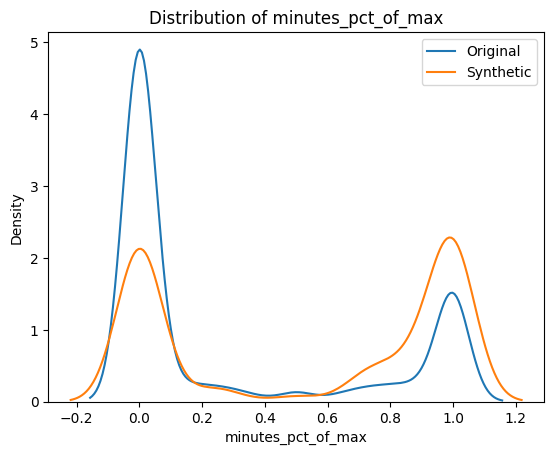

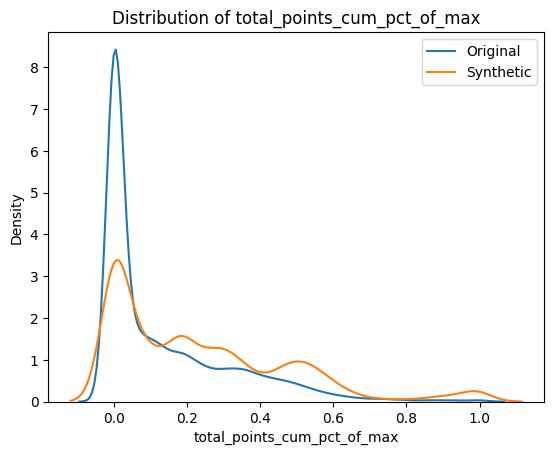

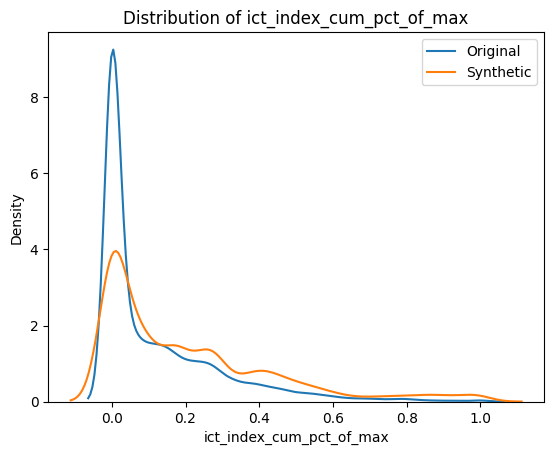

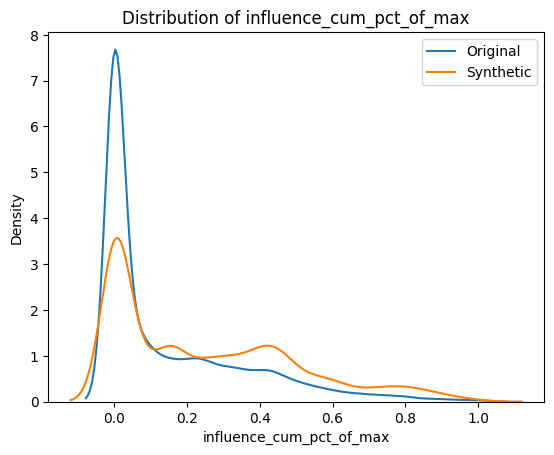

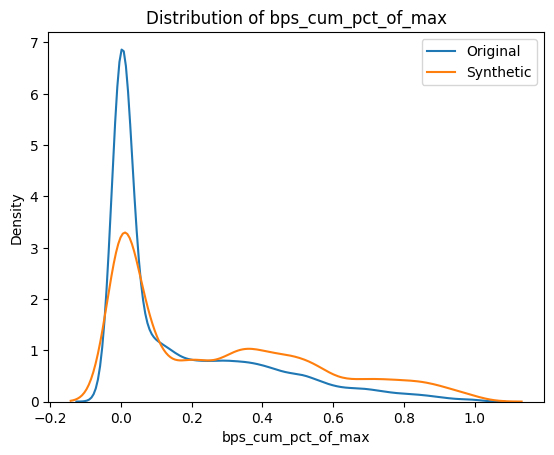

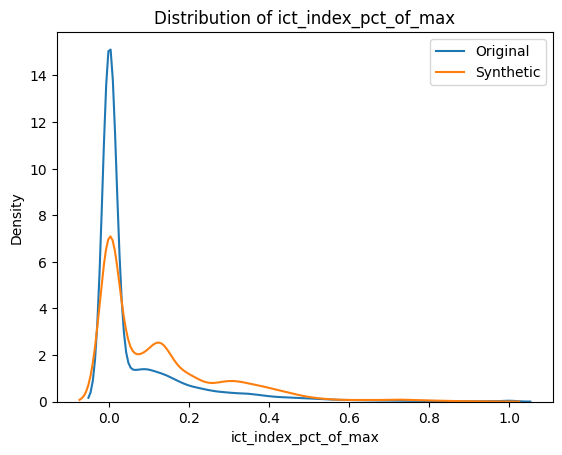

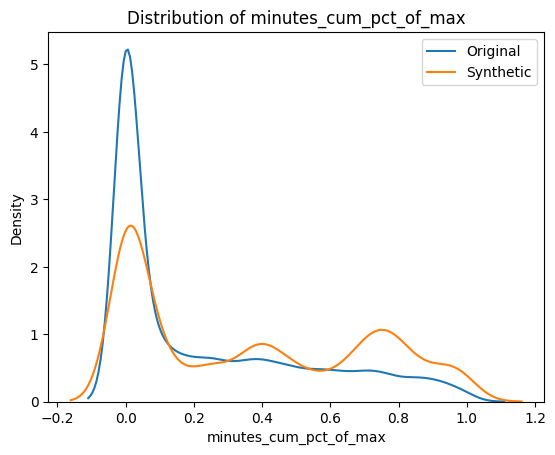

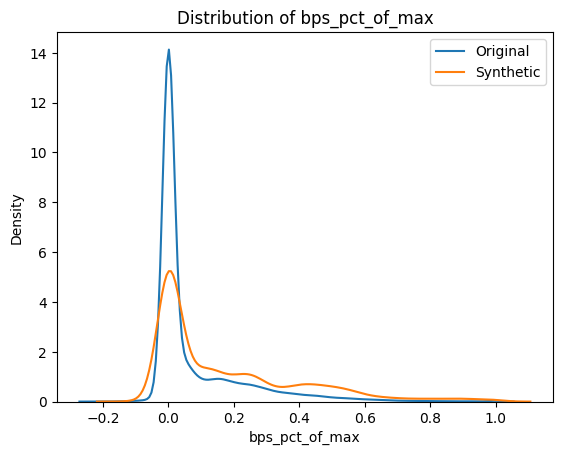

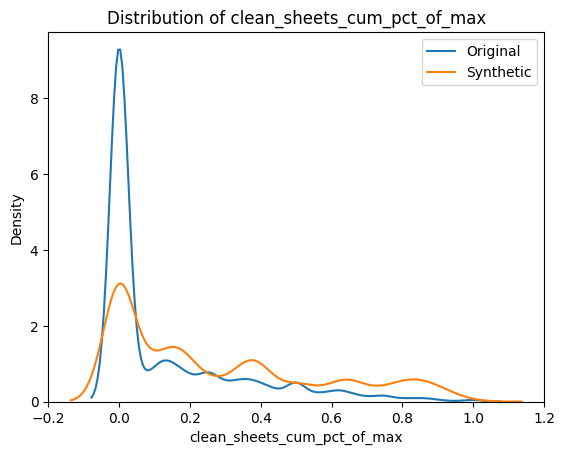

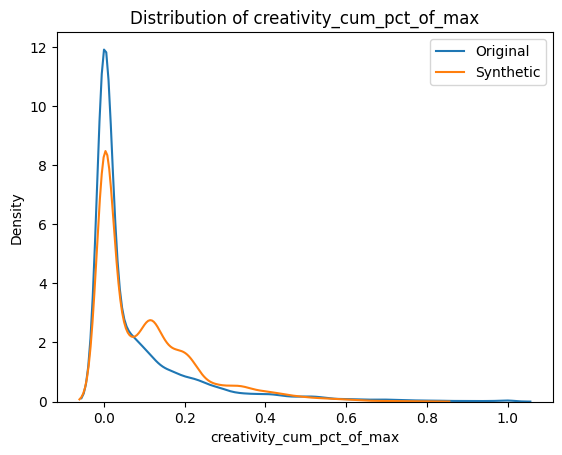

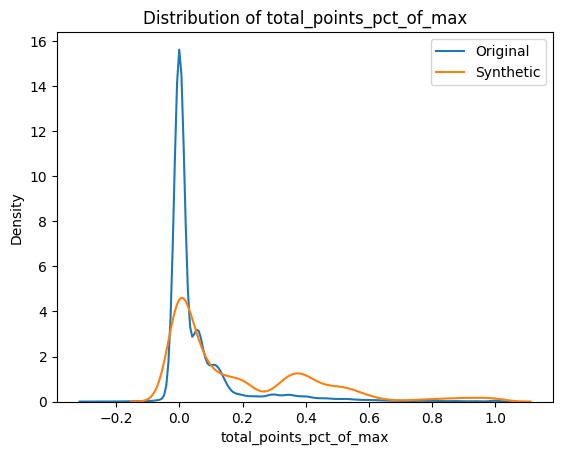

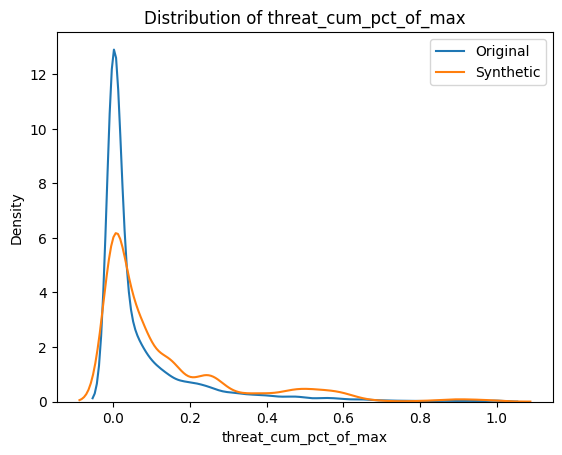

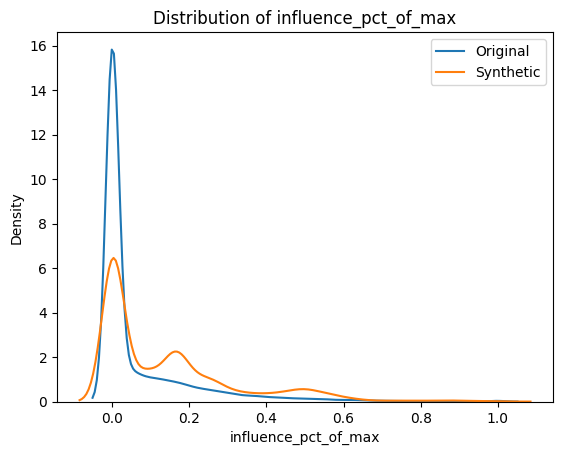

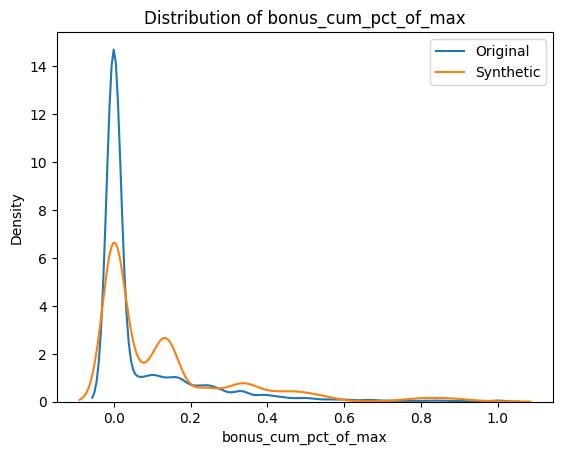

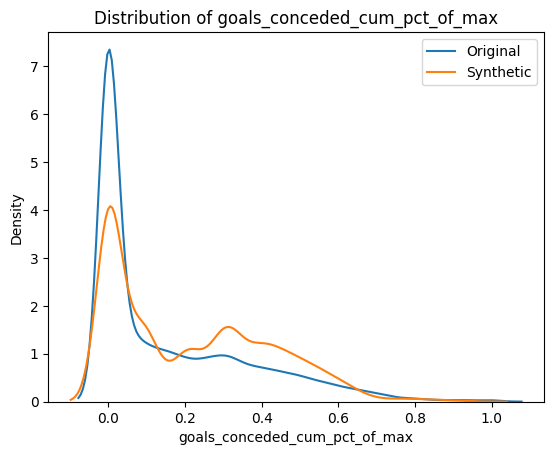

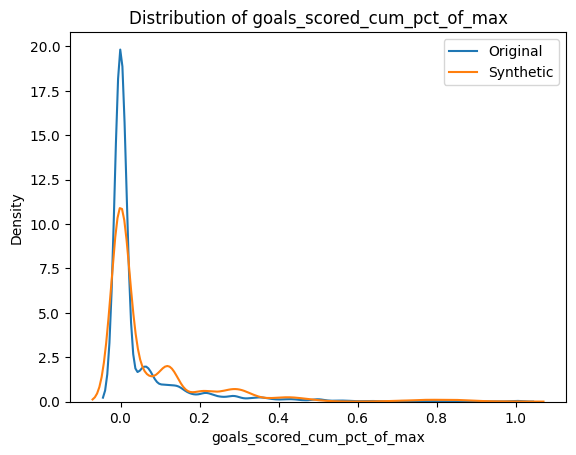

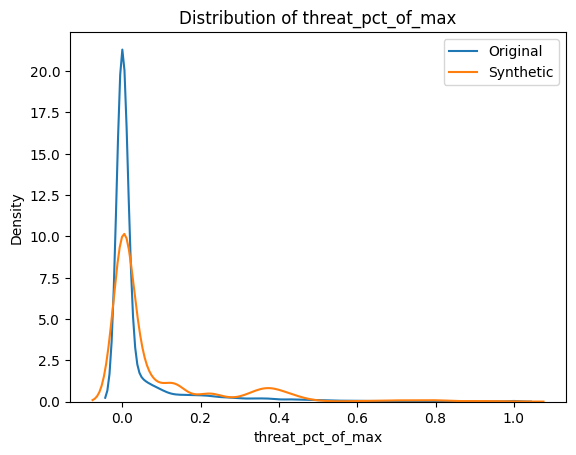

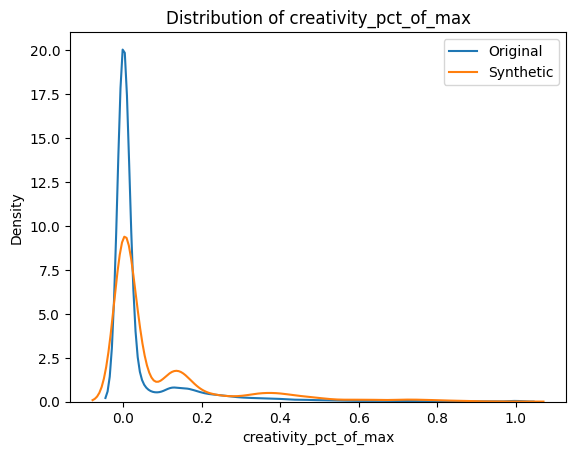

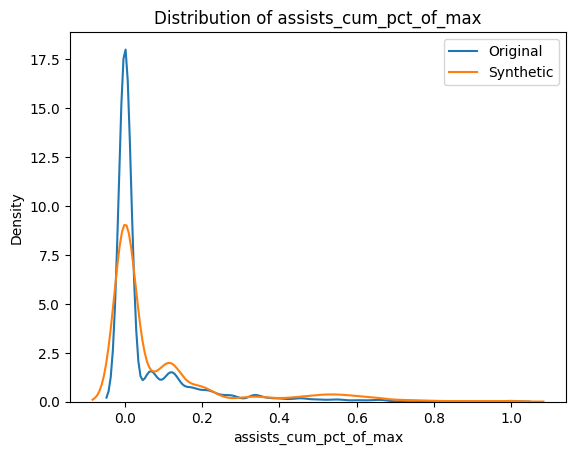

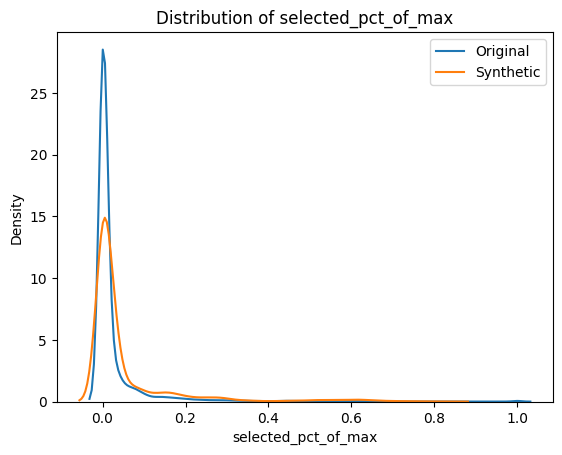

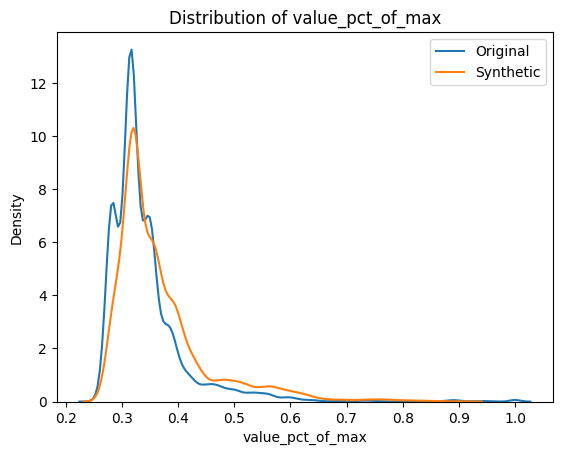

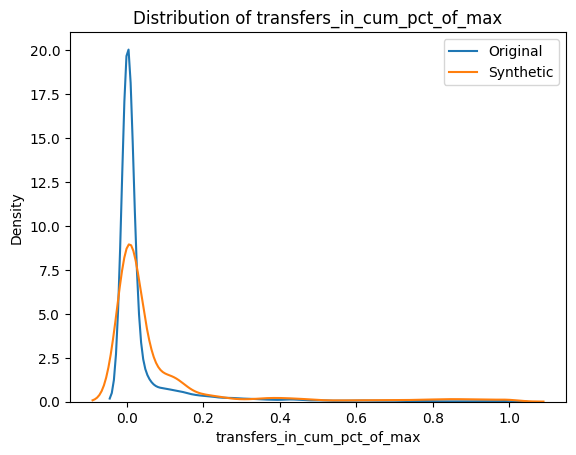

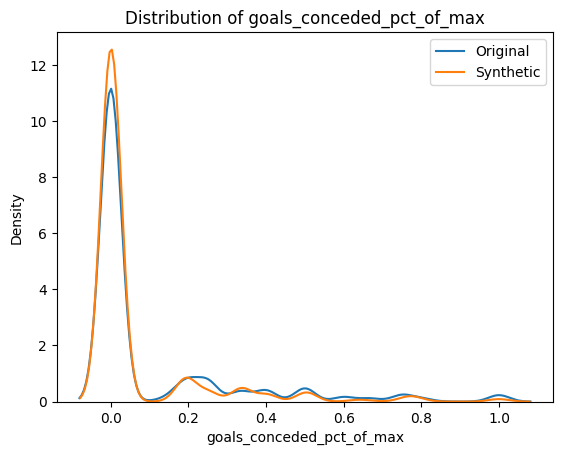

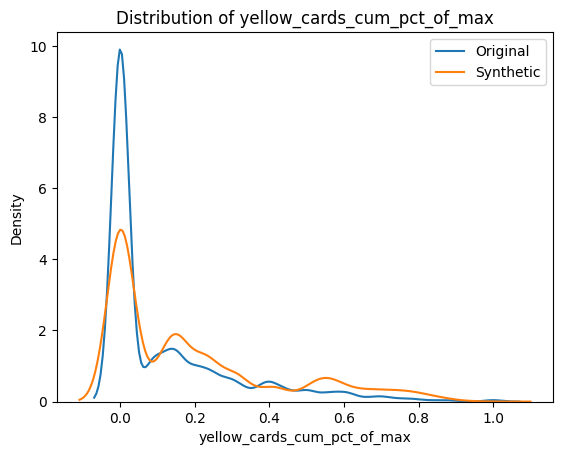

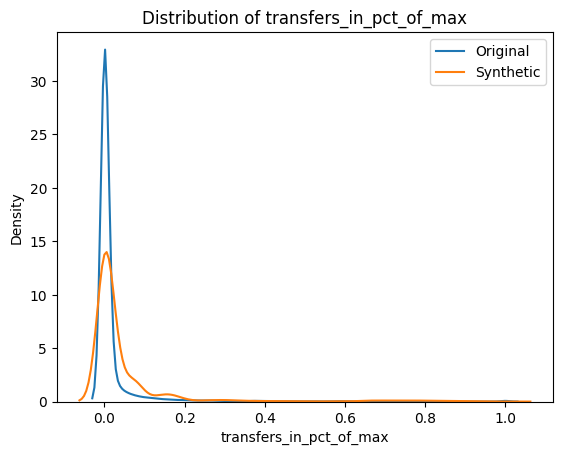

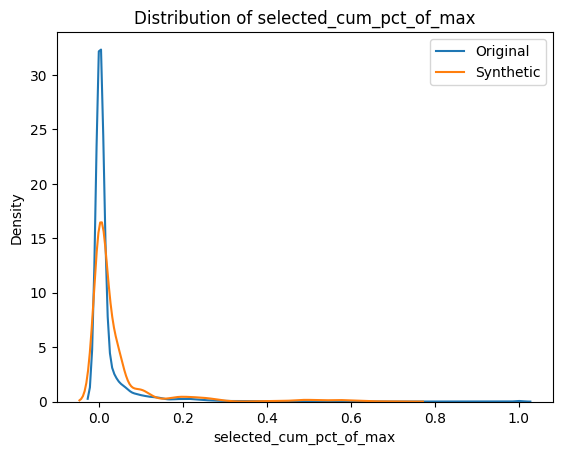

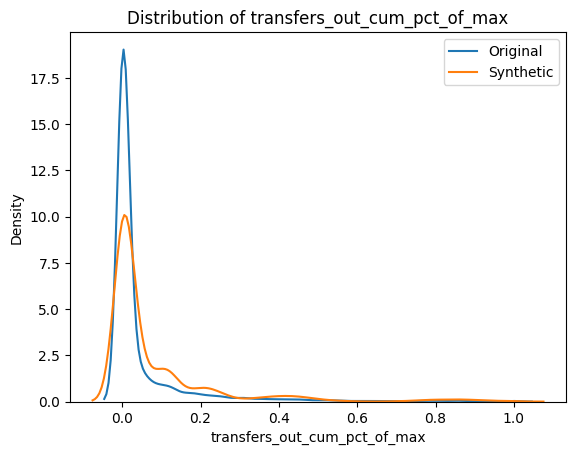

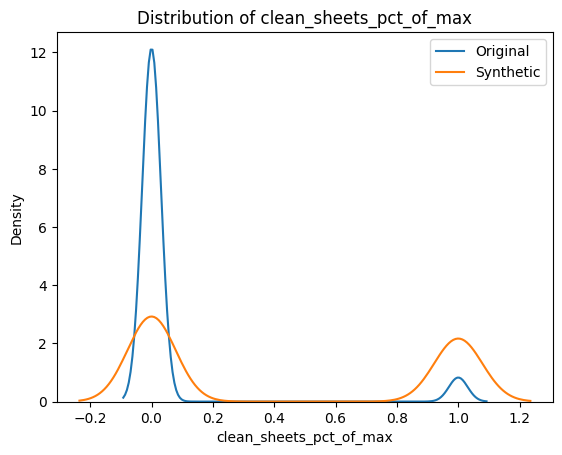

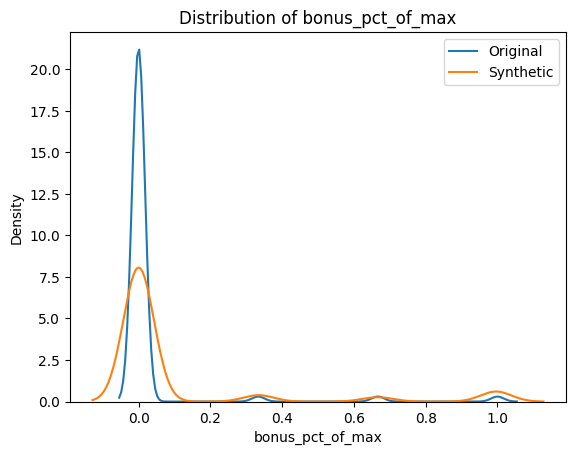

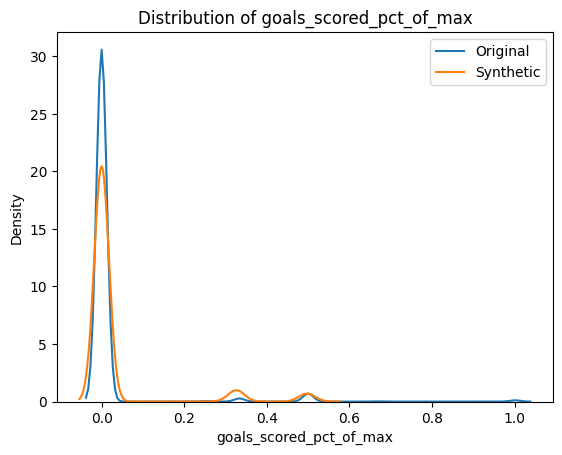

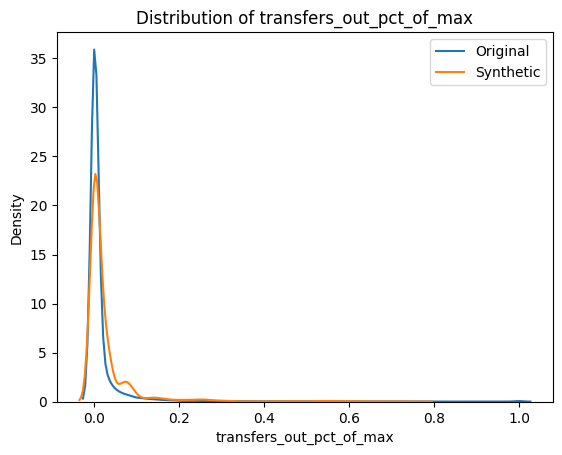

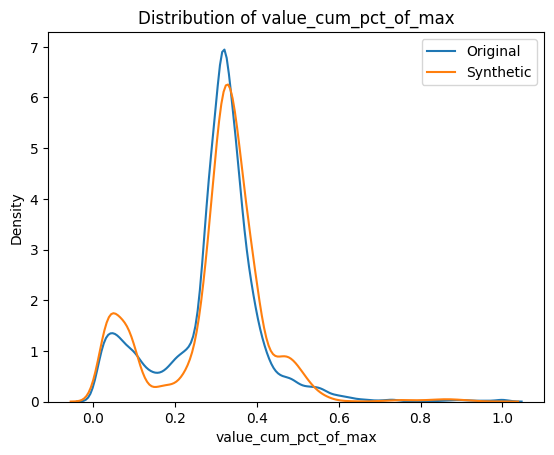

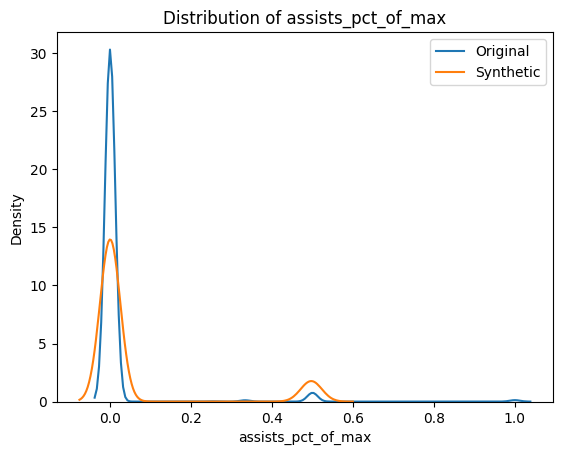

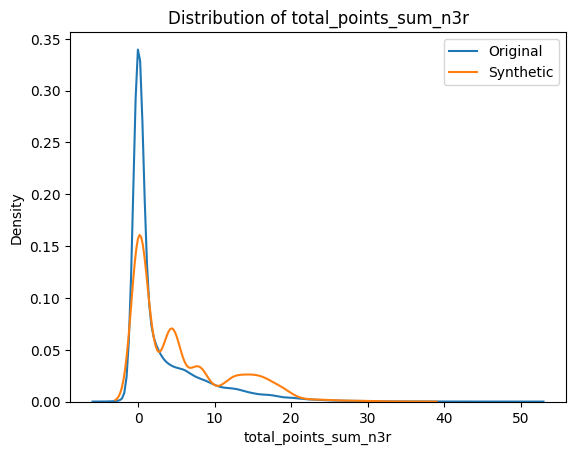

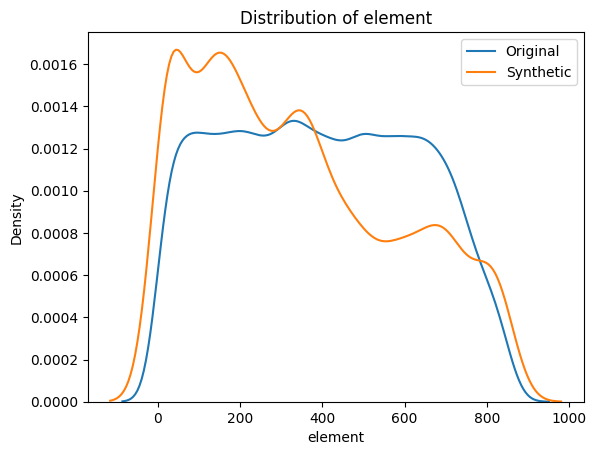

Original Correlation Matrix:
                                minutes_pct_of_max  \
minutes_pct_of_max                       1.000000   
total_points_cum_pct_of_max              0.613785   
ict_index_cum_pct_of_max                 0.589918   
influence_cum_pct_of_max                 0.644424   
bps_cum_pct_of_max                       0.644772   
ict_index_pct_of_max                     0.702751   
minutes_cum_pct_of_max                   0.661925   
bps_pct_of_max                           0.744557   
clean_sheets_cum_pct_of_max              0.557822   
creativity_cum_pct_of_max                0.479045   
total_points_pct_of_max                  0.626100   
threat_cum_pct_of_max                    0.423490   
influence_pct_of_max                     0.705921   
bonus_cum_pct_of_max                     0.468410   
goals_conceded_cum_pct_of_max            0.620318   
goals_scored_cum_pct_of_max              0.346990   
threat_pct_of_max                        0.483405   
creativity_pct_o

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compare distributions of original and synthetic data
for column in df_data_gen.columns:
    sns.kdeplot(df_data_gen[column], label='Original')
    sns.kdeplot(synthetic_data[column], label='Synthetic')
    plt.title(f'Distribution of {column}')
    plt.legend()
    plt.show()

# Compare correlations
original_corr = df_data_gen.corr()
synthetic_corr = synthetic_data.corr()

print('Original Correlation Matrix:\n', original_corr)
print('Synthetic Correlation Matrix:\n', synthetic_corr)

## Non-RL team optimisation approach

1. Create base models
    - Probability of playing model
    - Points prediction model
2. Optimisation loop
    - For each game week:
        1. Calculate probability of playing
        2. Calclate expected points, for those players with probability of players > x
        3. Calculate optimal team
        4. Calculate benefit of changing team
        5. Change team if there is a net benefit

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
The version of PyMC you are using is very outdated.

Please upgrade to the latest version of PyMC https://www.pymc.io/projects/docs/en/stable/installation.html

Also notice that PyMC3 has been renamed to PyMC.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
The version of PyMC you are using is very outdated.

P

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 46 seconds.
The acceptance probability does not match the target. It is 0.8924421671420647, but should be close to 0.8. Try to increase the number of tuning steps.


ValueError: operands could not be broadcast together with shapes (4000,) (4000,100) 

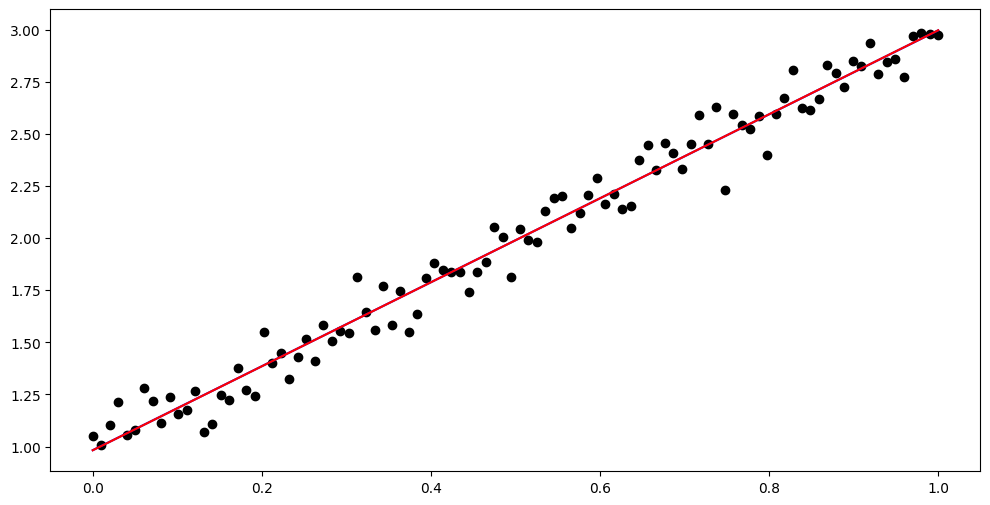

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import pymc3 as pm

# Generate synthetic data
np.random.seed(42)
X = np.linspace(0, 1, 100).reshape(-1, 1)
y = 2 * X.ravel() + 1 + np.random.normal(scale=0.1, size=X.shape[0])

# Frequentist Linear Regression
model_freq = LinearRegression()
model_freq.fit(X, y)
y_pred_freq = model_freq.predict(X)

# Bayesian Linear Regression
with pm.Model() as model_bayes:
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    sigma = pm.HalfNormal('sigma', sigma=1)
    mu = alpha + beta * X.ravel()
    Y_obs = pm.Normal('Y_obs', mu=mu, sigma=sigma, observed=y)
    trace = pm.sample(1000, return_inferencedata=False)

alpha_bayes = np.mean(trace['alpha'])
beta_bayes = np.mean(trace['beta'])
y_pred_bayes = alpha_bayes + beta_bayes * X.ravel()

# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(X, y, label='Data', color='black')
plt.plot(X, y_pred_freq, label='Frequentist Linear Regression', color='blue')
plt.plot(X, y_pred_bayes, label='Bayesian Linear Regression', color='red')
plt.fill_between(X.ravel(), y_pred_bayes - np.std(trace['alpha'] + trace['beta'][:, np.newaxis] * X.ravel(), axis=0),
                 y_pred_bayes + np.std(trace['alpha'] + trace['beta'][:, np.newaxis] * X.ravel(), axis=0),
                 color='red', alpha=0.3, label='Bayesian Uncertainty')
plt.legend()
plt.title('Comparison of Frequentist and Bayesian Linear Regression')
plt.show()


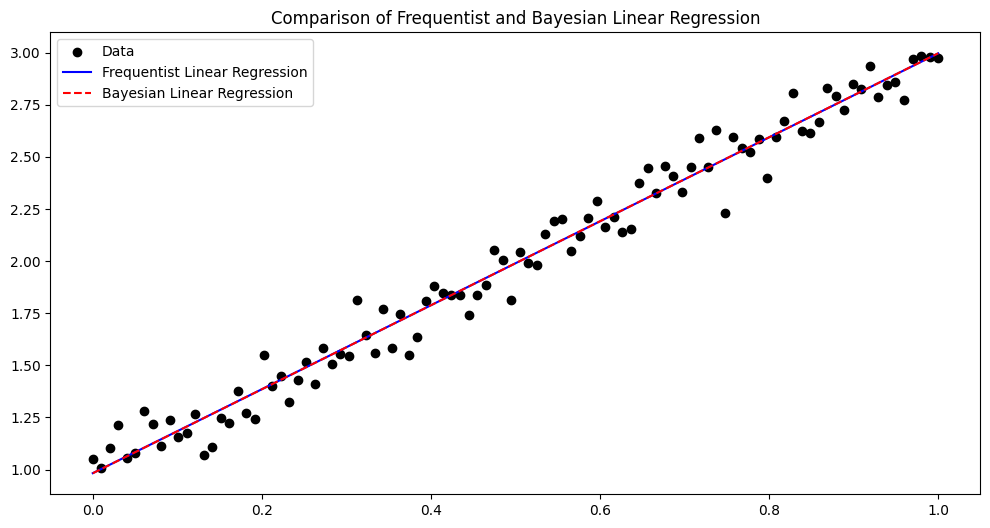

In [7]:
# Plotting
plt.figure(figsize=(12, 6))
plt.scatter(X, y, label='Data', color='black')
plt.plot(X, y_pred_freq, label='Frequentist Linear Regression', color='blue')
plt.plot(X, y_pred_bayes, label='Bayesian Linear Regression', color='red', linestyle='--')
# plt.fill_between(X.ravel(), y_pred_bayes - np.std(trace['alpha'] + trace['beta'][:, np.newaxis] * X.ravel(), axis=0),
#                  y_pred_bayes + np.std(trace['alpha'] + trace['beta'][:, np.newaxis] * X.ravel(), axis=0),
#                  color='red', alpha=0.3, label='Bayesian Uncertainty')
plt.legend()
plt.title('Comparison of Frequentist and Bayesian Linear Regression')
plt.show()

In [132]:
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Generate a synthetic imbalanced dataset
X, y = make_classification(n_classes=2, class_sep=0.5, weights=[0.05, 0.95],
                           n_informative=5, n_redundant=1, flip_y=0,
                           n_features=20, n_clusters_per_class=1,
                           n_samples=10000, random_state=10)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

unique_values, counts = np.unique(y_resampled, return_counts=True)
print(counts)

# Train a classifier
clf = RandomForestClassifier(random_state=42)
clf.fit(X_resampled, y_resampled)

# Make predictions and evaluate
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.98      0.30      0.46       148
           1       0.97      1.00      0.98      2852

    accuracy                           0.97      3000
   macro avg       0.97      0.65      0.72      3000
weighted avg       0.97      0.97      0.96      3000

[6648 6648]
              precision    recall  f1-score   support

           0       0.73      0.63      0.67       148
           1       0.98      0.99      0.98      2852

    accuracy                           0.97      3000
   macro avg       0.85      0.81      0.83      3000
weighted avg       0.97      0.97      0.97      3000

